In [1]:
#A code to analyze image cubes from the JWST nirspec ifu - examples here are done with CO
#By Adam E. Rubinstein

# load important packages
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d #UnivariateSpline
import os
import sys

from astropy.io import fits #, ascii
from astropy import units as u
import pandas as pd
from photutils.aperture import RectangularAperture #, RectangularAnnulus, SkyCircularAperture
from spectral_cube import SpectralCube

# Figure 1: Test Spaxel and Spectral Fits
First determine test spaxel

Then determine residuals, chi^2

Plot all together

In [2]:
#set up file paths
protostars = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
protostar_fullnames = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104']
protostar_names = ['IRAS 16253-2429', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126+4104'] #need to name things and index things

#data lists
# make a simple 1d spectrum of the central region, taking sum or median to attempt to account for cosmic rays
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental round 2 with initial changes to baselines, used to correctly place lines along wavelength axis
# offset_list = [7.5e-5, 0.0002, -0.0005, 0, 0.00045] #experimental including baseline fits with some influence by dan
# wave_cutoff_list = np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939]) #used to define regions where baseline has cutoffs into sub-regions
wave_cutoff_list_stacked = [
                            np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.86, 4.971]),
                            np.array([4.19, 4.32, 4.37, 4.415, 4.62, 4.72, 4.87, 4.941]),
                            np.array([4.19, 4.32, 4.37, 4.4, 4.62, 4.72, 4.87, 4.939]),
                            np.array([4.19, 4.32, 4.37, 4.42, 4.58, 4.69, 4.79, 4.865, 4.939]),
                            np.array([4.19, 4.32, 4.37, 4.4, 4.61, 4.695, 4.775, 4.84, 5.0]) # 4.939
                            ]

#source properties
central_sources_list = [[(47,45)], [(53,43), (45,43)], [(42, 45), (49, 54)], [(42, 38), (42, 46)], [(42, 43), (58, 52)]] #based on line to cont ratio
isotope_theta = [0.0, 0.0, 50.0, 0.0, 35.0]
arc_to_pix = 2.7777778191699e-05 * 3600.0 #take 1 pix in degrees, convert to arcsec, then can divide by this to convert
aper_dims = [(0.51, 0.51), (0.68, 0.68), (0.53, 0.53), (0.67, 0.67), (0.49, 0.44)] #arcsecs
source_names_list = ['IRAS 16253-2429', ['B335W', 'B335E'], ['HOPS 153SE', 'HOPS 153NW'], ['HOPS 370S', 'HOPS 370N'], ['IRAS 20126+4104SE', 'IRAS 20126+4104NW']]


#13co lines?
#currently using P15 to P50
co_isotopologue_lines = [5.333388488, 5.318877235, 5.30451849, 5.29031078, 5.276252668, 5.26234273, 5.248579578, 5.234961839, 5.221488168, 5.208157241, 5.194967755, 5.181918437, \
    5.169008024, 5.15623528, 5.143598992, 5.131097968, 5.118731029, 5.106497024, 5.094394818, 5.082423295, 5.070581362, 5.058867934, 5.047281958, 5.035822391, \
    5.024488207, 5.013278402, 5.002191988, 4.991227989, 4.980385452, 4.969663437, 4.95906102, 4.948577297, 4.938211373, 4.927962373, 4.917829436, 4.907811716]
co_v2_or_3_lines = [4.916094136, 4.925723328, 4.926943518, 4.936135614, 4.93791873, 4.946671911, 4.949020785, 4.957333173, 4.960250699, 4.966840267, 4.968120359, 4.971609517, \
                    4.979034458, 4.983098297, 4.990076467, 4.994718123, 5.018355322, 5.023980249, \
                    5.144797803, 5.14575249, 5.158228694, 5.171807925, 5.185536908, 5.19941707, 5.213449873, 5.227636799]

contaminated_line_list = [4.40979113, 4.4166107, 4.575481, 4.6066, 4.65378, \
                    4.694613954, 4.8891387, 4.954, 5.053115, 5.12865] #these are the lines that are affected (only noted by wavelength, easier to look up)


In [3]:
all_co_v1_lines = [4.500959885, 4.507051384, 4.513237261, 4.519517926, 4.525893799, \
                4.532365318, 4.538932922, 4.545597064, 4.552358211, 4.559216838, 4.566173427, 4.573228479, 4.5803825, 4.587636009, 4.594989537, 4.602443624, 4.609998825, 4.617655702, 4.625414834, \
                4.633276808, 4.641242226, 4.649311699, 4.65748585, 4.674150758, 4.682642826, 4.691242198, 4.699949566, 4.708765629, 4.717691102, 4.726726717, 4.735873214, 4.745131351, 4.754501896, \
                4.763985637, 4.773583372, 4.783295919, 4.793124102, 4.80306877, 4.81313078, 4.823311007, 4.833610347, 4.844029703, 4.854570003, 4.865232183, 4.876017203, 4.886926039, 4.897959679, \
                4.909119137, 4.920405435, 4.931819626, 4.943362768, 4.955035947, 4.966840267, 4.978776848, 4.990846834, 5.003051384, 5.015391683, 5.027868929, 5.040484354, 5.0532392, 5.066134734, \
                5.07917225, 5.092353062, 5.105678503, 5.119149935, 5.132768744, 5.146536333, 5.160454145, 5.174523632, 5.188746281, 5.203123603, 5.217657137, 5.232348453, 5.247199138, 5.262210819, \
                5.277385145, 5.292723799, 5.308228493, 5.323900965, 5.339742993]

co_v2_lines = [5.256479084, 5.241979357, 5.227636799, 5.213449873, 5.19941707, 5.185536908, 5.171807925, 5.158228694, 5.144797803, 5.131513876, 5.11837555, 5.105381494, 5.092530394, 5.079820964, \
               5.067251937, 5.054822073, 5.042530141, 5.030374953, 5.018355322, 5.006470094, 4.994718123, 4.983098297, 4.971609517, 4.960250699, 4.949020785, 4.93791873, 4.926943518, 4.916094136, \
            4.905369598, 4.894768936, 4.884291195, 4.873935441, 4.863700752, 4.853586225, 4.843590978, 4.833714138, 4.82395485, 4.814312274, 4.804785588, 4.795373983, 4.786076664, 4.776892852, \
            4.767821783, 4.758862707, 4.750014887, 4.741277599, 4.732650137, 4.732650137, 4.715721925, 4.707419823]


In [3]:
gaslines_file_list = [glob('Ices/' + i + '*_GasLines_corrected.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here!
co_file_list = [glob('Ices/' + i + '*_COLines_corrected.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here!
ices_file_list = [glob('Ices/' + i + '*ice*.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here!
transmission_file_list = [glob('Ices/' + i + '_NIRspec_cube_pspline_asls_transmission.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here!
baseline_file_list = [glob('Baseline/' + i + '*.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here!
baseline_subtracted_file_list = [glob('Baseline_Subtracted/' + i + '*.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here!
cont_file_list = [glob('Continuum/' + i + '*pspline*.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here!
cube_file_list = [glob(i + '/' + '*.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here! note the path
resid_file_list = [glob('Cube_Fit_Results' + '/' + '*_resid.fits')[0].replace('\\', '/') for i in protostars] #change the wildcard '*' here! note the path


#plotting test spectra here
from pybaselines import Baseline #need this for one thing...plotting spectral sub-regions
plot_show_list = [False, False, False] #used if we want to show certain plots below
average = 'sum'

#loop through, read in data files, extract data at single pixel, plot
for i in range(len(protostars)):
    # if protostars[i] != 'IRAS16253':
    #     continue


    #need to do this first to get wavelengths and initialize some arrays for plotting spectra
    hdul = fits.open(cube_file_list[i]) #separated out line here since need to use hdul a few times
    orig_cube = SpectralCube.read(hdul[1]) #accessing the cube for data  

    # define the wavelength grid (microns) from the header
    wave_offset = offset_list[i] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
    wave_factor = 1 #/1.001 #for wavelength calibrating
    wave_units = 1 #1e6 #to convert from meters to microns, for original data just set to 1
    wave = wave_factor * wave_units * orig_cube.spectral_axis.value + wave_offset
    wave = wave[1:-1] #need to make correct axis size

    #intialized arrays
    co_line_fit = np.zeros(wave.shape)
    gas_line_fit = np.zeros(wave.shape)
    continuum_fit = np.zeros(wave.shape)
    ice_fit = np.zeros(wave.shape)
    baseline_fit = np.zeros(wave.shape)
    total_fit = np.zeros(wave.shape) #to be filled in
    resid_data = np.zeros(wave.shape) #to be filled in
    orig_data = np.zeros(wave.shape) #to be filled in
    err_data = np.zeros(wave.shape) #to be filled in

    for k in range(len(central_sources_list[i])):

        #now extract only a smaller portion from the general cubes
        rect_aper = RectangularAperture((central_sources_list[i][k][0], central_sources_list[i][k][1]), aper_dims[i][0]/arc_to_pix, aper_dims[i][1]/arc_to_pix, theta=isotope_theta[i]*np.pi/180) #only need to define once
        rect_mask = rect_aper.to_mask()

        #read in gas lines
        processed_cube = SpectralCube.read(fits.open(baseline_file_list[i])[0]) #accessing the cube for data 
        data_list = [] #dummy list
        for data_2d in processed_cube._data: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        baseline_fit += np.sum(np.array(data_list), axis=(1,2))

        #read in gas lines
        processed_cube = SpectralCube.read(fits.open(gaslines_file_list[i])[0]) #accessing the cube for data 
        data_list = [] #dummy list
        for data_2d in processed_cube._data: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        gas_line_fit += np.sum(np.array(data_list), axis=(1,2))
        total_fit += np.sum(np.array(data_list), axis=(1,2))           #compute total fit from a fitted components

        #read in co lines
        processed_cube = SpectralCube.read(fits.open(co_file_list[i])[0]) #accessing the cube for data 
        data_list = [] #dummy list
        for data_2d in processed_cube._data: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        co_line_fit += np.sum(np.array(data_list), axis=(1,2))
        # total_fit += np.sum(np.array(data_list), axis=(1,2))           #compute total fit from a fitted components

        #read in ices
        processed_cube = SpectralCube.read(fits.open(ices_file_list[i])[0]) #accessing the cube for data  
        data_list = [] #dummy list
        for data_2d in processed_cube._data: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        ice_fit += np.sum(np.array(data_list), axis=(1,2))
        total_fit += np.sum(np.array(data_list), axis=(1,2))            #compute total fit from a fitted components

        #read in continuum
        processed_cube = SpectralCube.read(fits.open(cont_file_list[i])[0]) #accessing the cube for data 
        data_list = [] #dummy list
        for data_2d in processed_cube._data: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        continuum_fit += np.sum(np.array(data_list), axis=(1,2))
        total_fit += np.sum(np.array(data_list), axis=(1,2))            #compute total fit from a fitted components

        #read in original data and noise
        data_list = [] #dummy list
        for data_2d in orig_cube._data[1:-1,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        orig_data += np.sum(np.array(data_list), axis=(1,2)) 

        data_list = [] #dummy list
        for data_2d in hdul['ERR'].data[1:-1,:,:]: #loop through data to mask properly
            data_list.append(rect_mask.cutout(data_2d))
        err_data += np.sum(np.array(data_list), axis=(1,2)) 



    #plotting and saving first the direct observations, fit, and residuals
    if plot_show_list[0] == True:
        # fig, (ax, ax_resid) = plt.subplots(nrows=2, ncols=1, figsize=(15,10), sharex=True, gridspec_kw={'height_ratios': [3, 1]}) #setup fig, axes
        fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes

        #plot data and fit on first axis
        ax.plot(wave, orig_data, color='xkcd:grassy green', label=protostar_fullnames[i] + ' Spectrum') #plot observation here!
        # ax.plot(wave, baseline_fit + co_line_fit, 'goldenrod', label='CO Line Fit', linestyle='--')
        # full_fit_checks = [ax.axvline(vert) for vert in [3.726, 4.3435, 4.62, 5.055]] # to check lines

        #noting sub-regions for where the fit is broken up
        baseline_fitter = Baseline(wave, check_finite=False)     #preset the top hat filter version
        bkg_top = baseline_fitter.tophat(baseline_fit, half_window=3)[0]
        cutoffs_flux_matched = bkg_top[[np.abs(wave - j).argmin() for j in wave_cutoff_list_stacked[i]]]     #formulating regimes to cutoff the spectrum and apply different smoothing factors
        ax.scatter(wave_cutoff_list_stacked[i], cutoffs_flux_matched, color='black', zorder=100, label='Fit Boundary') #or can use oranges 

        #formulating a pseudo-continuum based on the baseline to determine ices and a transmission curve
        ax.plot(wave, baseline_fit, 'k', label='Baseline', linestyle='--') #baseline
        ax.plot(wave, continuum_fit, linewidth=2, color='xkcd:vibrant purple', linestyle=':', label='Continuum (Spline)') # or can use xkcd:carnation pink
        # ax.plot(wave, total_fit, 'goldenrod', label='Total Fit', linestyle='--')

        #random lines of doom to redistribute???
        # vline = [ax.axvline(line, color='black') for line in contaminated_line_list]
        # vline = [ax.axvline(line, color='black') for line in all_co_lines]
        # vline = [ax.axvline(line, color='black') for line in co_v2_lines]

        # #general formatting plot
        if i == 0 or i == 3 or i == 4:
            legend = ax.legend(loc='lower right', fontsize=24, edgecolor='white')
        else:
            legend = ax.legend(loc='upper left', fontsize=24, edgecolor='white')
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((0, 0, 0, 0))

        #formatting plot
        ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
        # ax.set_xlim(5, np.max(wave))
        # ax.set_ylim(500,)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40) #need to set the xlabel here first
        ax.set_ylabel('Intensity (MJy/sr)', fontsize=40)
        ax.tick_params(axis='both', which='major', labelsize=25)

        #x-axis must be set together...then save...
        # ax.set_xticks(np.arange(3, 5.25, 0.25))
        ax.set_xlim(4.35, np.max(wave))

        # ax_resid.set_xlim(4.4,)
        # ax.set_xlim(5.0, 5.1)
        fig.savefig('CentralSource_CO/' + protostars[i] + '_FitObs.pdf') #save plot


    #sample plot to check out the fitted lines themselves
    if plot_show_list[1] == True:
        fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes

        # ax.plot(wave, ice_fit, linewidth=2, color='xkcd:red', linestyle='-.', label='Pseudo-ices')
        # ax.plot(wave, gas_line_fit, color='xkcd:orange', label='Fitted Gas Lines')
        ax.plot(wave, co_line_fit, color='xkcd:orange', label='Fitted CO Lines')
        ax.plot(wave, orig_data - total_fit, color='xkcd:twilight blue', label='Residual', alpha=0.9)

        #random lines of doom to redistribute???
        # vline = [ax.axvline(line, color='black') for line in contaminated_line_list]
        # vline = [ax.axvline(line, color='black') for line in all_co_lines]
        # vline = [ax.axvline(line, color='black') for line in co_v2_lines]

        #formatting
        legend = ax.legend(loc='upper left', fontsize=24, edgecolor='white')
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((0, 0, 0, 0))
        ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
        ax.set_xlim(4.35, np.max(wave))

        # fig.savefig('CentralSource_CO/' + protostars[i] + '_FitComponents.pdf') #save plot


    #sample plot to check out the ratio of residuals and line emission..
    if plot_show_list[2] == True:
        fig, ax = plt.subplots(figsize=(15,10)) #setup fig, axes
        ax.plot(wave, (orig_data - total_fit) / co_line_fit, color='xkcd:amber', label='Ratio of Residuals to Fitted Gas Lines')
        vlines_isotopologues = [ax.axvline(isotopologue_wave, ymin=0.3, ymax=0.5, color='blue') for isotopologue_wave in co_isotopologue_lines]
        vlines_highorder = [ax.axvline(isotopologue_wave, ymin=0.35, ymax=0.45, color='red') for isotopologue_wave in co_v2_or_3_lines]

        #formatting
        legend = ax.legend(loc='upper left', fontsize=24, ncol=2, edgecolor='white')
        legend.get_frame().set_alpha(None)
        legend.get_frame().set_facecolor((0, 0, 0, 0))
        ax.axhline(0, color='k', linestyle=':') #a horizontal line at zero
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.set_xlabel(r'$\rm \lambda \ (\mu m)$', fontsize=40)
        ax.set_xlim(4.35, np.max(wave))
        # ax.set_yscale('log')
        ax.set_ylim(-100, 100)
        # fig.savefig('CentralSource_CO/' + protostars[i] + '_FitComponents.pdf') #save plot


IndexError: list index out of range

['Cube_Fit_Results\\B335_NIRspec_cube_basefit_tophat_jcbd_chi2_unc=errMap.fits', 'Cube_Fit_Results\\HOPS153_NIRspec_cube_basefit_tophat_jcbd_chi2_unc=errMap.fits', 'Cube_Fit_Results\\HOPS370_NIRspec_cube_basefit_tophat_jcbd_chi2_unc=errMap.fits', 'Cube_Fit_Results\\IRAS16253_NIRspec_cube_basefit_tophat_jcbd_chi2_unc=errMap.fits', 'Cube_Fit_Results\\IRAS20126_NIRspec_cube_basefit_tophat_jcbd_chi2_unc=errMap.fits']


NameError: name 'protostar_names' is not defined

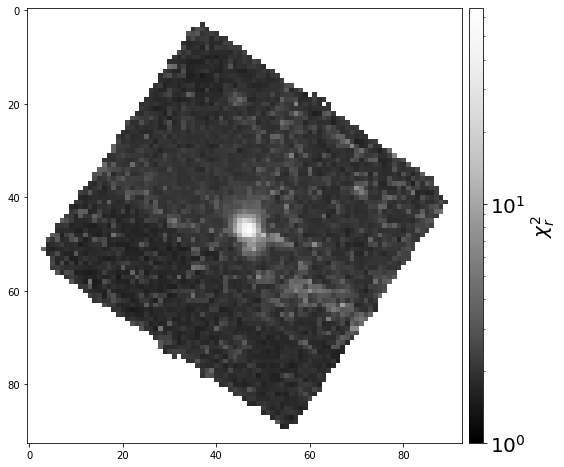

In [4]:
#save and plot the chi^2 maps to check the global quality of fits we're using
chi2_path_list = glob('Cube_Fit_Results/*chi2*')
print(chi2_path_list) #check order
hdul = [fits.open(chi2_path_list[3]), fits.open(chi2_path_list[0]), fits.open(chi2_path_list[1]), fits.open(chi2_path_list[2]), fits.open(chi2_path_list[4])] #read in hdu and reorder it by mass to double check some effects
chi2_arrs = [i[0].data for i in hdul] #open slices

#looping over protostars and plotting
for protostar_ind in range(len(chi2_path_list)):
    fig, ax= plt.subplots(figsize=(10,8)) #declaring a space for figure and axes
    from matplotlib.colors import LogNorm #testing if logarithmic scale is better
    im = ax.imshow(chi2_arrs[protostar_ind][::-1], cmap='Greys_r', norm=LogNorm(vmin=1e0)) 

    #add on a color bar
    cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
    cbar = plt.colorbar(im, cax=cax) 
    cbar.ax.tick_params(labelsize=20)
    cbar.update_ticks()
    # exponent = int(np.floor(np.log10(np.nanmean(median_co_list[protostar_ind])/10))) #from a tip by https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
    # exponent = int(np.floor(np.log10(sum_co_list[protostar_ind][central_sources[protostar_ind][0], central_sources[protostar_ind][1]])))

    cbar.set_label(r'$\chi_r^2$', size=20)
    # cbar.set_label(label='Flux (' + r'$\times 10^{{{0}}} \ $'.format(exponent) + r'$\rm erg \ s^{-1} \ {cm}^{-2})$', size=20)
    # cbar.ax.yaxis.get_offset_text().set_fontsize(0) #then use this text object to put in order of max...
    # cbar.yaxis.get_offset_text().set_visible(False) #better method

    #formatting
    ax.text(1,chi2_arrs[protostar_ind].shape[0]-2, protostar_names[protostar_ind], fontsize=20, color='black')
    ax.tick_params(axis='both', which='both', length=0)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # fig.savefig('CentralSource_CO/' + protostars[protostar_ind] + '_chi2Map.pdf')

    # fig.clf() #if don't want any display

# Read in CO data and display summed (high S/N) maps of vibrational states. 

Also can show line/continuum ratio as an optional figure idea

In [4]:
#processing fits images of CO line emission to be saved...
#first define some lists to loop over for the different CO line series
# protostar_list = ['IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
# protostar_names = ['IRAS 16253', 'B335', 'HOPS 153', 'HOPS 370', 'IRAS 20126'] #just to add some spaces
v_list = ['1*', '2*'] #, '3*']
j_list = ['R*', 'P*']
pc_to_cm = 3.086e18
dist_list = pc_to_cm*np.array([150, 165, 390, 390, 1.55e3]) #pc: from Ortiz-Leon 2018, Watson 2020, Tobin+2020a, Tobin+2020a, Reid+2019

#some lists related to correcting for ices
transmission_folder = 'Ices/'
transmission_file_end = '_NIRspec_cube_pspline_asls_transmission.fits' 
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental, from cube fitting, needed to fix wavelengths we're using here

#a function to generate lists of co line intensity maps for our protostars
def co_data_output(protostar_str, v_str, j_str):
    #read in some protostellar images for each protostar
    co_file_list = sorted(glob('Line_Images/'+ protostar_str + '*_CO*v=' + v_str + j_str + '.fits'), key=lambda x: int(x.split('_')[-2][-2:]), reverse=True) #change the wildcard '*' here!; note we need the key to order images by number...

    #extract useful values and labels from file names in case of saving...
    #just using an example star to figure out general process (whatever is first), then loop later
    co_j =  [i.split('_')[-2][-2:] for i in co_file_list] 
    co_wavelengths = np.array([float(i.split('_')[-1][:-5]) for i in co_file_list])

    #setting up and correcting units
    hdul_co = [fits.open(j) for j in co_file_list]     #extract hdu files from paths
    sr_conversion = np.abs(hdul_co[0][0].header['CDELT1'] * hdul_co[0][0].header['CDELT2'] / (180. / np.pi)**2.0) #square degrees to steradians, should be consistent throughout all images (?)
    # mega_conversion = 1e6 #can swap out with Jy conversion to preferred units...
    co_data = [j[0].data*sr_conversion for j in hdul_co]     #extracting data for each hdu, converting units

    #reading in transmission file needed to slightly correct data
    protostar_ind = protostars.index(protostar_str) #if you'd like to do this by indexing
    hdul_transmission = fits.open(transmission_folder + protostar_str + transmission_file_end) #read in hdu
    transmission_cube = SpectralCube.read(hdul_transmission[0]) #accessing the cube for data  
    transmission_data = np.array(transmission_cube._data, dtype=np.float64) #open transmission slices
    co_header = transmission_cube[0].header #we need headers for later, but we can only take one slice (doesn't work if NAXIS > 2: https://github.com/aplpy/aplpy/issues/449)
    jwst_wavelengths = transmission_cube.spectral_axis.value/1e-6 + offset_list[protostar_ind]
    transmit_splined = interp1d(jwst_wavelengths, transmission_data, axis=0) #transmission data

    #correcting for ices by dividing them out as a transmission filter centered at the peak wavelength of each line
    # wave_cutoff_idx = np.where((co_wavelengths > 4.52)*(co_wavelengths < 4.96))[0]     #first spline the transmission curve, masking it where we want to apply it (wavelengths between 4.52 and 4.96)
    # co_data_corrected = [co_data[j] / transmit_splined_list[protostar_ind](co_wavelengths[j]) for j in wave_cutoff_idx] #then apply transmission curve
    co_data_corrected = []
    for i in range(len(co_wavelengths)): #making a brute force loop and condition since the mask wasn't working right
        if co_wavelengths[i] > 4.52 and co_wavelengths[i] < 4.96:
            co_data_corrected.append(co_data[i] / transmit_splined(co_wavelengths[i]))
        else:
            co_data_corrected.append(co_data[i])

    #applying smoothing or SNR cut (optional)
    # jwst_err_cube = hdul['ERR'].data #not using spectral cube here
    # err_flux1 = np.array(jwst_err_cube[:, ind1, ind2], dtype=np.float64)
    # flux1[ flux1/err_flux1 < 1] = 0
    # print(type(flux1[0])) #checking if float64

    return co_j, co_wavelengths, co_data, co_data_corrected, co_header, transmit_splined

In [5]:
#defining table of qualitatively well-detected and poorly detected CO lines
detections_path = 'CO_detections.xlsx'
detection_column_names = ['Wv, microns', 'Species', 'Transition, v', 'Transition, J', 'IRAS16253', 'B335', 'HOPS153', 'HOPS370', 'IRAS20126']
co_detections  = pd.read_excel(detections_path, header=1, usecols=detection_column_names)

#separating this into two tables by 13CO
CO_isotopes = co_detections.loc[co_detections['Species'] == '13CO']
co_forest = co_detections.loc[co_detections['Species'] != '13CO']
# print(CO_isotopes)
# print(co_forest)

#using the table, making a function to filter out low SNR data
def data_filter(vib_ind, co_v_r_wavelengths, co_v_r_j, co_v_r_data_corrected, co_v_p_wavelengths, co_v_p_j, co_v_p_data_corrected):
    #sorting out the poorly measured lines using our table co_forest
    for detection_ind in range(len(co_forest[detection_column_names[0]])):
        #collect useful values from table
        detection_row = co_forest.iloc[[detection_ind]][protostars[i]].values[0] #find row
        detection_wave = co_forest.iloc[[detection_ind]][detection_column_names[0]].values[0] #find wavelength
        detection_j = co_forest.iloc[[detection_ind]][detection_column_names[3]].values[0] #find J transition

        #making an array to fill in with nans and replace a bad image with
        nan_arr = np.empty(co_v_r_data_corrected[0].shape)
        nan_arr[:] = np.nan

        #if you want to eliminate some poor detections for R branch lines
        if detection_j.find('R') != -1:
            wave_match_ind = np.argmin(np.abs(co_v_r_wavelengths - detection_wave))
            if (vib_ind == 0 and detection_row == 'n') or vib_ind > 0 and detection_row == ('m' or 'n'):
                co_v_r_data_corrected[wave_match_ind] = nan_arr
        
        #same on poor detections but for P branch lines
        elif detection_j.find('P') != -1:
            wave_match_ind = np.argmin(np.abs(co_v_p_wavelengths - detection_wave))
            if (vib_ind == 0 and detection_row == 'n') or vib_ind > 0 and detection_row == ('m' or 'n'):
                co_v_p_data_corrected[wave_match_ind] = nan_arr
    
    return co_v_r_data_corrected, co_v_p_data_corrected

C:\Users\arubi\AppData\Local\Temp\ipykernel_3604\818552639.py:46: RuntimeWarning: divide by zero encountered in true_divide
  co_data_corrected.append(co_data[i] / transmit_splined(co_wavelengths[i]))
C:\Users\arubi\AppData\Local\Temp\ipykernel_3604\818552639.py:46: RuntimeWarning: invalid value encountered in true_divide
  co_data_corrected.append(co_data[i] / transmit_splined(co_wavelengths[i]))
C:\Users\arubi\AppData\Local\Temp\ipykernel_3604\818552639.py:46: RuntimeWarning: divide by zero encountered in true_divide
  co_data_corrected.append(co_data[i] / transmit_splined(co_wavelengths[i]))
C:\Users\arubi\AppData\Local\Temp\ipykernel_3604\818552639.py:46: RuntimeWarning: invalid value encountered in true_divide
  co_data_corrected.append(co_data[i] / transmit_splined(co_wavelengths[i]))
C:\Users\arubi\AppData\Local\Temp\ipykernel_3604\818552639.py:46: RuntimeWarning: divide by zero encountered in true_divide
  co_data_corrected.append(co_data[i] / transmit_splined(co_wavelengths[i]

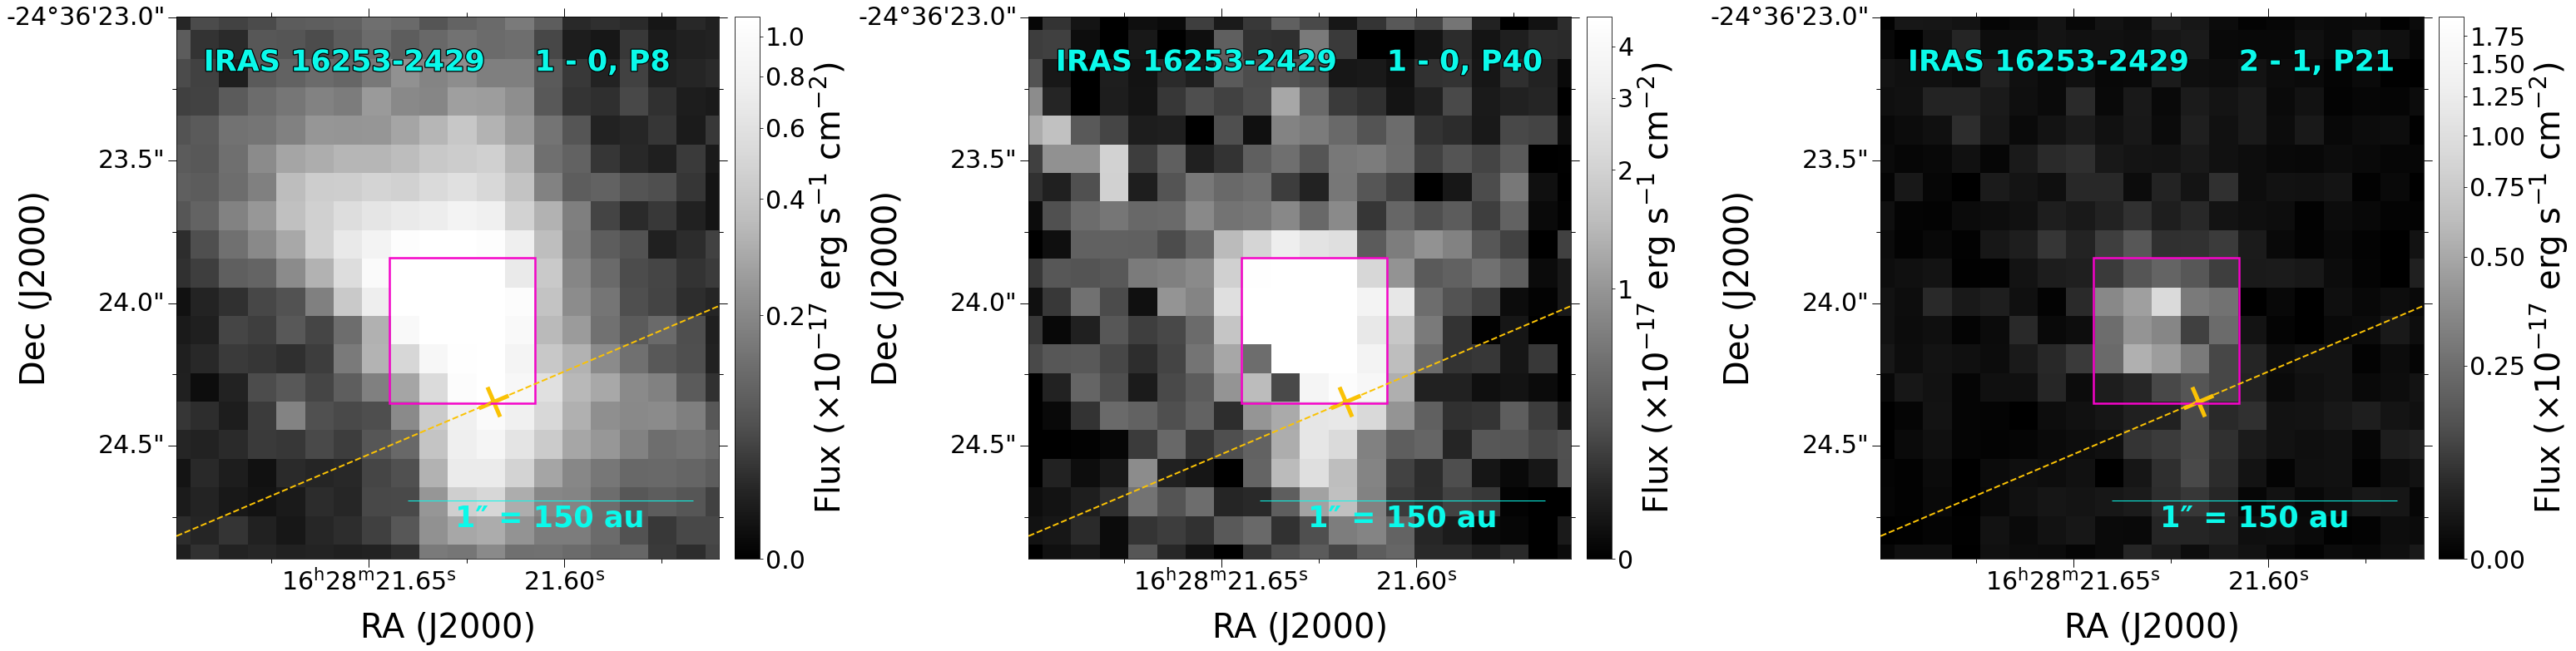

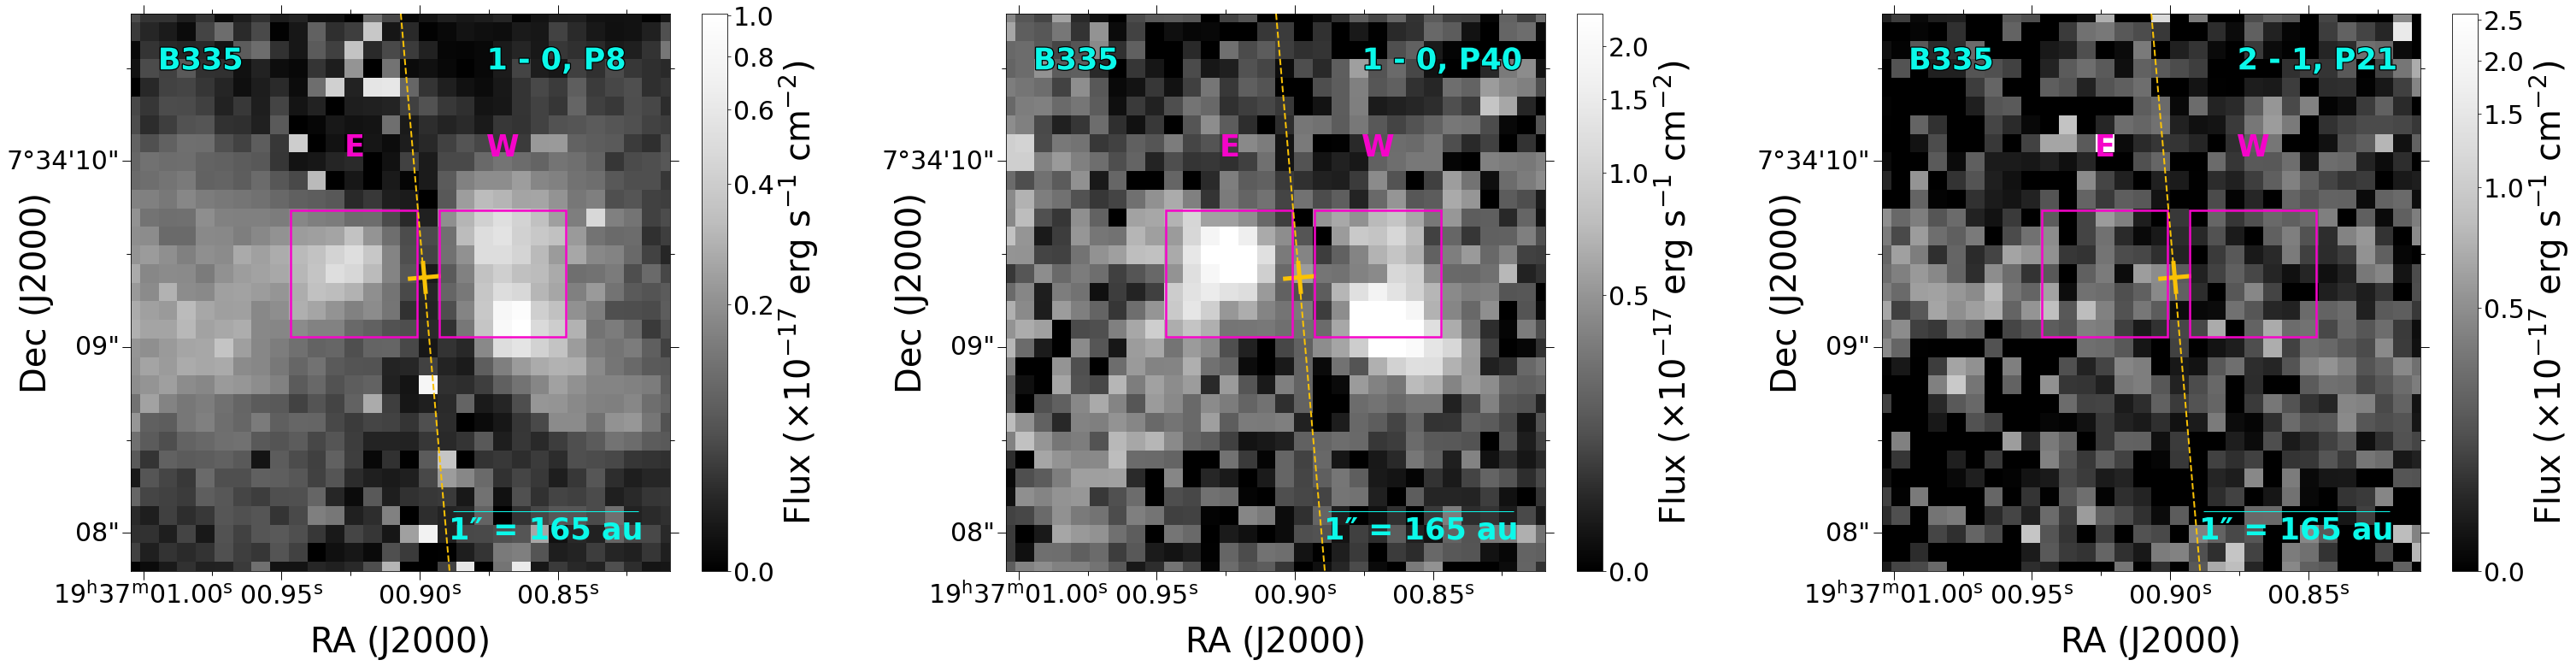

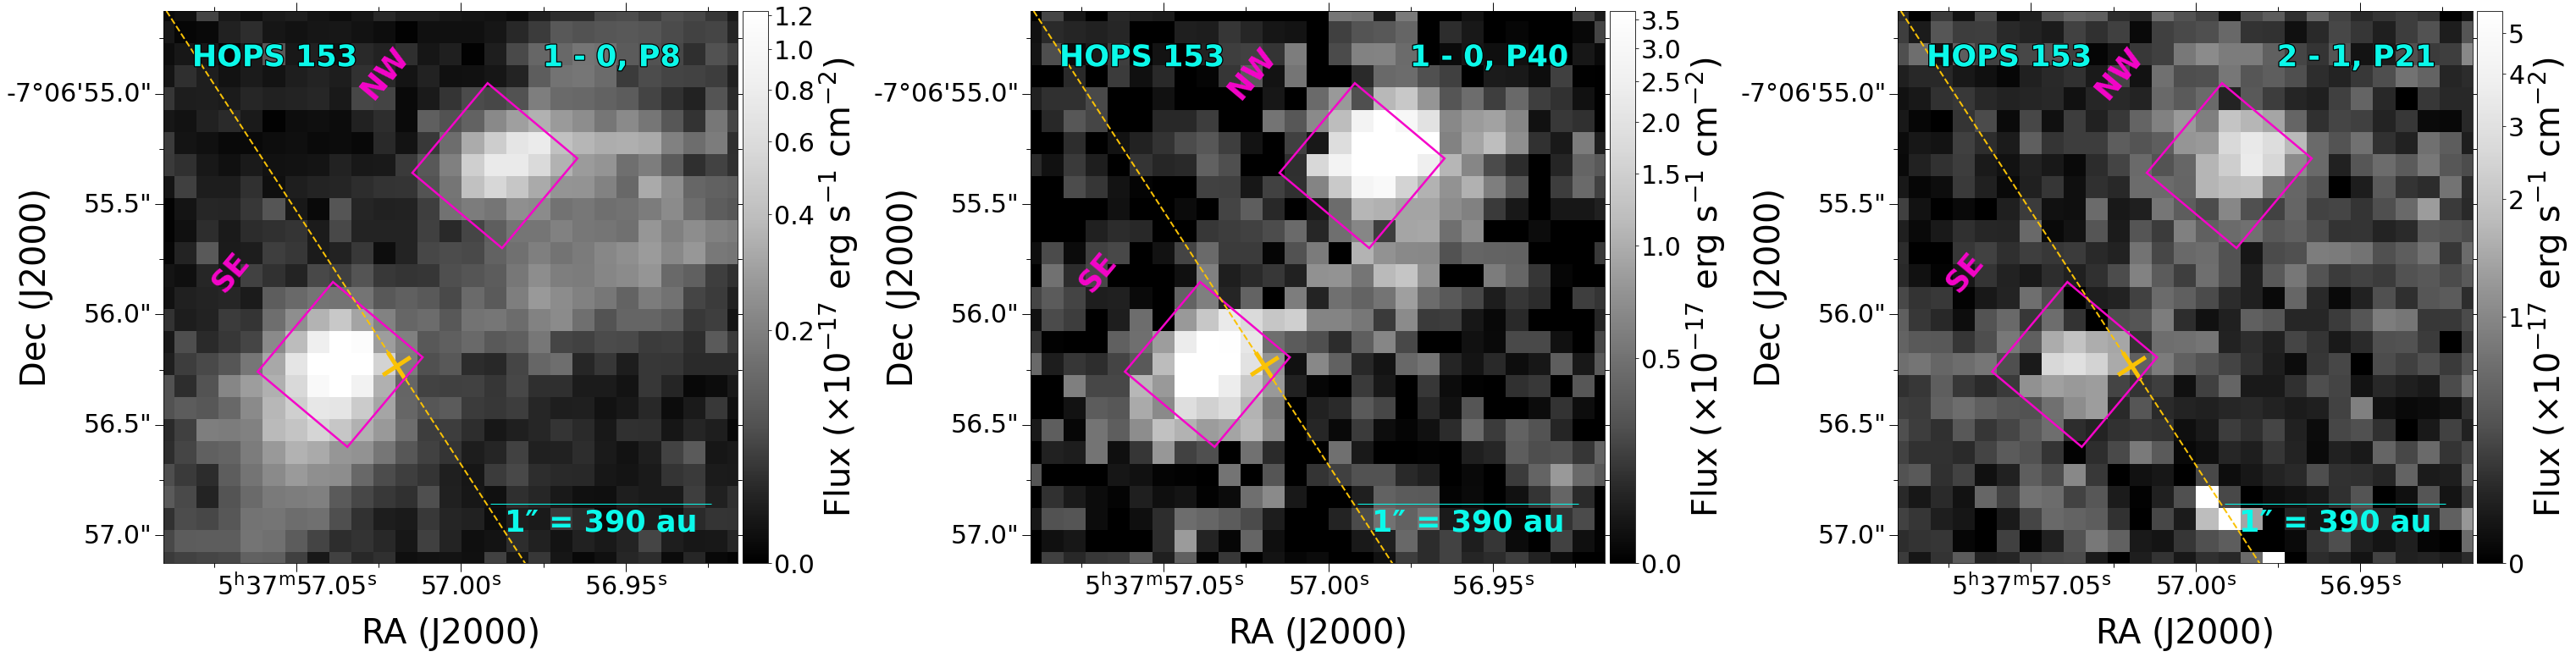

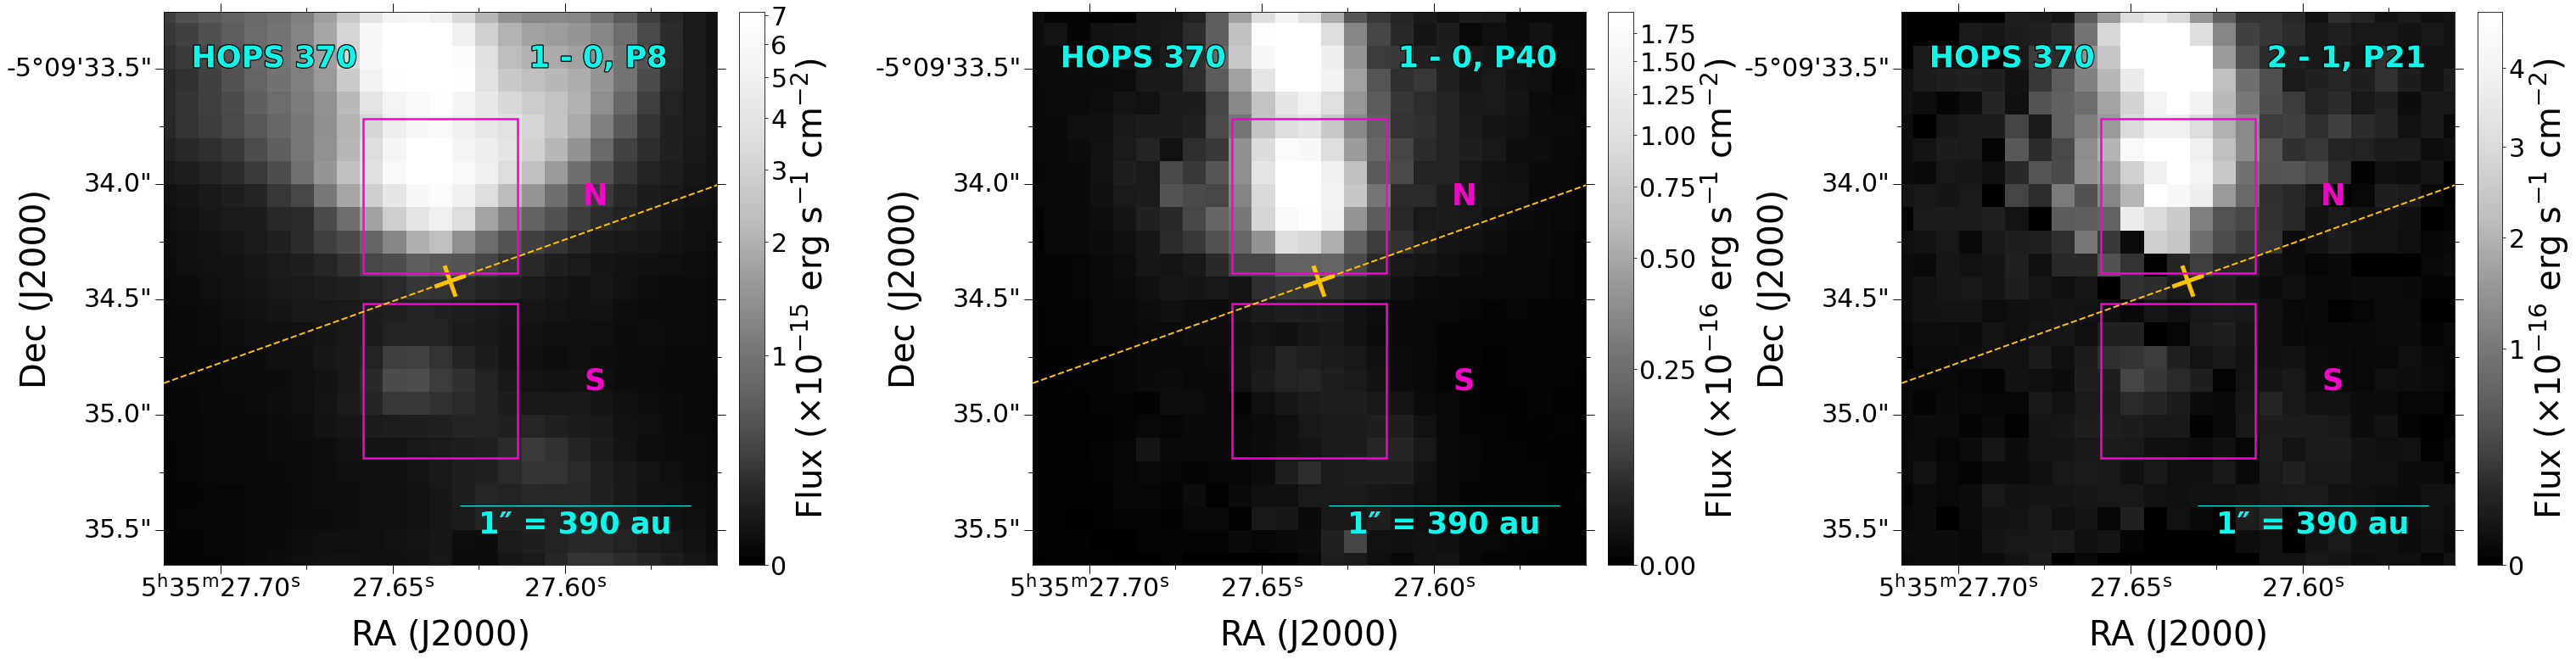

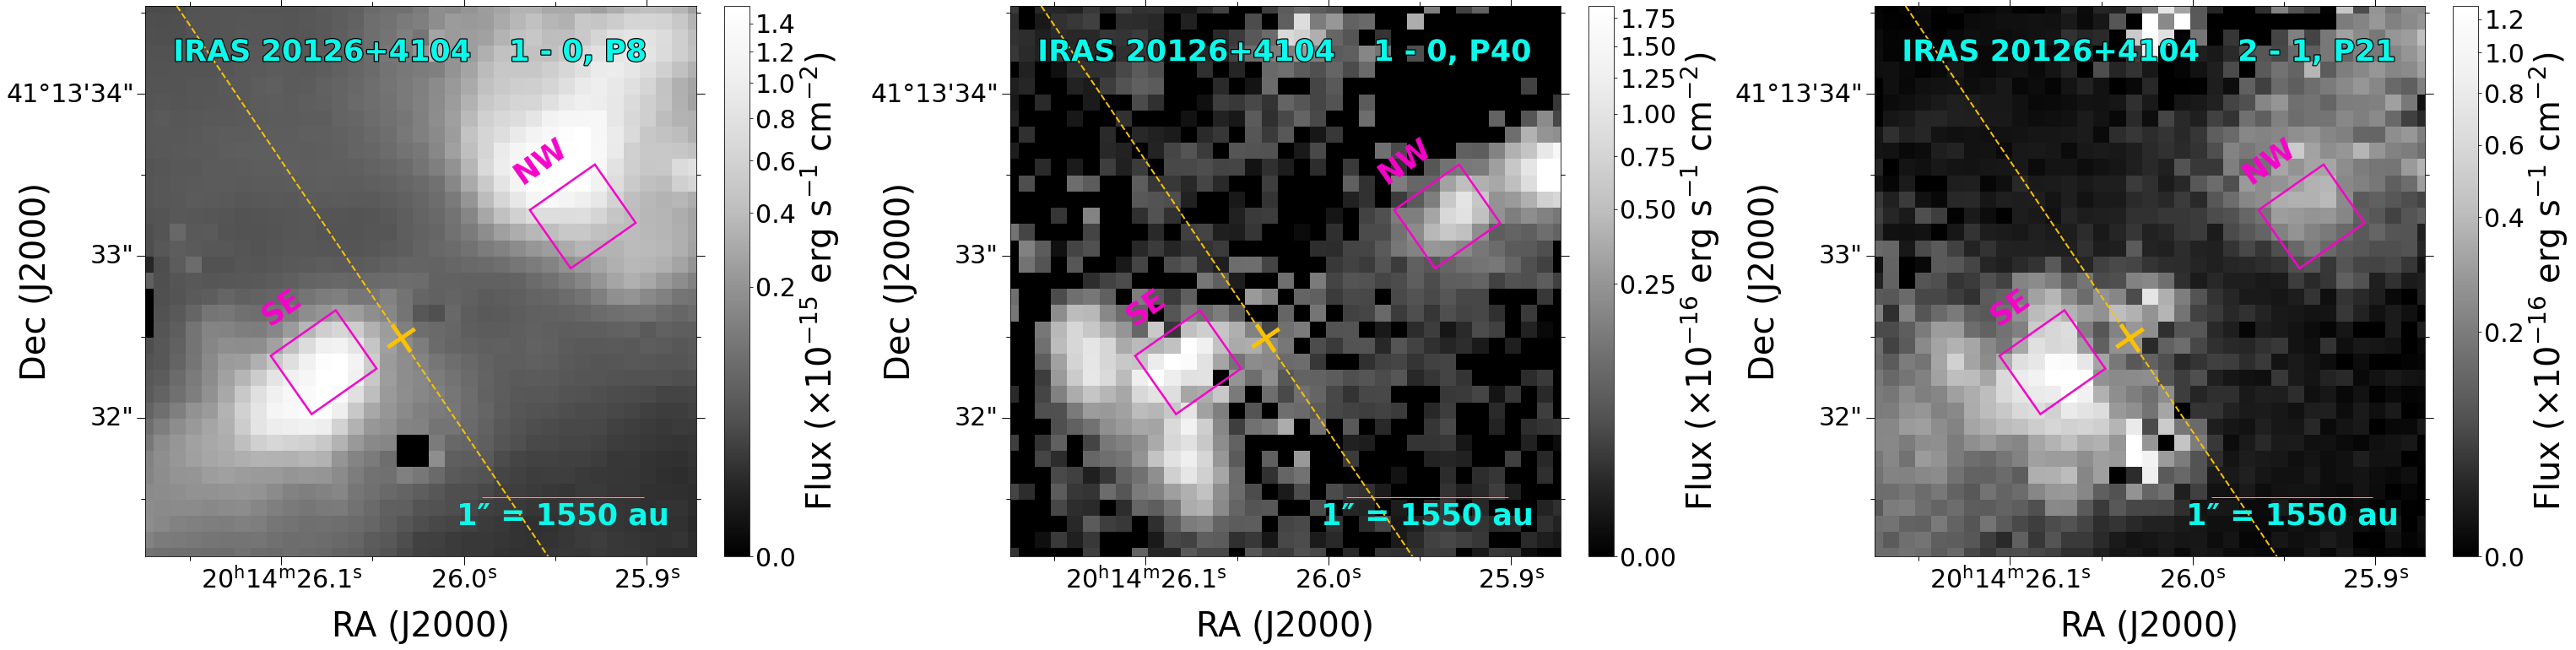

In [6]:
#general imports for plotting images
from astropy.visualization.wcsaxes import add_scalebar
from astropy.wcs import WCS
from photutils.aperture import CircularAperture, RectangularAperture #, RectangularAnnulus, SkyCircularAperture
import matplotlib.font_manager as fm
from matplotlib import patheffects, markers
# import matplotlib.patches as patches 
# from matplotlib.transforms import Affine2D
# central_sources = [(45, 44), (46, 44), (44, 40), (39, 45), (46, 42)]
# central_sources = [(46,45), (44,43), (46, 48), (47, 45), (46, 43)] #location of sources in pixels
aper_shape_list = ['Rectangle', 'Rectangle', 'Rectangle', 'Rectangle', 'Rectangle']
# central_sources_list = [[(47,45)], [(53,43), (45,43), (28, 44)], [(42, 45), (49, 54)], [(42, 38), (42, 46), (42, 52)], [(42, 43), (58, 51)]] #based on line to cont ratio
central_sources_list = [[(47,45)], [(53,43), (45,43)], [(42, 45), (49, 54)], [(42, 38), (42, 46)], [(42, 43), (58, 52)]] #based on line to cont ratio
rect_theta = [0.0, 0.0, 50.0, 0.0, 35.0]
arc_to_pix = 2.7777778191699e-05 * 3600.0 #take 1 pix in degrees, convert to arcsec, then can divide by this to convert
aper_dims = [(0.51, 0.51), (0.68, 0.68), (0.53, 0.53), (0.67, 0.67), (0.49, 0.44)] #arcsecs
w_list = []
aperture_labels = [[''], ['W', 'E'], ['SE', 'NW'], ['S', 'N'], ['SE', 'NW']]
v_labels_list = ['1 - 0, P8', '1 - 0, P40', '2 - 1, P21']

#for image rescaling
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch, AsinhStretch, PowerStretch, SquaredStretch, SqrtStretch, SinhStretch, PercentileInterval
interval_choice_list = [[PercentileInterval(99),PercentileInterval(99.3),PercentileInterval(99.7)], [PercentileInterval(97),PercentileInterval(99),PercentileInterval(95)], \
                        [PercentileInterval(99),PercentileInterval(99.3),PercentileInterval(97)], [PercentileInterval(99.5),PercentileInterval(99.5),PercentileInterval(99)], \
                        [PercentileInterval(99.25),PercentileInterval(99.3),PercentileInterval(99)]] #set the interval we want to use
stretch_choice_list = [[AsinhStretch(),AsinhStretch(),AsinhStretch()], [AsinhStretch(),AsinhStretch(),AsinhStretch()], [AsinhStretch(),AsinhStretch(),AsinhStretch()], \
                       [AsinhStretch(),PowerStretch(0.35),PowerStretch(0.6)], [PowerStretch(0.35),PowerStretch(0.35),AsinhStretch()]] # PowerStretch(0.3)
ax_xlims_list = [(37,56),(33,62),(34,60),(30,54),(31,65)]
ax_ylims_list = [(37,56),(27,57),(36,61),(30,54),(31,65)]

#optional, including list of RA and Dec from ALMA positions for reference
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5
#from NIRSpec, measuring the center by hand...
# photocen_ra_list = ['16h28m21.627s', '19h37m00.9s', '5h37m57.012s', '5h35m27.638s', '20h14m26.02s']
# photocen_dec_list = ['-24d36m24.08s', '+07d34m09.45s', '-7d06m55.775s', '-5d09m34.5s', '+41d13m32.75s']
#from MIRI 14 microns (ch 3 med), average (median); credit: Robert Gutermuth
# photocen_ra_list = ['16h28m21.63s', '19h37m00.93s', '5h37m57.03s', '5h35m27.64s', '20h14m26.04s']
# photocen_dec_list = ['-24d36m24.11s', '+07d34m09.32s', '-07d06m56.16s', '-05d09m33.94s', '+41d13m32.43s']
#from mm/sub-mm positions collected by Sam Federman
photocen_ra_list = ['16h28m21.62s', '19h37m00.9', '5h37m57.021', '5h35m27.635', '20h14m26.0364s']
photocen_dec_list = ['-24d36m24.33', '+07d34m09.4s', '-07d06m56.25s', '-05d09m34.44s', '+41d13m32.516s']
photocen_sky_list = [SkyCoord(i,j, frame=FK5) for i,j in zip(photocen_ra_list, photocen_dec_list)] #combining ra and dec to an astropy object
# offsets from alma ra: 0.012, 0.01, 0.09, 0.003, 0.0164
# offsets from alma dec: 0.25, 0.15, 0.475, 0.06, 0.234
disk_pa_list = [23, -90+5, -90+33, 109.7-90, -56] #90-67

#loop thorugh protostars:
for i in range(len(protostars)):
    #a control statement if you'd only like to test a single plot at a time without changing anything else
    # if protostars[i] != 'IRAS20126':
    #     continue


    #loop through the rotational states to collect a set of data and usable values
    #doing it by hand here since will only ever be two options
    co_v_r_j, co_v_r_wavelengths, co_v_r_data, co_v_r_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[0], j_list[0])
    co_v_p_j, co_v_p_wavelengths, co_v_p_data, co_v_p_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[0], j_list[1])
    
    # print(co_v_p_j[12], co_v_p_j[-8])
    # sys.exit()

    #need to first define a figure
    #code snippet to use header, convert to pixel values, reproject the plot to correct coordinates
    #need to define header to project onto correct coordinates
    fig = plt.figure(figsize=(52,12))     #defining figure to plot on 
    ax1 = fig.add_subplot(131, projection=WCS(co_header))
    ax2 = fig.add_subplot(132, projection=WCS(co_header))
    ax3 = fig.add_subplot(133, projection=WCS(co_header))    #format and reproject plot
    ax_list = [ax1, ax2, ax3]
    w_list.append(WCS(co_header))

    #making an average of these data to produce images
    # sum_co_list = (np.nanmedian(co_v_r_data, axis=0) + np.nanmedian(co_v_p_data, axis=0))/2.0 #take average (median) for a representative example for each star
    # sum_co_list = np.nansum(co_v_r_data, axis=0) + np.nansum(co_v_p_data, axis=0) #take average (sum) for a representative example for each star

    #plotting example spaxel around center without many artifacts
    # image_size = co_v_p_data_corrected[10].shape #to correct position
    # ax_list[j].scatter(image_size[0] - central_sources[i][0], central_sources[i][1], marker='+', color='green', s=1500, linewidth=5) #if based on WCS coordinates

    #example image to check regions we're averaging over
    #this is the v=1 state done twice (once for high-J, once for low-J)


    #low-J (P8)
    norm = ImageNormalize(np.nan_to_num(co_v_p_data_corrected[-8], posinf=0, neginf=0)[np.nan_to_num(co_v_p_data_corrected[-8], posinf=0, neginf=0) > 0], interval=interval_choice_list[i][0], stretch=stretch_choice_list[i][0], vmin=0)
    im = ax_list[0].imshow(np.nan_to_num(co_v_p_data_corrected[-8], posinf=0, neginf=0), cmap='Greys_r', norm=norm) # vmin=0, vmax=5*np.nanmean(co_v_p_data_corrected[-8])) #plot image
    
    cax = fig.add_axes([ax_list[0].get_position().x1+0.005,ax_list[0].get_position().y0,0.008,ax_list[0].get_position().height])     #add on a color bar
    cbar = plt.colorbar(im, cax=cax) 
    cbar.ax.tick_params(labelsize=30)
    cbar.update_ticks()
    # exponent = int(np.floor(np.log10(co_v_p_data_corrected[-8]otostar_ind][central_sources[protostar_ind][0], central_sources[protostar_ind][1]]))) #from a tip by https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
    exponent = int(np.floor(np.log10(np.median(np.nan_to_num(co_v_p_data_corrected[-8], posinf=0, neginf=0)[np.nan_to_num(co_v_p_data_corrected[-8], posinf=0, neginf=0) > 0])/10)))
    cbar.set_label(label='Flux (' + r'$\times 10^{{{0}}} \ $'.format(exponent) + r'$\rm erg \ s^{-1} \ {cm}^{-2})$', size=40)
    # cbar.ax.yaxis.get_offset_text().set_fontsize(0) #then use this text object to put in order of max...
    cbar.ax.yaxis.get_offset_text().set_visible(False) #better method

    #high-J (P40)
    norm = ImageNormalize(np.nan_to_num(co_v_p_data_corrected[12], posinf=0, neginf=0)[np.nan_to_num(co_v_p_data_corrected[12], posinf=0, neginf=0) > 0], interval=interval_choice_list[i][0], stretch=stretch_choice_list[i][0], vmin=0)
    im = ax_list[1].imshow(np.nan_to_num(co_v_p_data_corrected[12], posinf=0, neginf=0), cmap='Greys_r', norm=norm) # vmin=0, vmax=5*np.nanmean(co_v_p_data_corrected[12])) #plot image
    
    cax = fig.add_axes([ax_list[1].get_position().x1+0.005,ax_list[1].get_position().y0,0.008,ax_list[1].get_position().height])     #add on a color bar
    cbar = plt.colorbar(im, cax=cax) 
    cbar.ax.tick_params(labelsize=30)
    cbar.update_ticks()
    # exponent = int(np.floor(np.log10(co_v_p_data_corrected[protostar_ind][central_sources[protostar_ind][0], central_sources[protostar_ind][1]]))) #from a tip by https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
    exponent = int(np.floor(np.log10(np.median(np.nan_to_num(co_v_p_data_corrected[12], posinf=0, neginf=0)[np.nan_to_num(co_v_p_data_corrected[12], posinf=0, neginf=0) > 0])/10)))
    cbar.set_label(label='Flux (' + r'$\times 10^{{{0}}} \ $'.format(exponent) + r'$\rm erg \ s^{-1} \ {cm}^{-2})$', size=40)
    # cbar.ax.yaxis.get_offset_text().set_fontsize(0) #then use this text object to put in order of max...
    cbar.ax.yaxis.get_offset_text().set_visible(False) #better method

    #separately doing the v=2 state (P21)
    # co_v_r_j, co_v_r_wavelengths, co_v_r_data, co_v_r_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[1], j_list[0])
    co_v_p_j, co_v_p_wavelengths, co_v_p_data, co_v_p_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[1], j_list[1])
    # sum_co_p_list = np.nansum(co_v_p_data_corrected, axis=0) #take average (sum) for a representative example for each star
    norm = ImageNormalize(np.nan_to_num(co_v_p_data_corrected[9], posinf=0, neginf=0)[np.nan_to_num(co_v_p_data_corrected[9], posinf=0, neginf=0) > 0], interval=interval_choice_list[i][2], stretch=stretch_choice_list[i][2], vmin=0)
    im = ax_list[2].imshow(np.nan_to_num(co_v_p_data_corrected[9], posinf=0, neginf=0), cmap='Greys_r', norm=norm) # vmin=0, vmax=5*np.nanmean(co_v_p_data_corrected[10])) #plot image

    cax = fig.add_axes([ax_list[2].get_position().x1+0.005,ax_list[2].get_position().y0,0.008,ax_list[2].get_position().height])     #add on a color bar
    cbar = plt.colorbar(im, cax=cax) 
    cbar.ax.tick_params(labelsize=30)
    cbar.update_ticks()
    # exponent = int(np.floor(np.log10(co_v_p_data_corrected[10]otostar_ind][central_sources[protostar_ind][0], central_sources[protostar_ind][1]]))) #from a tip by https://stackoverflow.com/questions/31517156/adjust-exponent-text-after-setting-scientific-limits-on-matplotlib-axis
    exponent = int(np.floor(np.log10(np.median(np.nan_to_num(co_v_p_data_corrected[9], posinf=0, neginf=0)[np.nan_to_num(co_v_p_data_corrected[9], posinf=0, neginf=0) > 0])/10)))
    cbar.set_label(label='Flux (' + r'$\times 10^{{{0}}} \ $'.format(exponent) + r'$\rm erg \ s^{-1} \ {cm}^{-2})$', size=40)
    # cbar.ax.yaxis.get_offset_text().set_fontsize(0) #then use this text object to put in order of max...
    cbar.ax.yaxis.get_offset_text().set_visible(False) #better method


    #loop through vibrational states (each axis) for consistent formatting
    for j in range(len(ax_list)):
        #do some minor formatting here to label the image better
        add_scalebar(ax_list[j], 1*u.arcsec, corner='bottom right', color='xkcd:bright aqua', width=1e3, \
                    label=str(1) + u'\u2033' ' = ' + str(round(dist_list[i]*6.68459e-14 * 1.0 / 206265))+' au', fontproperties=fm.FontProperties(size=35, weight='bold')) #converting from cm to au, then 1/206265 to apply small angle formula
        ax_list[j].annotate(v_labels_list[j], xy = (0.66, 0.90), color='xkcd:bright aqua', fontsize=35, weight='bold', 
                                path_effects=[patheffects.withStroke(linewidth=2.5, foreground='black')] , xycoords='axes fraction') #note coords 0.73, 0.91 for upper right
        ax_list[j].annotate(protostar_names[i], xy = (0.05, 0.90), color='xkcd:bright aqua', fontsize=35, weight='bold', 
                                path_effects=[patheffects.withStroke(linewidth=2.5, foreground='black')] , xycoords='axes fraction') #for lower left, 0.05, 0.06
        
        #plot central source
        photocen_pix_list = WCS(co_header).world_to_pixel(photocen_sky_list[i]) #from sky to pixels for ease of plotting
        t = markers.MarkerStyle(marker='+') #rotate a marker, see https://stackoverflow.com/questions/23345565/is-it-possible-to-control-matplotlib-marker-orientation
        t._transform = t.get_transform().rotate_deg(disk_pa_list[i])
        ax_list[j].scatter(photocen_pix_list[0], photocen_pix_list[1], marker=t, color='xkcd:goldenrod', s=1500, linewidth=5) #if based on pixel measurements on the images
        # if i != 3 and i != 2 and i != 1:
        ax_list[j].axline((photocen_pix_list[0], photocen_pix_list[1]), slope=np.tan(np.pi/180.0 * disk_pa_list[i]), color='xkcd:goldenrod', lw=2, ls='--') # see https://stackoverflow.com/questions/28417604/plotting-a-line-from-a-coordinate-with-and-angle
        # if i == 3 or i == 2 or i == 1:
            # ax_list[j].axline((photocen_pix_list[0], photocen_pix_list[1]), slope=np.tan(np.pi/180.0 * (90+disk_pa_list[i])), color='xkcd:goldenrod', lw=2, ls='--') # see https://stackoverflow.com/questions/28417604/plotting-a-line-from-a-coordinate-with-and-angle

        #overplotting the aperture
        if aper_shape_list[i] == 'Circle':
            # circ_patch = patches.Circle((image_size[0] - central_sources[i][0], central_sources[i][1]), radius=0.5/arc_to_pix, linewidth=3.5, edgecolor='xkcd:cyan', facecolor='none', label=protostar_names[i]) #if baesd on WCS
            circ_aper = CircularAperture((central_sources_list[i][0], central_sources_list[i][1]), aper_dims[i]/arc_to_pix)
            aper_patch = circ_aper.plot(ax_list[j], linewidth=3.5, edgecolor='xkcd:hot magenta', facecolor='none')
        elif aper_shape_list[i] == 'Rectangle':
            for k in range(len(central_sources_list[i])):
                #getting the box and plotting it with photutils
                central_sources_x, central_sources_y = central_sources_list[i][k]
                # if i != 1 and k == 0:  #IRAS 16253 requires the i == 0 since it doesnt have more than one source in the source list
                #     ax_list[j].scatter(central_sources_x, central_sources_y, marker='+', color='xkcd:hot magenta', s=500, linewidth=4) #if based on pixel measurements on the images
                # elif i == 1 and k == 1:
                #         ax_list[j].scatter(central_sources_list[i][k][0], central_sources_list[i][k][1], marker='+', color='xkcd:hot magenta', s=750, linewidth=4.5) #if based on pixel measurements on the images                        
                rect_aper = RectangularAperture((central_sources_x, central_sources_y), aper_dims[i][0]/arc_to_pix, aper_dims[i][1]/arc_to_pix, theta=rect_theta[i]*np.pi/180)
                aper_patch = rect_aper.plot(ax_list[j], linewidth=2.5, edgecolor='xkcd:hot magenta', facecolor='none')

                #annotation: see https://stackoverflow.com/questions/14531346/how-to-add-a-text-into-a-rectangle
                rx, ry = aper_patch[0].get_xy()
                cx = aper_patch[0].get_width()/2.0
                cy = aper_patch[0].get_height()/2.0     
                if i == 1:           
                    ax_list[j].annotate(aperture_labels[i][k], (rx+cx, ry+3*cy), color='xkcd:hot magenta', weight='bold', fontsize=35, ha='center', va='center')
                if i == 2:           
                    ax_list[j].annotate(aperture_labels[i][k], (rx-cx-cx, ry+3*cy), color='xkcd:hot magenta', weight='bold', fontsize=35, ha='center', va='center', rotation=rect_theta[i])
                if i == 3:           
                    ax_list[j].annotate(aperture_labels[i][k], (rx+3*cx, ry+cy), color='xkcd:hot magenta', weight='bold', fontsize=35, ha='center', va='center')
                if i == 4:           
                    ax_list[j].annotate(aperture_labels[i][k], (rx-0.75*cx, ry+3*cy), color='xkcd:hot magenta', weight='bold', fontsize=35, ha='center', va='center', rotation=rect_theta[i])

        #formatting
        ax_list[j].tick_params(axis='x', labelsize=30)
        ax_list[j].tick_params(axis='y', labelsize=30)
        ax_list[j].coords[0].set_minor_frequency(2) #for minor ticks
        ax_list[j].coords[1].set_minor_frequency(2)
        ax_list[j].coords[0].display_minor_ticks(True)
        ax_list[j].coords[1].display_minor_ticks(True)
        ax_list[j].tick_params(axis='x', which='major', length=10)
        ax_list[j].tick_params(axis='y', which='major', length=10)
        ax_list[j].tick_params(axis='x', which='minor', length=5)
        ax_list[j].tick_params(axis='y', which='minor', length=5)
        ax_list[j].coords[0].set_axislabel('RA (J2000)', fontsize=40)
        ax_list[j].coords[1].set_axislabel('Dec (J2000)', fontsize=40, minpad=-0.9) 
        ax_list[j].set_xlim(ax_xlims_list[i][0], ax_xlims_list[i][1])
        ax_list[j].set_ylim(ax_ylims_list[i][0], ax_ylims_list[i][1])

    #display pixel coordinates that we used here for reference if curious
    # print([co_v_p_data_corrected[10][i].shape[0] - central_sources[i][0] for i in range(len(central_sources))], [i[1] for i in central_sources])

    fig.savefig('CentralSource_CO/' + protostars[i] + '_Images.pdf') #save plot

In [55]:
#noting the dimensions for our apertures
print('Aperture sizes for each source: ', [dist_list[i] / pc_to_cm * np.array(aper_dims[i]) for i in range(len(dist_list))] )

#the first of each set is further left and down, further east and south, while the second is further up and right or NW
for i in range(len(central_sources_list)):
    for j in range(len(central_sources_list[i])):
        central_sources_x, central_sources_y = central_sources_list[i][j]
        rect_aper = RectangularAperture((central_sources_x, central_sources_y), aper_dims[i][0]/arc_to_pix, aper_dims[i][1]/arc_to_pix, theta=rect_theta[i]*np.pi/180)
        sky_rect = rect_aper.to_sky( w_list[i] )
        print('WCS Centers for ' + protostars[i] + ': ', sky_rect.positions.ra.hms, sky_rect.positions.dec)
        # alma_sky_list = [SkyCoord(i,j, frame=FK5) for i,j in zip(alma_ra_list, alma_dec_list)] #combining ra and dec to an astropy object
        # # print(alma_ra_list[3], alma_dec_list[3])
        # source_pix_list =[w.world_to_pixel(sky) for w,sky in zip(w_list, alma_sky_list)] #from sky to pixels for ease of plotting

Aperture sizes for each source:  [array([76.5, 76.5]), array([112.2, 112.2]), array([206.7, 206.7]), array([261.3, 261.3]), array([759.5, 682. ])]
WCS Centers for IRAS16253:  hms_tuple(h=16.0, m=28.0, s=21.62609704541552) -24d36m24.09648651s
WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=0.8699079677288069) 7d34m09.39280894s
WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=0.9237101166280581) 7d34m09.39280909s
WCS Centers for B335:  hms_tuple(h=19.0, m=37.0, s=1.0380396908391276) 7d34m09.49280805s
WCS Centers for HOPS153:  hms_tuple(h=5.0, m=37.0, s=57.0367543462649) -7d06m56.22624524s
WCS Centers for HOPS153:  hms_tuple(h=5.0, m=37.0, s=56.989725483282) -7d06m55.32624524s
WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.63610108344153) -5d09m34.85369136s
WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.636101076407158) -5d09m34.05369135s
WCS Centers for HOPS370:  hms_tuple(h=5.0, m=35.0, s=27.63610107113479) -5d09m33.45369134s
WCS Centers for IRAS20126:  hms_tuple(

# Estimate 13CO and tabulate into array for later

# Perform photometry and compute line fluxes (summed intensity in an aperture)

Also estimate uncertainties (e.g. from the error plane indexed 'ERR', RMS from the leftover residuals, etc)

In [56]:
from photutils import aperture_photometry
offset_list = [1.85e-3, 2e-3, 1.1e-3, 1.1e-3, 2.25e-3] #experimental, need to offset the wavelengths to what I'm actually using

#a function to generate lists of co line intensity maps for our protostars
#consider co_r_data, co_p_data, write a function that can extract photometry for given source, coordinates, etc
def co_aperture_sums(protostar_ind, aper_ind, shape, pos, dims, theta, co_r_data, co_p_data, co_r_wavelengths, co_p_wavelengths):
    #first open up some relevant files for wavelength and header info to make apertures
    hdul = fits.open(cube_file_list[protostar_ind]) #the general list of hdus
    hdul_err = hdul['ERR'].data #the error or uncertainty plane

    #defining wavelength axis
    jwst_wave = SpectralCube.read(hdul[1]).spectral_axis.value #accessing the cube for data
    wave_offset = offset_list[protostar_ind] #unit = microns, alt value is 2e-4 microns, while cdelt is about E-9 m or E-3 mic...
    # wave_units = 1e6 #if you need to convert from meters to microns
    wave = 1e6 * jwst_wave + wave_offset #offset

    #need to redefine units here since we're working with the original header...
    photometric_head = hdul[1].header
    delta_lambda = photometric_head['CDELT3'] #in microns ?
    pixel_area = photometric_head['PIXAR_SR'] # in sr

    #compute a set of apertures given our position
    #overplotting the aperture
    # if aper_shape_list[protostar_ind] == 'Circle':
    #     # circ_patch = patches.Circle((image_size[0] - central_sources[i][0], central_sources[i][1]), radius=0.5/arc_to_pix, linewidth=3.5, edgecolor='xkcd:grassy green', facecolor='none', label=protostar_names[i]) #if baesd on WCS
    #     aper_pix = CircularAperture((central_sources[protostar_ind][0], central_sources[protostar_ind][1]), aper_dims[protostar_ind]/arc_to_pix)
    # elif aper_shape_list[protostar_ind] == 'Rectangle':
    #  aper_pix = RectangularAperture((central_sources[protostar_ind][0], central_sources[protostar_ind][1]), \
    #                                 aper_dims[protostar_ind][0]/arc_to_pix, aper_dims[protostar_ind][1]/arc_to_pix, theta=rect_theta[protostar_ind]*np.pi/180)
    central_sources_x, central_sources_y = central_sources_list[protostar_ind][aper_ind]
    aper_pix = RectangularAperture((central_sources_x, central_sources_y), aper_dims[protostar_ind][0]/arc_to_pix, aper_dims[protostar_ind][1]/arc_to_pix, theta=rect_theta[protostar_ind]*np.pi/180)

    co_r_flux_list = []
    #apply to R-branch
    for j in co_r_data: 
        #for each source take sum for a list of line fluxes
        co_r_fluxes = aperture_photometry(j, aper_pix)['aperture_sum'].value[0] #multiplying by Npix! do we have to? * np.pi * (0.5/arc_to_pix)**2.0
        co_r_flux_list.append(co_r_fluxes) #store list of line flux for a given source  
 
    co_p_flux_list = []    
    #apply to P-branch
    for k in co_p_data: 
        co_p_fluxes = aperture_photometry(k, aper_pix)['aperture_sum'].value[0] #multiplying by Npix!  do we have to? * np.pi * (0.5/arc_to_pix)**2.0
        co_p_flux_list.append(co_p_fluxes) #store list of line flux for a given source  

    #determine uncertainties here
    #note these are from the ERR array values, which is always in standard deviations and same units as the original data array
    #see https://jwst-docs.stsci.edu/jwst-calibration-pipeline-caveats/jwst-general-calibration-pipeline-caveats#JWSTGeneralCalibrationPipelineCaveats-Errorpropagation 
    #or https://jwst-pipeline.readthedocs.io/en/stable/jwst/error_propagation/main.html#description for more...
    #read in data
    #now separately compute uncertainties for each photometric aperture, each line, each branch separately (for more convenient use and file reading)

    #uncert for r branch
    co_err_r_flux_list = []
    for i in range(len(co_r_wavelengths)):
        line_ind = np.argmin(wave - co_r_wavelengths[i])
        cube_units = 1e6 * 1e-23 * 3e14/(co_r_wavelengths[i])**2. * delta_lambda * pixel_area 
        err_slice = cube_units * np.nan_to_num(hdul_err[line_ind]) #slice out one wavelength, setting nan to 0, need to convert units here!
        err_r_photom = aperture_photometry(err_slice, aper_pix)['aperture_sum'].value[0] #times aperture size
        co_err_r_flux_list.append(err_r_photom) #store list of line flux for a given source
    
    #uncert for p branch, see above
    co_err_p_flux_list = []
    for i in range(len(co_p_wavelengths)):
        line_ind = np.argmin(wave - co_p_wavelengths[i])
        cube_units = 1e6 * 1e-23 * 3e14/(co_p_wavelengths[i])**2. * delta_lambda * pixel_area 
        err_slice = cube_units * np.nan_to_num( hdul_err[line_ind]) #slice out one wavelength, setting nan to 0, need to convert units here!
        err_p_photom = aperture_photometry(err_slice, aper_pix)['aperture_sum'].value[0]
        co_err_p_flux_list.append(err_p_photom) #store list of line flux for a given source


    
    return co_r_flux_list, co_p_flux_list, co_err_r_flux_list, co_err_p_flux_list

In [57]:
#reading in from line list for CO
#done first so we can add it to our long table!
# columns = A, sec-1	E_u/k	g_u
table_path = 'Line list 2.1 for python.xlsx'
column_names = ['Wv, microns', 'A, sec-1', 'E_u/k', 'g_u']
co_lab_props = pd.read_excel(table_path, sheet_name='CO', usecols=column_names)

#save fluxes to a txt file to copy into a table, need some values for sig figs
# rnd_amt_wave = 4
# rnd_amt_flux = 3
flux_norm = 10.
# rescale_list = [1e16, 1e17, 1e16, 1e15, 1e15] #about exponent of these values
# rescale_err_list = [3e16, 3e17, 3e16, 3e15, 3e15] #rescaling for 3 sigma detections
'''  
create and append to table with columns:
lambda0, vib state, line, protostar 1, protostar 2, protostar 3, protostar 4, protostar 5
round values to 3 decimal places
secretly between line and protostar 1, we should also add the associated lab data in order as A, Eu, gu, which we need later
...else have to do a wavelength lookup everytime...which we could do...let's try that!
'''

#initialize a table
from astropy.io import ascii
from astropy.table import Table
table_cols = ['lambda_0', 'v', 'J', 'IRAS 16253-2429', 'B335W', 'B335E', 'B335 Blueshifted Knot', 'HOPS 153SE', 'HOPS 153NW', \
              'HOPS 370S', 'HOPS 370N', 'HOPS 370 Jet', 'IRAS 20126+4104SE', 'IRAS 20126+4104NW']
co_flux_table = Table(names=(table_cols[0:3]), dtype=[str, str, str])

#need to filter out runtimewarnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

#loop thorugh protostars and compute a table of fluxes:
flux_norm_list = []
count = 0
for i in range(len(protostars)):

    #looping over different sources     
    for k in range(len(central_sources_list[i])):
        r_flux_col_arr = [] #empty list to be filled for each protostar
        p_flux_col_arr = [] #empty list to be filled for each protostar
        r_uncert_col_arr = [] #empty list to be filled for each protostar
        p_uncert_col_arr = [] #empty list to be filled for each protostar
        r_wave_col_arr = [] #empty list to be filled for each protostar
        p_wave_col_arr = [] #empty list to be filled for each protostar
        r_j_col_arr = [] #empty list to be filled for each protostar
        p_j_col_arr = [] #empty list to be filled for each protostar
        vib_col_arr = []

        #loop through vibrational states (each axis)
        for j in range(len(v_list)):
            #loop through the rotational states to collect a set of data and usable values
            #doing it by hand here since will only ever be two options
            co_v_r_j, co_v_r_wavelengths, co_v_r_data, co_v_r_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[j], j_list[0])
            co_v_p_j, co_v_p_wavelengths, co_v_p_data, co_v_p_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[j], j_list[1])

            #making an average of these data, which is done here to check the exponent of the brightest lines
            # median_co_list = (np.nanmedian(co_v_r_data_corrected, axis=0) + np.nanmedian(co_v_p_data_corrected, axis=0))/2.0 #take median for a representative example for each star
            # sum_co_list = np.nansum(co_v_r_data_corrected, axis=0) + np.nansum(co_v_p_data_corrected, axis=0) #take median for a representative example for each star
            # exponent = int(np.floor(np.log10(np.mean(np.nan_to_num(median_co_list, posinf=0, neginf=0)[np.nan_to_num(sum_co_list, posinf=0, neginf=0) > 0])/10)))
            #filtering out low SNR data
            co_v_r_data_corrected, co_v_p_data_corrected = \
                data_filter(j, co_v_r_wavelengths, co_v_r_j, co_v_r_data_corrected, co_v_p_wavelengths, co_v_p_j, co_v_p_data_corrected)        

            #calling function to compute sum over different line images
            co_r_flux_list, co_p_flux_list, co_err_r_flux_list, co_err_p_flux_list = co_aperture_sums(i, k, aper_shape_list[i], central_sources_list[i][k], aper_dims[i], rect_theta[i], \
                                                                                                co_v_r_data_corrected, co_v_p_data_corrected, co_v_r_wavelengths, co_v_p_wavelengths)
            # co_r_flux_exp = [int(np.nan_to_num(np.log10(np.array(k)))) for k in co_r_flux_list] # calculating exponents, r branch
            # co_p_flux_exp = [int(np.nan_to_num(np.log10(np.array(k)))) for k in co_p_flux_list] # calculating exponents, p branch
           
            #note the fluxes and errs in a single column
            r_flux_col_arr.append(co_r_flux_list)
            p_flux_col_arr.append(co_p_flux_list)
            r_uncert_col_arr.append(co_err_r_flux_list)
            p_uncert_col_arr.append(co_err_p_flux_list)
            r_wave_col_arr.append(co_v_r_wavelengths)
            p_wave_col_arr.append(co_v_p_wavelengths)
            r_j_col_arr.append(co_v_r_j)
            p_j_col_arr.append(co_v_p_j)
            vib_col_arr.append([j]*len(co_v_r_j))

        #for an initial case (first protostar), we need to fill the table before we stack all the fluxes and add it as a single column
        if i == 0:
            #recombining the lists from all j
            r_wave_col_flat = [*r_wave_col_arr[0], *r_wave_col_arr[1], *r_wave_col_arr[2]]
            p_wave_col_flat = [*p_wave_col_arr[0], *p_wave_col_arr[1], *p_wave_col_arr[2]]
            r_j_col_flat = [*r_j_col_arr[0], *r_j_col_arr[1], *r_j_col_arr[2]]
            p_j_col_flat = [*p_j_col_arr[0], *p_j_col_arr[1], *p_j_col_arr[2]]
            vib_col_flat = [*vib_col_arr[0], *vib_col_arr[1], *vib_col_arr[2]]
            
            #put the wavelength, vibrational state, line transition, fluxes with uncertainties in a table...not ordering yet (order later!)
            #needs to be done twice, once for R-branch transitions...
            for l in range(len(r_j_col_flat)):
                co_flux_table.add_row(['{:0.4f}'.format(r_wave_col_flat[l]), \
                                        str(v_list[vib_col_flat[l]][0]) + ' - ' + str(vib_col_flat[l]), \
                                        'R' + r_j_col_flat[l]])
            #...and , once for P-branch
            for l in range(len(p_j_col_flat)):
                co_flux_table.add_row(['{:0.4f}'.format(p_wave_col_flat[l]), \
                                        str(v_list[vib_col_flat[l]][0]) + ' - ' + str(vib_col_flat[l]), \
                                        'P' + p_j_col_flat[l]])


        #flatten all the arrays, must be done after finishing the loops over v and before we setup the full column
        r_flux_col_arr = r_flux_col_arr[0] + r_flux_col_arr[1] + r_flux_col_arr[2]
        p_flux_col_arr = p_flux_col_arr[0] + p_flux_col_arr[1] + p_flux_col_arr[2]
        r_uncert_col_arr = r_uncert_col_arr[0] + r_uncert_col_arr[1] + r_uncert_col_arr[2]
        p_uncert_col_arr = p_uncert_col_arr[0] + p_uncert_col_arr[1] + p_uncert_col_arr[2]
        flux_max = 10**round(np.log10(float(np.nanmax(r_flux_col_arr + p_flux_col_arr)/flux_norm)))
        flux_norm_list.append(flux_max)

        #reformat the arrays to make them more usable in a table (combining the fluxes and the uncertainties row-wise into two cols)
        r_flux_unc_col = ['{:0.3f}'.format(np.nan_to_num(k1)/flux_max) + r'$\pm$' + '{:0.3f}'.format(3.*np.nan_to_num(k2)/flux_max) for \
                          k1,k2 in zip(r_flux_col_arr, r_uncert_col_arr)]
        p_flux_unc_col = ['{:0.3f}'.format(np.nan_to_num(k1)/flux_max) + r'$\pm$' + '{:0.3f}'.format(3.*np.nan_to_num(k2)/flux_max) for \
                          k1,k2 in zip(p_flux_col_arr, p_uncert_col_arr)]

        #then add these columns (which I am doing brute force here; should be able to reduce with logic and pseudocode, apologies)
        col_name = table_cols[count + 3]
        co_flux_table.add_column( r_flux_unc_col + p_flux_unc_col,  name=col_name)
        count += 1

print(flux_norm_list)
path = 'CentralSource_CO/'
table_name = 'line_flux.txt'
co_flux_table.sort(table_cols[0])
co_flux_table.write(path + table_name, format='latex', overwrite=True)

[1e-16, 1e-17, 1e-16, 1e-16, 1e-17, 1e-17, 1e-15, 1e-14, 1e-14, 1e-15, 1e-15]


# Compute extinction, tau

Also show different iterations of these plots ($A_v$ vs. J, $A_v$ as a histogram, $A_\lambda$ vs. $\lambda$, and these same plots off-center for outflows)

In [58]:
#optically thin case for foreground extinction
from scipy.interpolate import CubicSpline

#for de-extincting, you need the file below! It is taken from Bruce Draine's website for Rv = 5.5, to be interpolated
#https://ui.adsabs.harvard.edu/abs/2001ApJ...548..296W/abstract
#this is used for the cross sections Cext or kext, which can be used to compute tau or Av
#extracting data
kext_dat = np.genfromtxt('kext_albedo_WD_MW_5.5A_30_D03_delimmod.txt', delimiter=' ', dtype=None, skip_header=80, usecols=range(0,5)) #reading in excel file of extinctions
kext_dat_ascend = sorted(kext_dat, key=lambda x:x[0]) #sorted in ascending order, from small to large lambda

#extracting relevant data and interpolating
lam_kext = [i[0] for i in kext_dat_ascend]
Cext_kext = [i[3] for i in kext_dat_ascend]
vs = CubicSpline(lam_kext, Cext_kext) #the all important interpolating function, note it comes from Cext on the table

#checking values
lambdaV = 0.547
lambdaB = 0.4405
print('Rv you should get is 5.5, you get: ', vs(lambdaV) / (vs(lambdaB) - vs(lambdaV))) #checks Rv value

#next part, applying formula we require, which is optical depth as function of lambda
# lam_chosen = 0.656 #lambda should be in microns, this is used for making a test image, e.g. lam=HAlpha here
# C_ext_Fe2const = vs(1.2570) - vs(1.6440) #constant used in formula
# tau_ext = vs(lam_chosen) / C_ext_Fe2const * np.log(s0 / s) #applying formula for tau
# print('For example, HAlpha: ', tau_ext)

def extinc(co_r_wavelengths, co_p_wavelengths, co_r_p_ratio_list, co_err_r_p_ratio_list, co_A_ij_r, co_A_ij_p):
    #computing intrinsic lab measured ratio
    r_to_p_0 = co_A_ij_r/co_A_ij_p * co_p_wavelengths/co_r_wavelengths #from HITRAN
    C_ext_co = vs(co_r_wavelengths) - vs(co_p_wavelengths) #needed to define "Rv" for our set of CO transitions
    
    #computing tau for each image, then taking image * exp(tau) to de-extinct, and saving
    ''' 
    av = vs(lambdaV)/C_ext_co * 2.5 * np.log10(r_to_p_0 / i)
    av_err = vs(lambdaV)/C_ext_co * 2.5 * r_to_p_0 / np.log(10.0) * co_err_r_p_ratio_list[i] / co_r_p_ratio_list[i]
    '''
    co_red_list = 2.5 * np.log10(r_to_p_0 / co_r_p_ratio_list) #the reddening Rv / Av = E
    co_red_err_list = 2.5 * r_to_p_0 / np.log(10.0) * co_err_r_p_ratio_list / co_r_p_ratio_list #note that log(x) -> dx/x for uncertainty (e.g. https://openbooks.library.umass.edu/p132-lab-manual/chapter/uncertainty-for-natural-logarithms/)
    co_av_list = vs(lambdaV)/C_ext_co * co_red_list #visual extinction, Av
    co_av_err_list = vs(lambdaV)/C_ext_co * co_red_err_list

    #now we are closer to full analysis, but first we need tau in the continuum to deextinct...
    ''' 
    keep in mind we are doing a ratio of co values...this means we are doing a ratio of different tau ultimately...
    deext ratio = (flux_co_r * exp(tau_r)) / (flux_co_p * exp(tau_p))
    deext sum = (flux_co_r * exp(tau_r)) + (flux_co_p * exp(tau_p))
    '''
    tau_r_ext_list = vs(co_r_wavelengths) / C_ext_co * np.log(r_to_p_0 / co_r_p_ratio_list)
    tau_p_ext_list = vs(co_p_wavelengths) / C_ext_co * np.log(r_to_p_0 / co_r_p_ratio_list)

    #computing uncertainties in tau
    tau_r_err_list = vs(co_r_wavelengths) / C_ext_co * r_to_p_0 * co_err_r_p_ratio_list /  co_r_p_ratio_list
    tau_p_err_list = vs(co_p_wavelengths) / C_ext_co * r_to_p_0 * co_err_r_p_ratio_list /  co_r_p_ratio_list

    return co_av_list, co_av_err_list, tau_r_ext_list, tau_p_ext_list, tau_r_err_list, tau_p_err_list

Rv you should get is 5.5, you get:  5.545004128819156


IRAS16253 Source:  0
Uncertainties:  [ 96.92830916  33.35101921  34.50915497          nan  95.42026987
          nan          nan  20.55847474 146.12928847          nan
          nan          nan   5.08558822  43.64997672          nan
  29.77891479 322.99988763          nan          nan 144.91217824
  10.84940902   7.88016296   6.56084106   4.99434465          nan
  35.36103636   4.54728904   5.57974034  21.2433454   14.61375185
          nan  12.57495175  10.04501038]
Removed Outliers:  239.37684765648982 High Transmission, still outliers:  239.37684765648982
StD of high transmission + outliers removed:  17.128155129032343
B335 Source:  0
Uncertainties:  [           nan            nan            nan            nan
            nan            nan  1085.32785926 16221.20629871
            nan   129.77565799    32.43431852            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan 

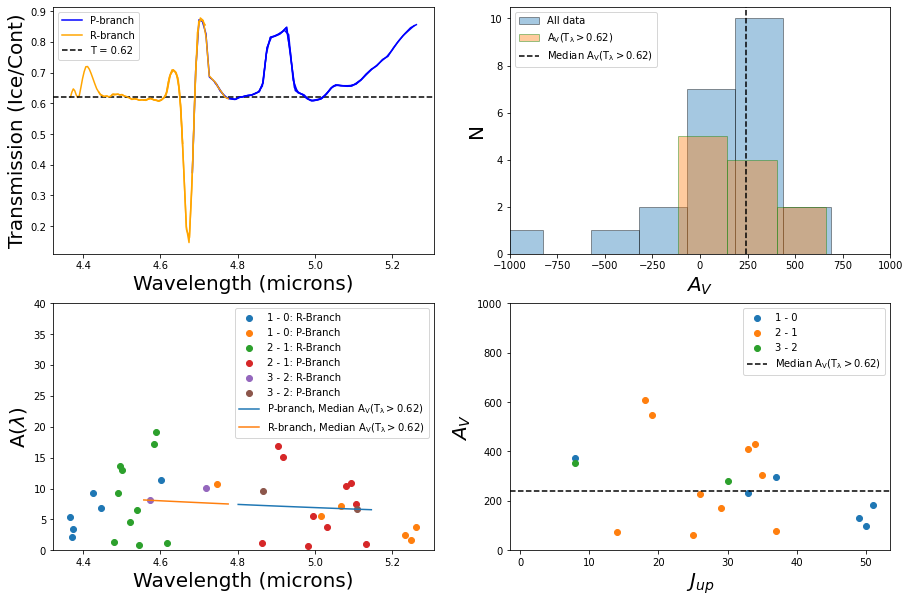

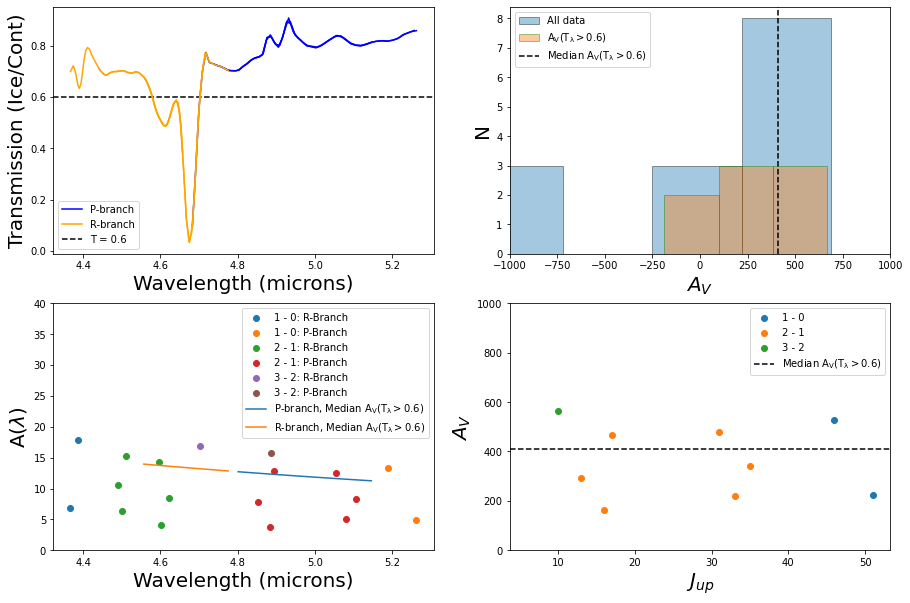

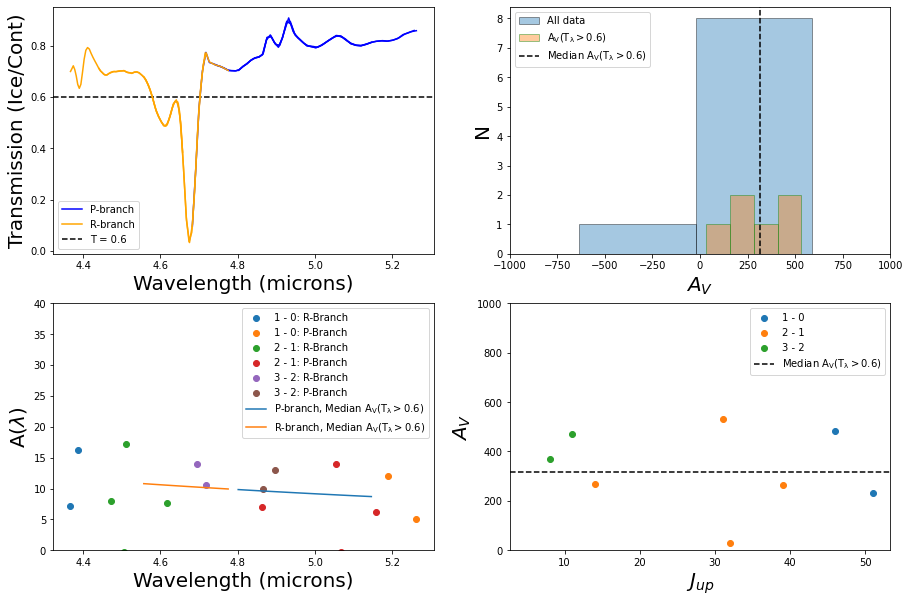

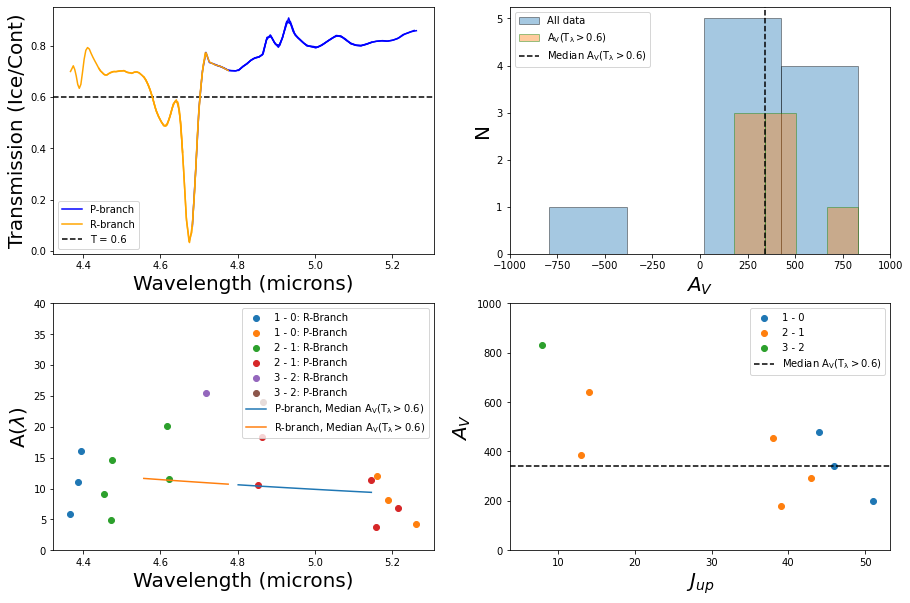

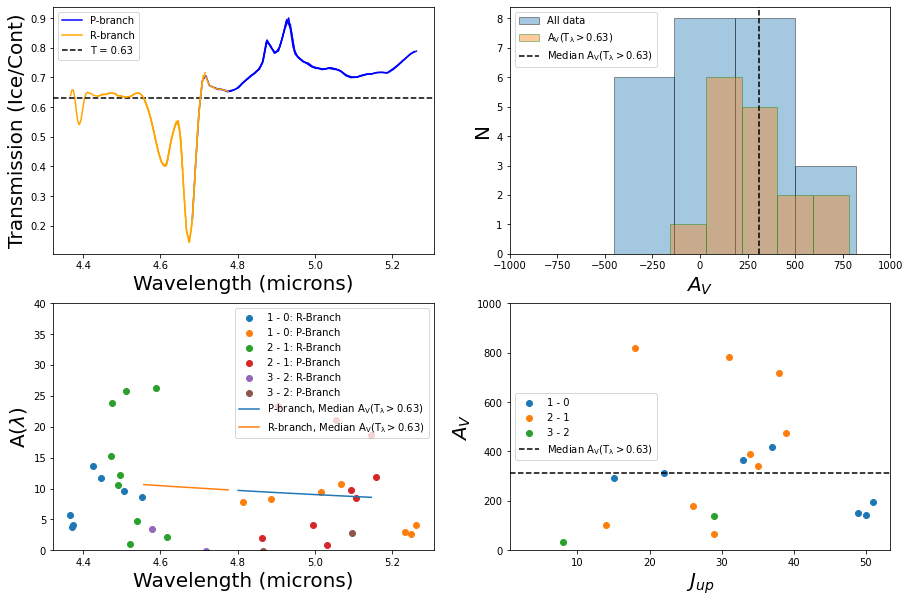

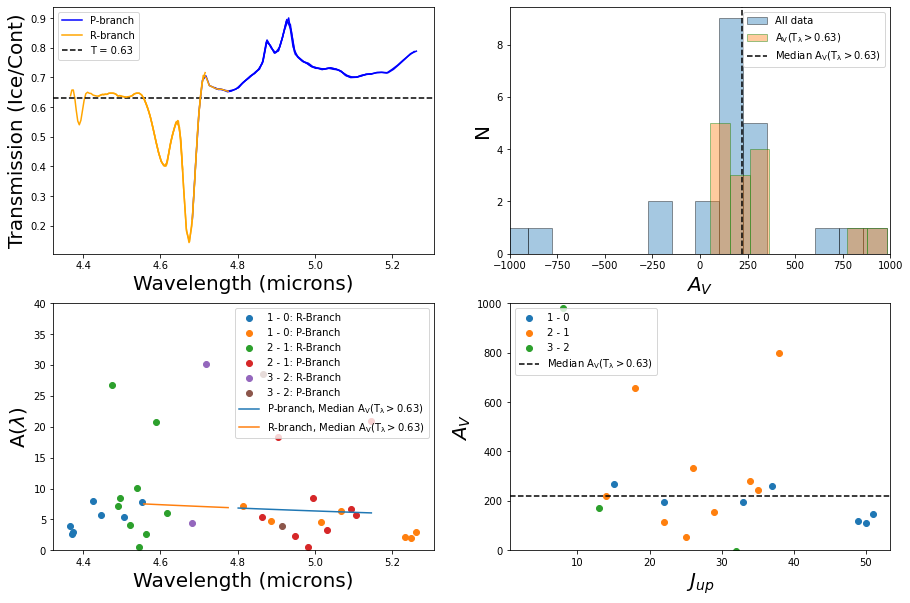

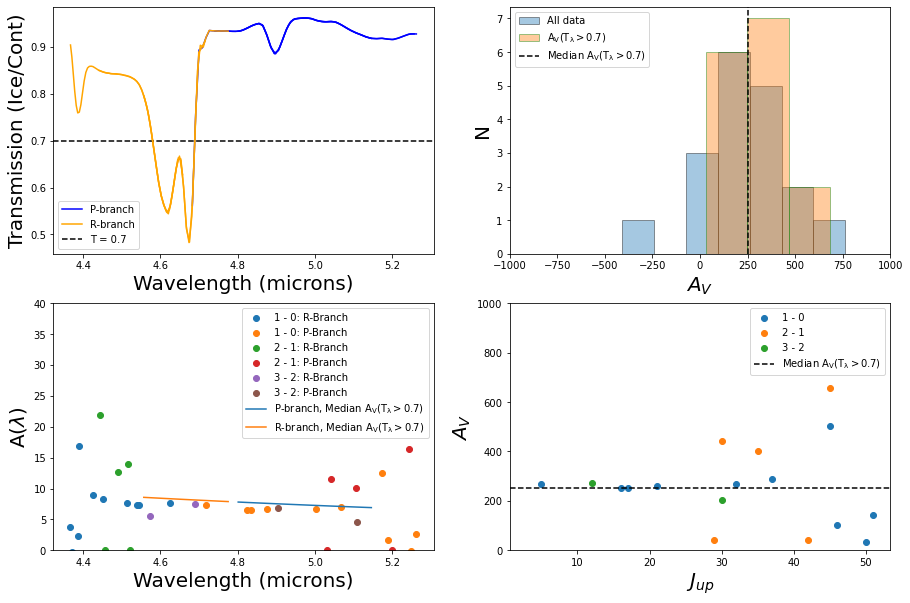

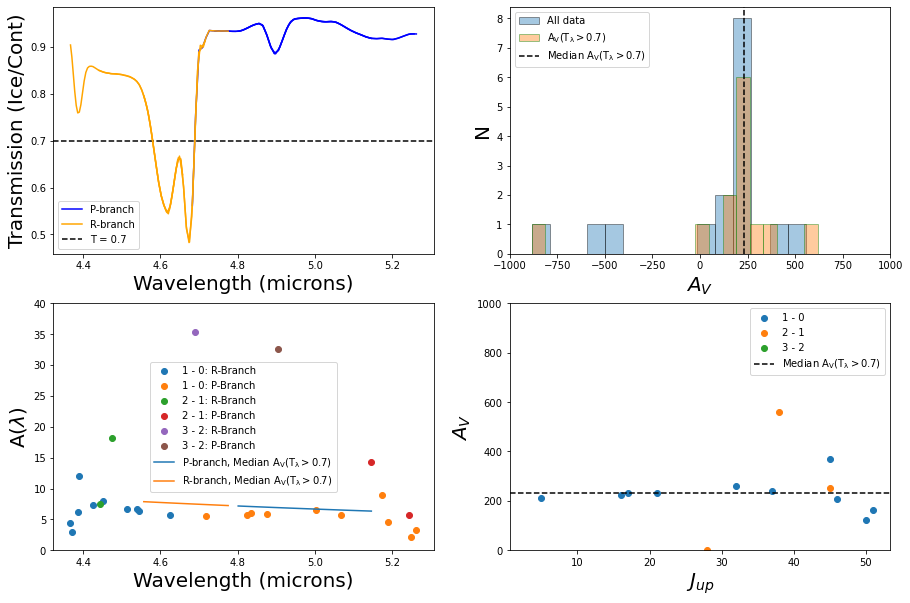

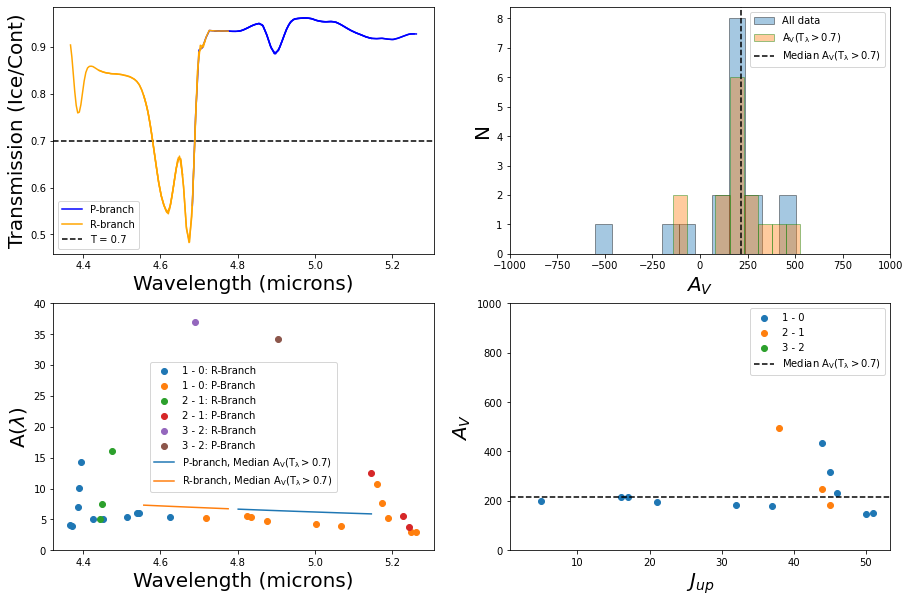

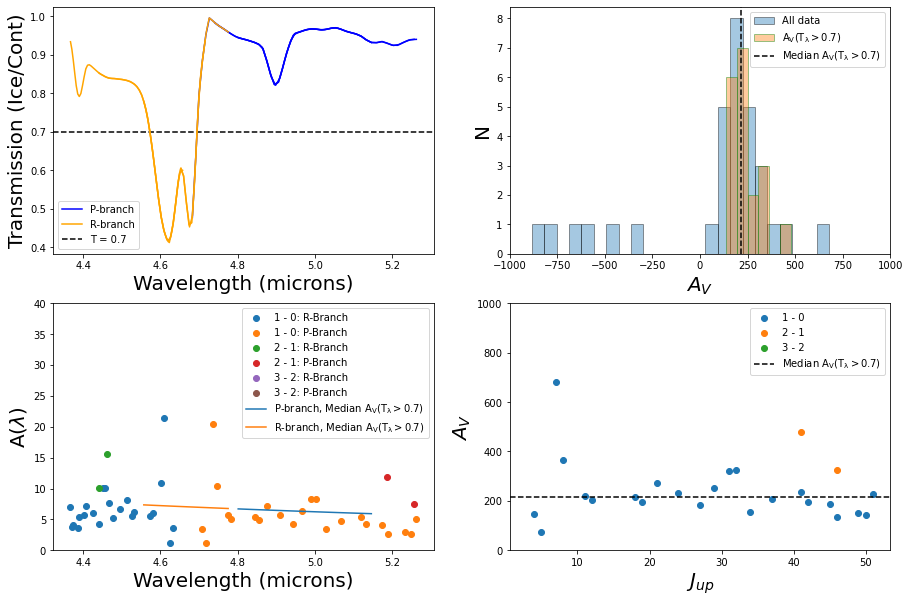

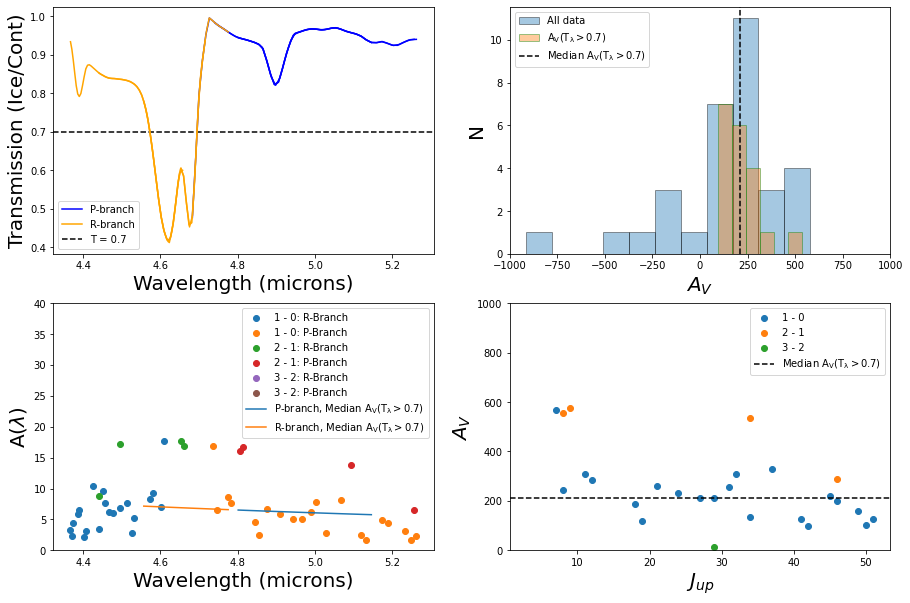

In [61]:
#input values, such as wavelength resolution for our lookup tables
wave_lookup_res = 0.000001
protostar_idx = 0 #for use in tests
avg_av_arr = [] #empty list needed to be filled for each protostar
avg_av_unc_arr = [] #empty list needed to be filled for each protostar
# transmiss_threshold_list = [[0.64], [0.69, 0.69, 0.69], [0.64, 0.64], [0.84, 0.84, 0.84], [0.84, 0.84]]
transmiss_threshold_list = [[0.62], [0.6, 0.6, 0.6], [0.63, 0.63], [0.7, 0.7, 0.7], [0.7, 0.7]]

#loop thorugh protostars and compute a table of fluxes:
for i in range(len(protostars)):
    for source_ind in range(len(central_sources_list[i])):
        count = 0
        av_arr = []
        av_masks = [] #empty list to be filled for each protostar

        #setup a figure
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
        ax[0,0].set_xlabel('Wavelength (microns)', fontsize=20)
        ax[0,0].set_ylabel('Transmission (Ice/Cont)', fontsize=20)
        ax[0,1].set_xlabel(r'$A_V$', fontsize=20)
        ax[0,1].set_ylabel('N', fontsize=20)
        ax[1,0].set_xlabel('Wavelength (microns)', fontsize=20)
        ax[1,0].set_ylabel(r'A($\lambda$)', fontsize=20)
        ax[1,1].set_xlabel(r'$J_{up}$', fontsize=20)
        ax[1,1].set_ylabel(r'$A_V$', fontsize=20)

        #loop through vibrational states (each axis)
        for j in range(len(v_list)):
            #loop through the rotational states to collect a set of data and usable values
            #doing it by hand here since will only ever be two options
            co_v_r_j, co_v_r_wavelengths, co_v_r_data, co_v_r_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[j], j_list[0])
            co_v_p_j, co_v_p_wavelengths, co_v_p_data, co_v_p_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[j], j_list[1])

            #making an average of these data, which is done here to check the exponent of the brightest lines
            # median_co_list = (np.nanmedian(co_v_r_data_corrected, axis=0) + np.nanmedian(co_v_p_data_corrected, axis=0))/2.0 #take median for a representative example for each star
            # sum_co_list = np.nansum(co_v_r_data_corrected, axis=0) + np.nansum(co_v_p_data_corrected, axis=0) #take median for a representative example for each star
            # exponent = int(np.floor(np.log10(np.mean(np.nan_to_num(median_co_list, posinf=0, neginf=0)[np.nan_to_num(sum_co_list, posinf=0, neginf=0) > 0])/10)))
        
            #filtering out low SNR data
            co_v_r_data_corrected, co_v_p_data_corrected = \
                data_filter(j, co_v_r_wavelengths, co_v_r_j, co_v_r_data_corrected, co_v_p_wavelengths, co_v_p_j, co_v_p_data_corrected)        

            #looping over different sources     
            #calling function to compute extinctions
            co_r_flux_list, co_p_flux_list, co_err_r_flux_list, co_err_p_flux_list = co_aperture_sums(i, source_ind, aper_shape_list[i], central_sources[i], aper_dims[i], rect_theta[i], \
                                                                                    co_v_r_data_corrected, co_v_p_data_corrected, co_v_r_wavelengths, co_v_p_wavelengths)  
            
            # #check indices based on which vibrational series of lines we're doing
            if j == 1 or j == 2: #for co v=2-1 AND v = 3-2
                #fix wavelengths and J
                co_v_r_sorted = np.array(co_v_r_j[3:][::-1])
                co_v_p_sorted = np.array(co_v_p_j[:-1][::-1])
                co_r_wave_sorted = np.array(co_v_r_wavelengths[3:][::-1])
                co_p_wave_sorted = np.array(co_v_p_wavelengths[:-1][::-1])
                co_r_flux_sorted = np.array(co_r_flux_list[3:][::-1])
                co_p_flux_sorted = np.array(co_p_flux_list[:-1][::-1])
                co_r_fluxerr_sorted = np.array(co_err_r_flux_list[3:][::-1])
                co_p_fluxerr_sorted = np.array(co_err_p_flux_list[:-1][::-1])

            elif j==0: #for j with v = 1-0...
                #fix wavelengths and J
                co_v_r_sorted = np.array(co_v_r_j[8:][::-1])
                co_v_p_sorted = np.array(co_v_p_j[:-1][::-1])
                co_r_wave_sorted = np.array(co_v_r_wavelengths[8:][::-1])
                co_p_wave_sorted = np.array(co_v_p_wavelengths[:-1][::-1])
                co_r_flux_sorted = np.array(co_r_flux_list[8:][::-1])
                co_p_flux_sorted = np.array(co_p_flux_list[:-1][::-1])
                co_r_fluxerr_sorted = np.array(co_err_r_flux_list[8:][::-1])
                co_p_fluxerr_sorted = np.array(co_err_p_flux_list[:-1][::-1])

            #some useful ratios and propagated the ratio of uncertainties for later too
            co_r_p_ratio_list = co_r_flux_sorted / co_p_flux_sorted #note if conversion done here
            co_err_r_p_ratio_list = co_r_p_ratio_list * np.sqrt( (co_r_fluxerr_sorted/co_r_flux_sorted)**2. + (co_p_fluxerr_sorted/co_p_flux_sorted)**2.) #note conversion done here

                
            #look up the co lab properties we need and split them into r and p branches for use in calculations
            #column_names[0] is 'Wv, microns', the first column of the co lab properties
            #wave_lookup_res is at the start of this code block and is about the minimum allowed
            #r-branch
            co_A_ij_r = [] #list of indices for use in looking up wavelengths and matching what we have to the lab properties
            for k in range(len(co_r_wave_sorted)):
                idx = (co_lab_props[column_names[0]] <= co_r_wave_sorted[k]+wave_lookup_res) & (co_lab_props[column_names[0]] > co_r_wave_sorted[k]-wave_lookup_res)
                co_A_ij_r.append(co_lab_props[column_names[1]][idx].values[0]) #apply indices to and lookup in table of lab properties
            co_A_ij_r = np.array(co_A_ij_r)

            #p-branch
            co_A_ij_p = [] #list of indices for use in looking up wavelengths and matching what we have to the lab properties
            for k in range(len(co_p_wave_sorted)):
                idx = (co_lab_props[column_names[0]] <= co_p_wave_sorted[k]+wave_lookup_res) & (co_lab_props[column_names[0]] > co_p_wave_sorted[k]-wave_lookup_res)
                co_A_ij_p.append(co_lab_props[column_names[1]][idx].values[0]) #apply indices to and lookup in table of lab properties
            co_A_ij_p = np.array(co_A_ij_p)

            #determine extinction here!
            co_av_list, co_av_err_list, tau_r_ext_list, tau_p_ext_list, tau_r_err_list, tau_p_err_list = extinc(co_r_wave_sorted, co_p_wave_sorted, co_r_p_ratio_list, co_err_r_p_ratio_list, co_A_ij_r, co_A_ij_p)
            av_arr.append(co_av_list)

            #now to make some example plots; we will pick one for later
            ### TRANSMISSION CURVE
            #for each protostar, we can now define an averaged transmission function in order to threshold our extinction values
            #must be done once for each vibrational state as well
            transmiss_p_sorted = np.array([np.nanmedian(transmit_splined(k)) for k in co_p_wave_sorted])
            transmiss_r_sorted = np.array([np.nanmedian(transmit_splined(k)) for k in co_r_wave_sorted])
            ax[0,0].plot(co_p_wave_sorted, transmiss_p_sorted, label='P-branch', color='blue')
            ax[0,0].plot(co_r_wave_sorted, transmiss_r_sorted, label='R-branch', color='orange')
            if j == 0:
                ax[0,0].axhline(transmiss_threshold_list[i][source_ind], linestyle='--', color='black', label='T = ' + str(transmiss_threshold_list[i][source_ind]))
                ax[0,0].legend()

            ### AV vs JUP
            #next, make a polynomial (smooth) fit to the thresholded data and see how it compares to the thresholded data and then the original data
            # poly_deg = 2
            # polyfit_coeffs = [np.polyfit(np.array(range(1, len(co_p_j[1:])+1)), co_av_thresholded[i], deg=poly_deg) for i in range(len(co_av_list))]
            # polyfit_equs = [np.poly1d(i) for i in polyfit_coeffs]
            #plot to check everything together
            ax[1,1].scatter(np.array(range(1, len(co_v_p_sorted)+1)), co_av_list, label=str(v_list[j][0]) + ' - ' + str(j), marker='o') #should label the very large or negative values as irrelevant...
            # ax[1,1].axhline(avg_av_filtered, color='k', linestyle='--', label=str(v_list[j][0]) + ' - ' + str(j) + ': ' + r'$\rm A_V(T_{\lambda} > $' + str(transmiss_threshold_list[i][source_ind]) + ')')
            ### Av VS JUP FIT
            # ax[1,1].plot(np.array(range(1, len(co_v_p_sorted[1:])+1)), polyfit_equs[i](np.array(range(1, len(co_v_p_sorted[1:])+1))), label=str(v_list[j][0]) + ' - ' + str(j))
            #apply polynomial fit to tau liek we did with Av
            # poly_deg = 2
            # tau_r_polyfit_coeffs = [np.polyfit(np.array(range(1, len(co_p_j[1:])+1)), tau_r_ext_thresh[i], deg=poly_deg) for i in range(len(tau_r_ext_thresh))]
            # tau_r_polyfit_equs = [np.poly1d(i) for i in tau_r_polyfit_coeffs]
            # tau_r_fit = [tau_r_polyfit_equs[i](np.array(range(1, len(co_p_j[1:])+1))) for i in range(len(tau_r_polyfit_equs))]
            # tau_p_polyfit_coeffs = [np.polyfit(np.array(range(1, len(co_p_j[1:])+1)), tau_p_ext_thresh[i], deg=poly_deg) for i in range(len(tau_p_ext_thresh))]
            # tau_p_polyfit_equs = [np.poly1d(i) for i in tau_p_polyfit_coeffs]
            # tau_p_fit = [tau_p_polyfit_equs[i](np.array(range(1, len(co_p_j[1:])+1))) for i in range(len(tau_p_polyfit_equs))]
            # if j == len(v_list)-1:
                # ax[1,1].xticks(np.arange(5, 51, 5))
                # ax[1,1].yscale('log')
                # ax[1,1].axhline(0)


            ### ALAM vs LAM
            #checking plot of reddening as function of wavelength
            C_ext_co = vs(co_r_wave_sorted) - vs(co_p_wave_sorted)
            r_to_p_0 = co_A_ij_r/co_A_ij_p * co_r_wave_sorted/co_p_wave_sorted
            co_red_list = 2.5 * np.log10(r_to_p_0 / co_r_p_ratio_list)
            A_lambda_r = vs(co_r_wave_sorted)/C_ext_co * co_red_list
            A_lambda_p = vs(co_p_wave_sorted)/C_ext_co * co_red_list
            ax[1,0].scatter(co_r_wave_sorted, A_lambda_r, label=str(v_list[j][0]) + ' - ' + str(j) + ': R-Branch')
            ax[1,0].scatter(co_p_wave_sorted, A_lambda_p, label=str(v_list[j][0]) + ' - ' + str(j) + ': P-Branch')
            # ax[1,0].plot(co_r_wave_sorted, vs(co_r_wave_sorted)/C_ext_co, label=str(v_list[j][0]) + ' - ' + str(j) + ': R-Branch, C_Ext Ratio')
            # ax[1,0].plot(co_p_wave_sorted, vs(co_p_wave_sorted)/C_ext_co, label=str(v_list[j][0]) + ' - ' + str(j) + ': P-Branch, C_Ext Ratio')
            # if j == len(v_list)-1:
                # ax[1,0].tick_params(axis='x', which='major', length=10, labelsize=20)
                # ax[1,0].tick_params(axis='y', which='major', length=10, labelsize=20)
                # ax[1,0].tick_params(axis='x', which='minor', length=5)
                # ax[1,0].tick_params(axis='y', which='minor', length=5)


            ### AV HISTOGRAM + TESTING TRANSMISSION PERCENTAGE THRESHOLD
            #need to filter out a given set of vibrational data here
            for k1,k2 in zip(transmiss_r_sorted, transmiss_p_sorted):
                if k1 > transmiss_threshold_list[i][source_ind] and k2 > transmiss_threshold_list[i][source_ind]:
                    # print(k1, k2, co_av_list[count])
                    av_masks.append(count)
                count += 1
        av_arr = np.concatenate(av_arr)
        av_masks = np.array(av_masks)
        # print(av_masks)
        # print(av_arr[av_masks])    
        av_pos_masked = av_arr[av_masks]
        av_pos_masked[av_pos_masked < 0] = np.nan
        av_pos_masked[av_pos_masked > 1000] = np.nan
        avg_av_filtered = np.nanmedian(av_pos_masked)
        avg_av_arr.append(avg_av_filtered)
        avg_av_unc_arr.append(np.nanstd(av_pos_masked, ddof=1)/np.sqrt(len(av_pos_masked)))
        print(protostars[i], 'Source: ', source_ind)
        print('Uncertainties: ', co_av_err_list)
        print('Removed Outliers: ', avg_av_filtered, 'High Transmission, still outliers: ', np.nanmedian(av_arr[av_masks]))
        print('StD of high transmission + outliers removed: ', np.nanstd(av_pos_masked, ddof=1)/np.sqrt(len(av_pos_masked)))
        # av_arr = av_arr[av_arr > 0]
        _ = ax[0,1].hist(av_arr, bins='auto', edgecolor='k', alpha=0.4, label='All data')  # arguments are passed to np.histogram, note auto bins?
        _ = ax[0,1].hist(av_arr[av_masks], bins='auto', edgecolor='g', alpha=0.4, label=r'$\rm A_V(T_{\lambda} > $' + str(transmiss_threshold_list[i][source_ind]) + ')')  # arguments are passed to np.histogram, note auto bins?
        ax[0,1].axvline(avg_av_filtered, color='k', linestyle='--', label=r'$\rm Median \ A_V(T_{\lambda} > $' + str(transmiss_threshold_list[i][source_ind]) + ')')
        ax[1,1].axhline(avg_av_filtered, color='k', linestyle='--', label=r'$\rm Median \ A_V(T_{\lambda} > $' + str(transmiss_threshold_list[i][source_ind]) + ')') #plot on another plot...
        ax[1,0].plot(co_p_wave_sorted, avg_av_filtered * vs(co_p_wave_sorted)/vs(lambdaV), label=r'P-branch, $\rm Median \ A_V(T_{\lambda} > $' + str(transmiss_threshold_list[i][source_ind]) + ')' )
        ax[1,0].plot(co_r_wave_sorted, avg_av_filtered * vs(co_r_wave_sorted)/vs(lambdaV), label=r'R-branch, $\rm Median \ A_V(T_{\lambda} > $' + str(transmiss_threshold_list[i][source_ind]) + ')' )
        if j == len(v_list)-1:
            ax[0,1].set_xlim(-1000,1000)
            ax[0,1].legend()
            ax[1,0].set_ylim(0,40)
            ax[1,0].legend(loc='best')
            ax[1,1].set_ylim(0,1000) #,35)
            ax[1,1].legend(loc='best')


In [62]:
#alternative methods involving outliers and basic stats

# #need to now make a case of where we pass the first threshold...testing for positivity (physically impossible to be negative)
# passed_threshold_pos = [co_av_list[i] > 0 for i in range(len(co_av_list))]

# #next threshold is if the mean (now forced to be positive) is exceeded by N * sigma (if the error >> the measurement, may not be realistic)
# n_maxerr = 3
# passed_threshold_maxerr = [n_maxerr*co_av_err_list[i] < co_av_list[i] for i in range(len(co_av_list))]

# #last check is if the value is within +/-3 x the mean to address the (physically possible) other outliers (most stringent, needs more carefulness and the previous masks first for an accurate mean)
# n_sig = [100, 3, 3, 100, 100]
# co_mean_av_presig = [np.nanmean(co_av_list[i][np.logical_and(passed_threshold_pos[i], passed_threshold_maxerr[i])]) for i in range(len(co_av_list))]
# passed_threshold_outlier = [co_av_list[i] < np.abs(co_mean_av_presig[i] + n_sig[i]*co_av_err_list[i]) for i in range(len(co_av_list))]

# #applying all masks at once!
# passed_threshold_all = [np.logical_and(passed_threshold_outlier[i], np.logical_and(passed_threshold_pos[i], passed_threshold_maxerr[i])) for i in range(len(co_av_list))]
# co_av_thresholded = [co_av_list[i][passed_threshold_all[i]] for i in range(len(co_av_list))]
# co_av_err_thresholded = [co_av_err_list[i][passed_threshold_all[i]] for i in range(len(co_av_err_list))]

# #now recompute mean properties excluding outliers
# co_mean_av_list = [np.nanmean(i) for i in co_av_thresholded]
# co_mean_av_err_list = np.array([np.nanstd(i, ddof=1)/np.sqrt(len(i)) for i in co_av_err_thresholded]) #applying "standard error" or uncertainty in the mean, see for example https://physics.stackexchange.com/questions/664159/what-is-the-correct-way-of-determining-uncertainty-of-an-average-value-from-mu or https://stats.stackexchange.com/questions/454120/how-can-i-calculate-uncertainty-of-the-mean-of-a-set-of-samples-with-different-u
# co_av_dist_err_list = np.array([np.nanstd(i, ddof=1)/np.sqrt(len(i)) for i in co_av_thresholded]) #applying "standard error" or uncertainty in the mean, see for example https://physics.stackexchange.com/questions/664159/what-is-the-correct-way-of-determining-uncertainty-of-an-average-value-from-mu or https://stats.stackexchange.com/questions/454120/how-can-i-calculate-uncertainty-of-the-mean-of-a-set-of-samples-with-different-u

# print(co_mean_av_list)
# print(3.*co_mean_av_err_list)
# print(3. * co_av_dist_err_list)


# #now looping through and thresholding everything appropriately
# tau_r_ext_thresh = [tau_r_ext_list[i][passed_threshold_all[i]] for i in range(len(tau_r_ext_list))]
# tau_p_ext_thresh = [tau_p_ext_list[i][passed_threshold_all[i]] for i in range(len(tau_p_ext_list))]
# tau_r_err_thresh = [tau_r_err_list[i][passed_threshold_all[i]] for i in range(len(tau_r_err_list))]
# tau_p_err_thresh = [tau_p_err_list[i][passed_threshold_all[i]] for i in range(len(tau_p_err_list))]

# #compute some average properties for this tau
# tau_mean_r_list = [np.nanmean(i) for i in tau_r_ext_thresh]
# tau_mean_p_list = [np.nanmean(i) for i in tau_p_ext_thresh]
# tau_mean_list = [np.nanmean(np.concatenate((i,j))) for i,j in zip(tau_r_ext_thresh, tau_p_ext_thresh)]
# tau_mean_err_list = np.array([np.nanstd(np.concatenate((i,j)), ddof=1)/np.sqrt(len(np.concatenate((i,j)))) for i,j in zip(tau_r_err_list, tau_p_err_list)]) #applying "standard error" or uncertainty in the mean, see for example https://physics.stackexchange.com/questions/664159/what-is-the-correct-way-of-determining-uncertainty-of-an-average-value-from-mu or https://stats.stackexchange.com/questions/454120/how-can-i-calculate-uncertainty-of-the-mean-of-a-set-of-samples-with-different-u
# #please note this is taking the stdev, which is the sample standard dev or variance, with ddof=1 to remove bias (but ignoring cov, correlated error). 
# # the error on the mean (standardly) is sigma/sqrt(n)

# print(tau_mean_list)
# print(3.*tau_mean_err_list)

# Develop functions for rotation or CO population diagrams

In [63]:
#a full worked example with a rotation diagram choosing linear fits by hand

#next, we make rotation diagrams! first grab some constants
#see for example https://iopscience.iop.org/article/10.1088/0004-637X/770/2/123/pdf by Joel (appendix)
#can also see David Neufeld's work (https://iopscience.iop.org/article/10.1088/0004-637X/749/2/125/pdf) or Goldsmith99
#for an option with temperature and density gradients, see https://arxiv.org/pdf/2301.13135.pdf
# jy_to_cgs = 1e-23 #not we're not worrying about mega here b/c we converted that earlier
#but flux conversions were in units of fwhm/lambda^2, which is micron/micron^2 or 1/micron...to cgs! means * 1/1e4
#ignore these conversions, already built in now
pc_to_cm = 3.086e18
dist_list = pc_to_cm*np.array([150, 165, 390, 390, 1.55e3]) #pc: from Ortiz-Leon 2018, Watson 2020, Tobin+2020a, Tobin+2020a, Reid+2019
# au_to_cm = 1.496e13 # au to cm...
# aperture_area_cm = np.pi * (0.5 * dist_list/pc_to_cm * au_to_cm)**2.0 #arcsec * pc = au, so if we go back to pc, multiply by our arcsec aperture length scale 0.5 we can get area...
h_cgs = 6.626e-27 #erg/sec
c_cgs = 3e10 #cm/s
hc_cgs = h_cgs * c_cgs

''' 
here need to check some math for the right hand side of this equation...
NJ/gJ = N/Q * exp(-Eu/Trot)
so log of LHS = log(NJ/gJ)
log of RHS is log(N) + log(Q) + log(exp(-Eu/Trot)) = log(N) + log(Q) + (-Eu/Trot)
Here, Q = approx kbT / (hcB). in equilib, T = Trot...not always correct!

anyway, we can see which has very large deviations so...
log(Q) = log(kbTrot/hcB) = log(kb/(hcB))+log(Trot)
so overall we get log(N) + log(kb/(hcB)) + log(Trot) + (-Eu/Trot)
notice that if you have -x/T+log(T), then log(T) will be relatively small...you can tell this by plotting, for example, y=log(x) and y=x...it could hypothetically change log(N), but if log(N)>>log(T)...
in fact, if you compute the partition function regardless of temperature, you'll find it's quite small: https://www.wolframalpha.com/input?i=log%281.4e-16+erg%2FK+%2F+6.626e27+erg*sec+%2F+3e14+cm%2Fs+%2F+%28192.25%2F100*cm%5E-1%29%29
~on the order of 1E-59...do need to check that and actually add it in, remember logs!, but we have now!
https://www.wolframalpha.com/input?i=2+*+1.4e-16+%2F+%286.626e-27+*+3e10+*+1.9225%29
https://www.wolframalpha.com/input?i=6.626e-27+erg*sec+*+3e10+cm%2Fs+%2F+1.4e-16+erg%2FK

so to simplify, then log of RHS ~= log(N) - Eu/Trot...now just plot vs. Eu!
'''
#rotational constants
k_B_cgs = 1.4e-16 #erg/K
Z_J_const = 2. * k_B_cgs / hc_cgs / 1.9225 # 3.663e-1 # in K, or logged???: -127.646482723869880985840966; 1.9225 is in cm^-1

#next, make some linear fits
#taken from https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
from scipy import optimize
# def Trot_fitter(Eu, Ntot, slopeT):
#     return np.log(Ntot) + -1.*Eu/slopeT - np.log(Z_J_const*slopeT) #- -1.*d_i*np.log(1.0 - np.exp(-Z_v_const/slopeT))
# def linear_fitter(Eu, b, m):
#     return -1. * m * Eu + b #- -1.*d_i*np.log(1.0 - np.exp(-Z_v_const/slopeT))

#a brute force search https://stackoverflow.com/questions/46218934/piecewise-linear-fit-with-n-breakpoints
npoly = np.polynomial.polynomial
#alternatives #taken from https://stackoverflow.com/questions/19955686/fit-a-curve-for-data-made-up-of-two-distinct-regimes
#or https://stackoverflow.com/questions/41641880/using-scipy-curve-fit-with-piecewise-function
#some imports and styles related to plotting lines
# from scipy.optimize import brute
# num_breakpoints = [2, 1, 1]
# linestyle_list = ['-', '--', ':', '-.']
# color_list = ['red', 'green', 'blue']
# marker_list = ['o', 'D', '^']

#https://stackoverflow.com/questions/29382903/how-to-apply-piecewise-linear-fit-in-python
#https://gist.github.com/ruoyu0088/70effade57483355bbd18b31dc370f2a
def segments_fit(X, Y, count):
    xmin = X.min()
    xmax = X.max()

    seg = np.full(count - 1, (xmax - xmin) / count)

    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2)**2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')
    return func(r.x)

#if you would like a latex formatting of numbers to scientific notation (mostly for major plots)
#from https://stackoverflow.com/questions/13490292/format-number-using-latex-notation-in-python
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str

### Combine histograms and rotation diagrams into a figure for all protostars

Also note and store any values from fitting

97.8072892729748


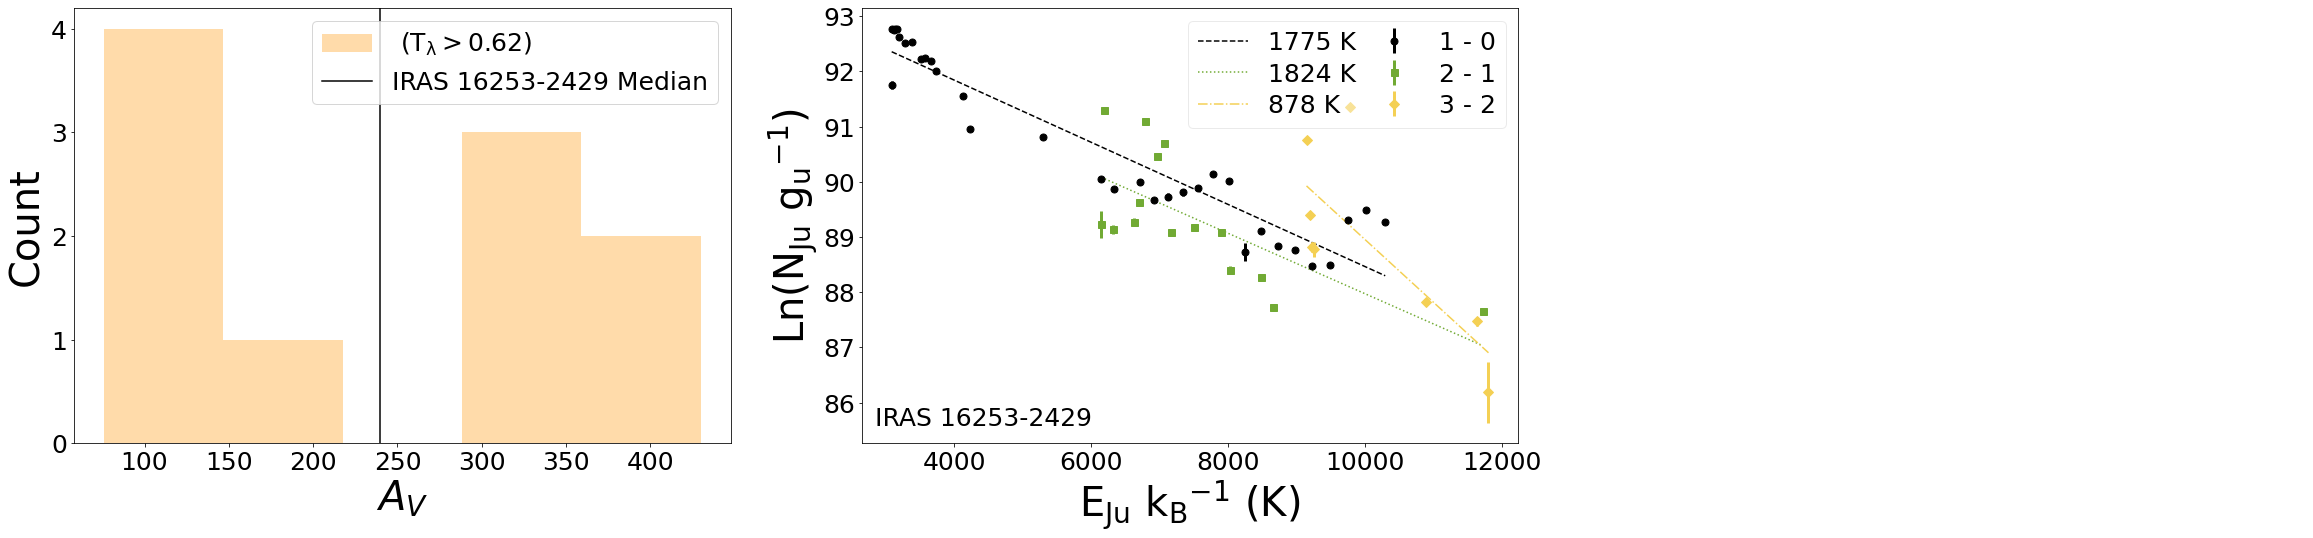

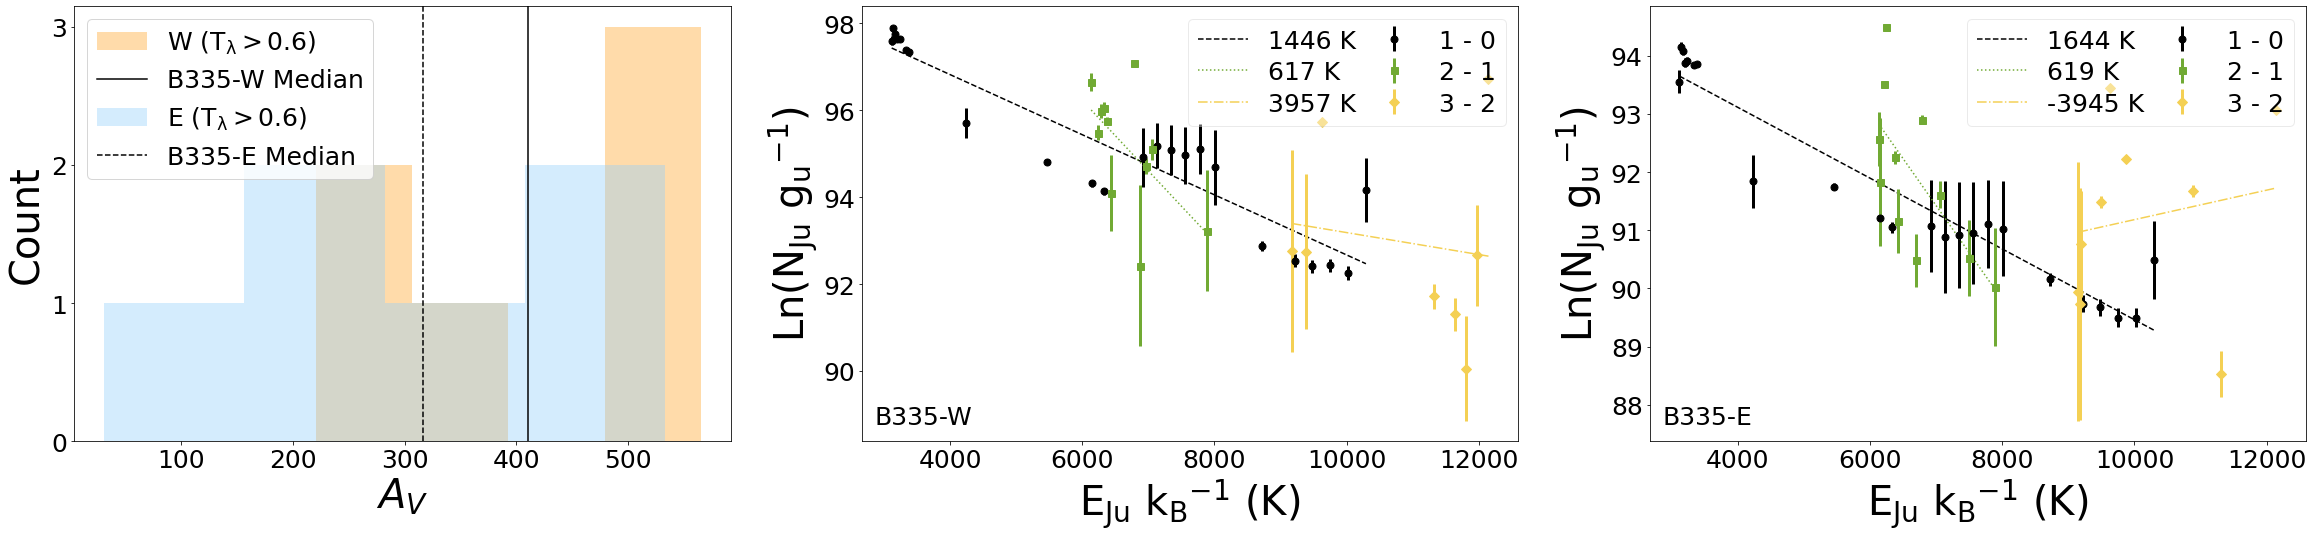

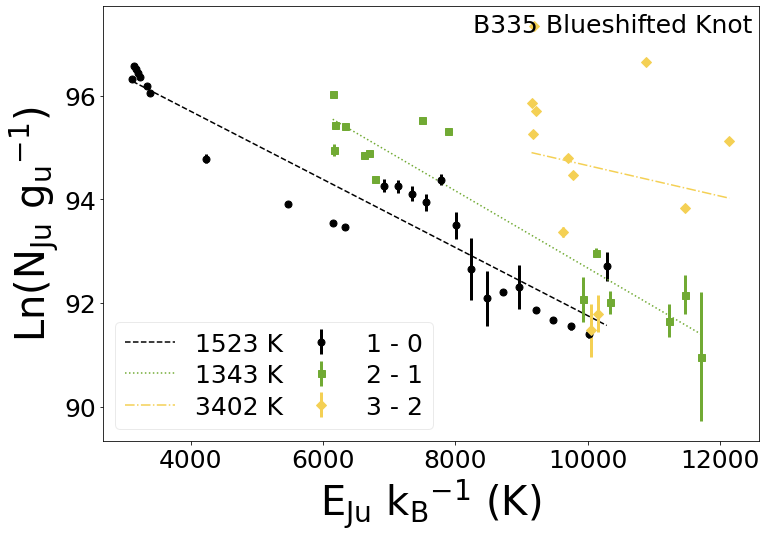

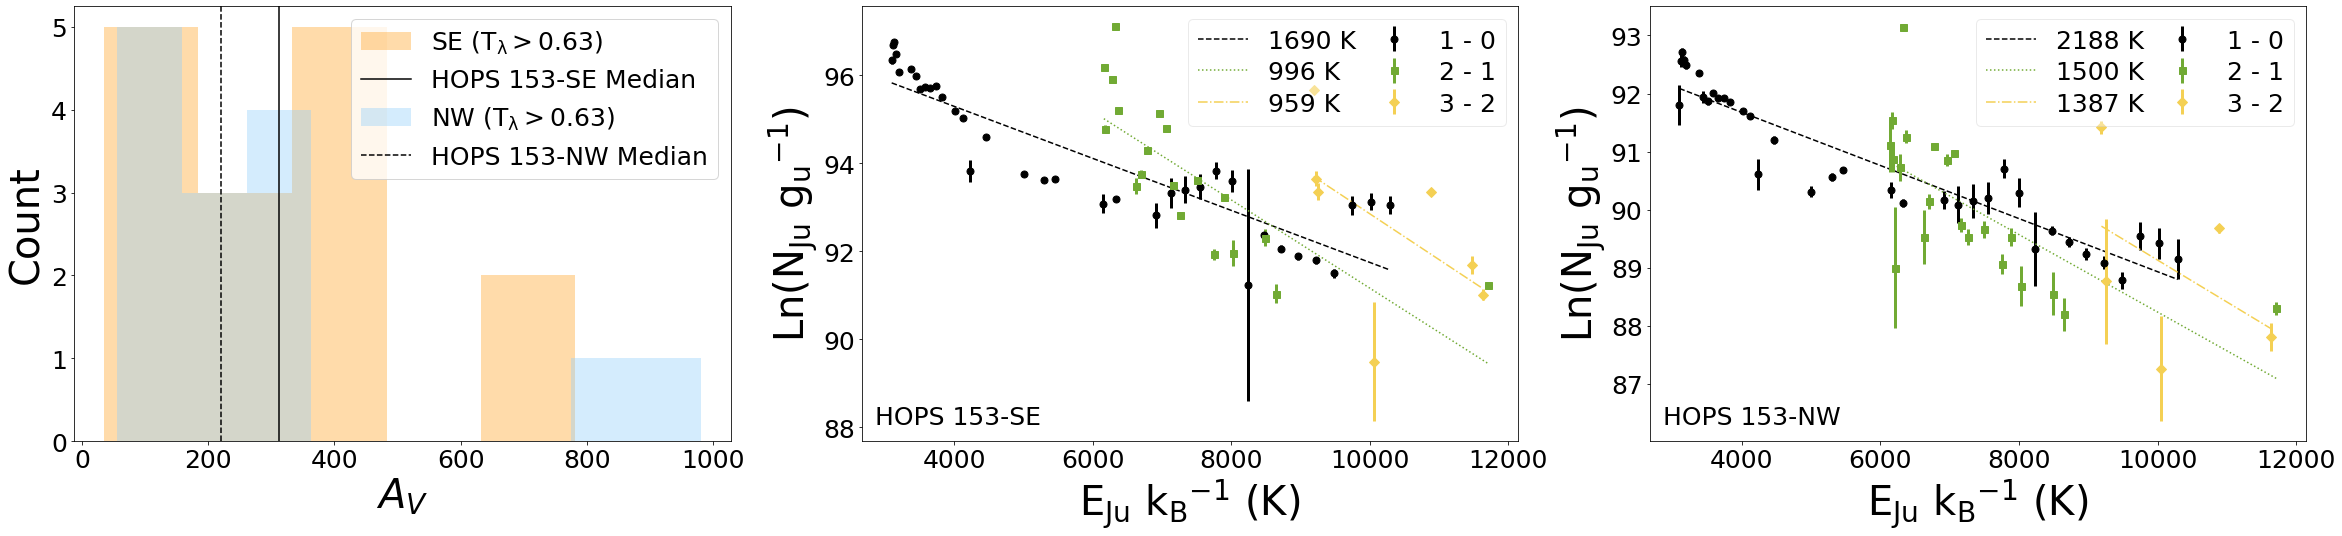

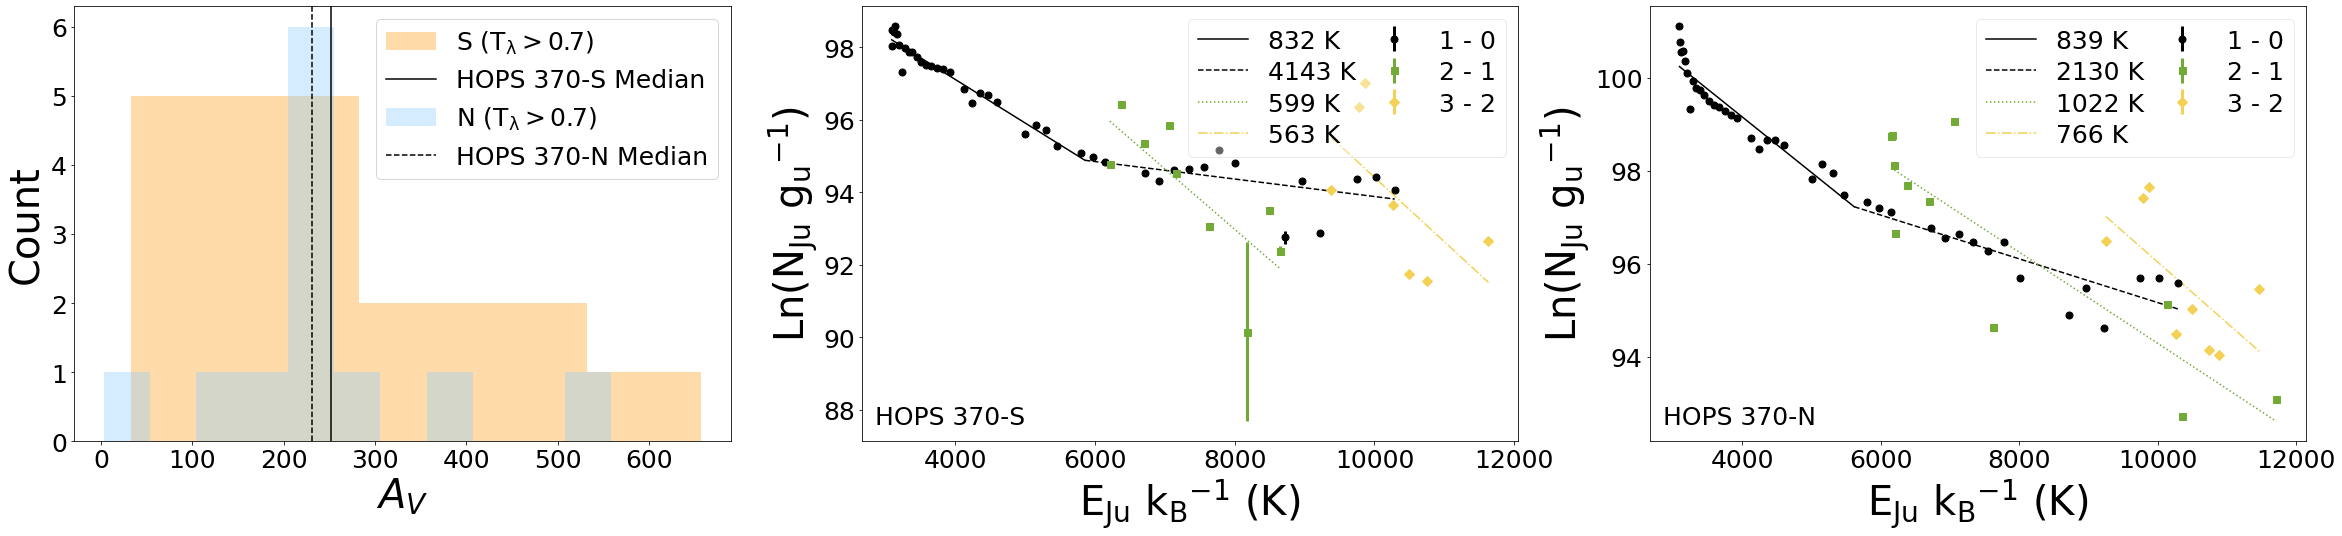

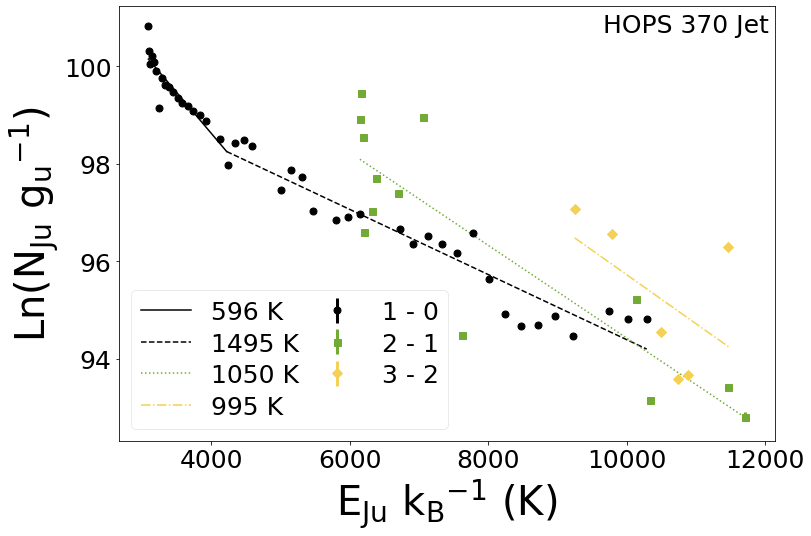

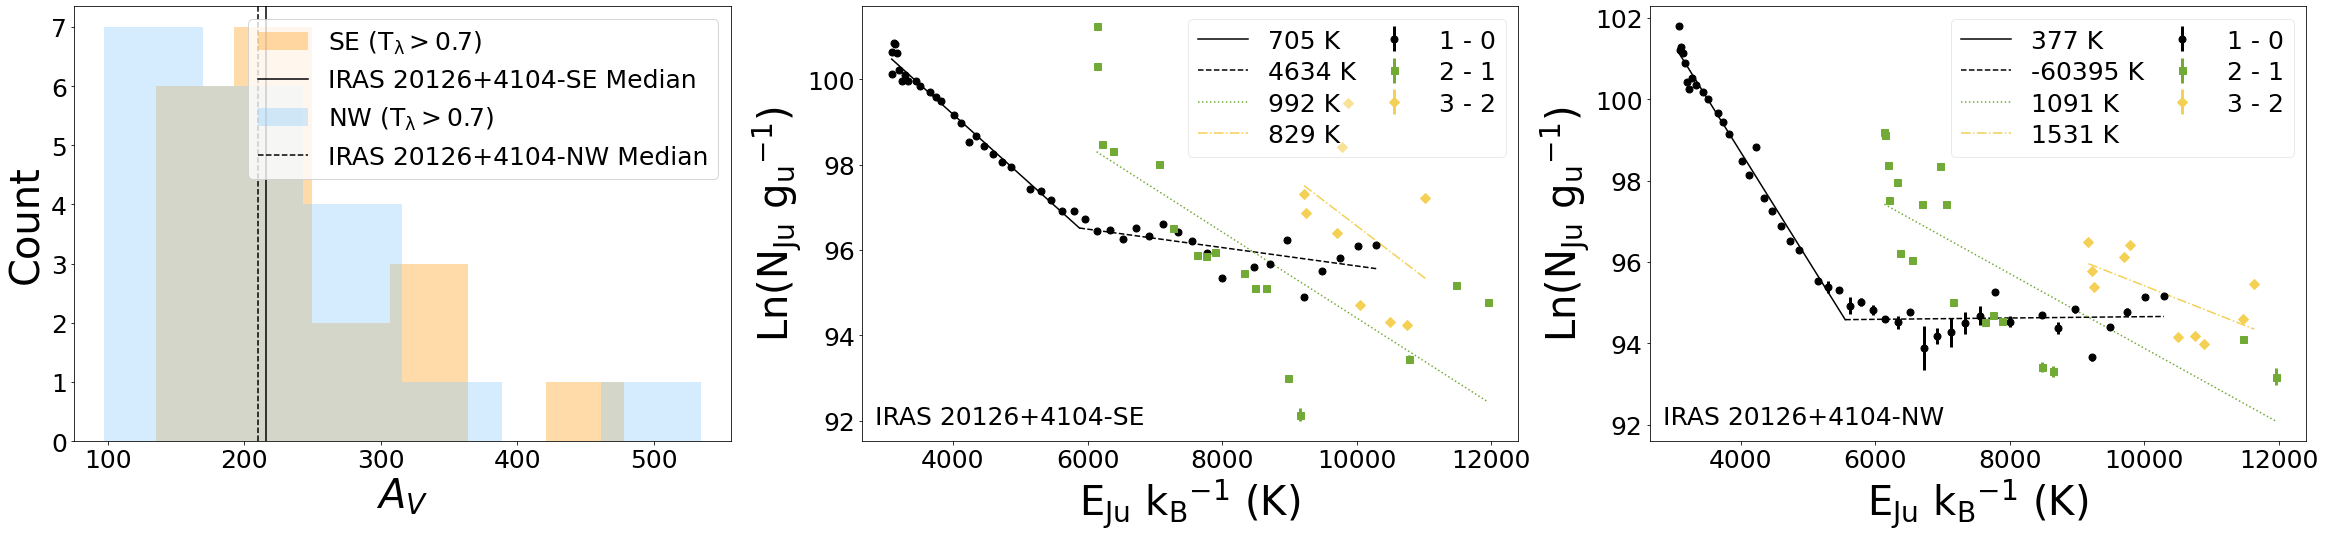

In [64]:
# plot figures of everything...more complicated so done here instead of separate panels as...
# horizontally: extinction plot (histogram or spectrum), rotation diagram
# vertically: each source...

#need to filter out runtimewarnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#input values, such as wavelength resolution for our lookup tables
#rectangular patch as aperture over each source
nbins_list = [2, 5, 5, 5, 5]
av_colors = ['xkcd:mango', 'xkcd:light blue']
# av_legend_locs = ['upper right', 'upper left', 'upper left', 'upper left', 'upper right']
wave_lookup_res = 0.000001
protostar_idx = 0 #for use in tests
# avg_av_arr = [] #empty list needed to be filled for each protostar
avg_av_arr_reshaped = [[avg_av_arr[0]], [avg_av_arr[1], avg_av_arr[2]], [avg_av_arr[4], avg_av_arr[5]], \
                       [avg_av_arr[6], avg_av_arr[7]], [avg_av_arr[9], avg_av_arr[10]]]
T_saved = []
N_intercept_saved = []
log_NJ_gJ_saved = []

#relating to rotaiton diagrams
# T_bound_low = [3.3e3, 3.3e3, 3.5e3, 3.3e3, 3.3e3]
linestyle_list = ['-', '--', ':'] #, '-.']
color_list = ['k', 'xkcd:leaf'] #, 'xkcd:maize']
marker_list = ['o', 's'] #, 'D']
source_id_list = ['', ['-W', '-E'], ['-SE', '-NW'], ['-S', '-N'], ['-SE', '-NW']]

#loop over each protostar
fig_path = 'CentralSource_CO/'
for i in range(len(protostars)):
    fig = plt.figure(figsize=(40, 8)) #setup a figure

    if i < 3:
        num_breakpoints = [1, 1]
    else: 
        num_breakpoints = [2, 1]


    if i > 0:
        #extinctions
        ax_extinction = fig.add_subplot(131)
        ax_extinction.set_xlabel(r'$A_V$', fontsize=40)     #if histogram of Av do
        ax_extinction.set_ylabel('Count', fontsize=40)
        ax_extinction.tick_params(axis='both', which='major', labelsize=25)  
        # ax_extinction.set_xlim(0,750)

        #rotation diagrams
        ax_rotation1 = fig.add_subplot(132)
        ax_rotation2 = fig.add_subplot(133)
        ax_rotation_list = [ax_rotation1, ax_rotation2] 

    if i == 0:
        #extinctions
        ax_extinction = fig.add_subplot(131)
        ax_extinction.set_xlabel(r'$A_V$', fontsize=40)     #if histogram of Av do
        ax_extinction.set_ylabel('Count', fontsize=40)
        ax_extinction.tick_params(axis='both', which='major', labelsize=25)  
        # ax_extinction.set_xlim(0,750)

        #rotation diagrams
        ax_rotation1 = fig.add_subplot(132)
        ax_rotation2 = fig.add_subplot(133)
        ax_rotation2.axis('off') #just show white space to give plots even spacing and size)
        ax_rotation_list = [ax_rotation1]  

    for source_ind in range(len(central_sources_list[i])):
        if source_ind < 2:
            ax_rotation = ax_rotation_list[source_ind] 

        elif source_ind == 2:
            fig.savefig(fig_path + 'CO_analysis_' + protostars[i] + '.pdf', bbox_inches='tight')

            fig = plt.figure(figsize=(40, 8)) #setup a figure
            ax_rotation = fig.add_subplot(131)

        count = 0
        av_arr = []
        av_masks = [] #empty list to be filled for each protostar

        ax_rotation.set_xlabel(r'$\rm E_{Ju} \ {k_B}^{-1} \ (K)$', fontsize=40) # (E_{Ju} - E_{Ju=0})
        ax_rotation.set_ylabel(r'$\rm Ln(N_{Ju} \ {g_u}^{-1})$', fontsize=40)
        ax_rotation.tick_params(axis='both', which='major', labelsize=25)
        # if i == 1:
        #     ax_rotation.set_ylim(80, 100)

        #loop through vibrational states (each axis)
        for j in range(len(v_list)):
            #loop through the rotational states to collect a set of data and usable values
            #doing it by hand here since will only ever be two options
            co_v_r_j, co_v_r_wavelengths, co_v_r_data, co_v_r_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[j], j_list[0])
            co_v_p_j, co_v_p_wavelengths, co_v_p_data, co_v_p_data_corrected, co_header, transmit_splined = co_data_output(protostars[i], v_list[j], j_list[1])

            #making an average of these data, which is done here to check the exponent of the brightest lines
            # median_co_list = (np.nanmedian(co_v_r_data_corrected, axis=0) + np.nanmedian(co_v_p_data_corrected, axis=0))/2.0 #take median for a representative example for each star
            # sum_co_list = np.nansum(co_v_r_data_corrected, axis=0) + np.nansum(co_v_p_data_corrected, axis=0) #take median for a representative example for each star
            # exponent = int(np.floor(np.log10(np.mean(np.nan_to_num(median_co_list, posinf=0, neginf=0)[np.nan_to_num(sum_co_list, posinf=0, neginf=0) > 0])/10)))
            
            #filtering out low SNR data
            co_v_r_data_corrected, co_v_p_data_corrected = \
                data_filter(j, co_v_r_wavelengths, co_v_r_j, co_v_r_data_corrected, co_v_p_wavelengths, co_v_p_j, co_v_p_data_corrected)        


            #summing a set of lines in an aperture
            co_r_flux_list, co_p_flux_list, co_err_r_flux_list, co_err_p_flux_list = co_aperture_sums(i, source_ind, aper_shape_list[i], central_sources[i], aper_dims[i], rect_theta[i], \
                                                                                                    co_v_r_data_corrected, co_v_p_data_corrected, co_v_r_wavelengths, co_v_p_wavelengths)
            
            # #check indices based on which vibrational series of lines we're doing
            if j == 1 or j == 2: #for co v=2-1 AND v = 3-2
                #fix wavelengths and J
                co_v_r_sorted = np.array(co_v_r_j[3:][::-1])
                co_v_p_sorted = np.array(co_v_p_j[:-1][::-1])
                co_r_wave_sorted = np.array(co_v_r_wavelengths[3:][::-1])
                co_p_wave_sorted = np.array(co_v_p_wavelengths[:-1][::-1])
                co_r_flux_sorted = np.array(co_r_flux_list[3:][::-1])
                co_p_flux_sorted = np.array(co_p_flux_list[:-1][::-1])
                co_r_fluxerr_sorted = np.array(co_err_r_flux_list[3:][::-1])
                co_p_fluxerr_sorted = np.array(co_err_p_flux_list[:-1][::-1])

            elif j==0: #for j with v = 1-0...
                #fix wavelengths and J
                co_v_r_sorted = np.array(co_v_r_j[8:][::-1])
                co_v_p_sorted = np.array(co_v_p_j[:-1][::-1])
                co_r_wave_sorted = np.array(co_v_r_wavelengths[8:][::-1])
                co_p_wave_sorted = np.array(co_v_p_wavelengths[:-1][::-1])
                co_r_flux_sorted = np.array(co_r_flux_list[8:][::-1])
                co_p_flux_sorted = np.array(co_p_flux_list[:-1][::-1])
                co_r_fluxerr_sorted = np.array(co_err_r_flux_list[8:][::-1])
                co_p_fluxerr_sorted = np.array(co_err_p_flux_list[:-1][::-1])

            #some useful ratios and propagated the ratio of uncertainties for later too
            co_r_p_ratio_list = co_r_flux_sorted / co_p_flux_sorted #note if conversion done here
            co_err_r_p_ratio_list = co_r_p_ratio_list * np.sqrt( (co_r_fluxerr_sorted/co_r_flux_sorted)**2. + (co_p_fluxerr_sorted/co_p_flux_sorted)**2.) #note conversion done here
   
            #look up the co lab properties we need and split them into r and p branches for use in calculations
            #column_names[0] is 'Wv, microns', the first column of the co lab properties
            #wave_lookup_res is at the start of this code block and is about the minimum allowed
            #r-branch
            co_A_ij_r = [] #list of indices for use in looking up wavelengths and matching what we have to the lab properties
            co_E_r = []
            co_g_r = []
            for k in range(len(co_r_wave_sorted)):
                idx = (co_lab_props[column_names[0]] <= co_r_wave_sorted[k]+wave_lookup_res) & (co_lab_props[column_names[0]] > co_r_wave_sorted[k]-wave_lookup_res)
                co_A_ij_r.append(co_lab_props[column_names[1]][idx].values[0]) #apply indices to and lookup in table of lab properties
                co_E_r.append(co_lab_props[column_names[2]][idx].values[0]) #apply indices to and lookup in table of lab properties
                co_g_r.append(co_lab_props[column_names[3]][idx].values[0]) #apply indices to and lookup in table of lab properties
            co_A_ij_r = np.array(co_A_ij_r)
            co_E_r = np.array(co_E_r)
            co_g_r = np.array(co_g_r)

            #p-branch
            co_A_ij_p = [] #list of indices for use in looking up wavelengths and matching what we have to the lab properties
            co_E_p = []
            co_g_p = []
            for k in range(len(co_p_wave_sorted)):
                idx = (co_lab_props[column_names[0]] <= co_p_wave_sorted[k]+wave_lookup_res) & (co_lab_props[column_names[0]] > co_p_wave_sorted[k]-wave_lookup_res)
                co_A_ij_p.append(co_lab_props[column_names[1]][idx].values[0]) #apply indices to and lookup in table of lab properties
                co_E_p.append(co_lab_props[column_names[2]][idx].values[0]) #apply indices to and lookup in table of lab properties
                co_g_p.append(co_lab_props[column_names[3]][idx].values[0]) #apply indices to and lookup in table of lab properties
            co_A_ij_p = np.array(co_A_ij_p)
            co_E_p = np.array(co_E_p)
            co_g_p = np.array(co_g_p)

            #determine extinction here!
            co_av_list, co_av_err_list, tau_r_ext_list, tau_p_ext_list, tau_r_err_list, tau_p_err_list = extinc(co_r_wave_sorted, co_p_wave_sorted, co_r_p_ratio_list, co_err_r_p_ratio_list, co_A_ij_r, co_A_ij_p)
            av_arr.append(co_av_list)

            #before rotation diagram, need to remake some constants
            tau_r_lam_arr = 2.5 * np.log10(np.exp(1)) * avg_av_arr_reshaped[i][source_ind] * vs(co_r_wave_sorted)/ vs(lambdaV)
            tau_p_lam_arr = 2.5 * np.log10(np.exp(1)) * avg_av_arr_reshaped[i][source_ind] * vs(co_p_wave_sorted) / vs(lambdaV)

            #now actually calculate values for the rotation diagram here
            hc_lamR_cgs = hc_cgs / (1e-4*co_r_wave_sorted) #note the 1e-4 for microns to cm; doing hc/lambda instead of h * nu
            hc_lamP_cgs = hc_cgs / (1e-4*co_p_wave_sorted)
            # L_J =  [aperture_area_cm[i] * np.array(co_r_flux_list[i][8:][::-1] + co_p_flux_list[i][1:]) * np.exp(tau_mean_list[i]) * 4.0*np.pi*dist_list[i]**2. for i in range(len(protostar_list))]
            # NJ_gJ_ratio = (1.0 / hc_lamR_cgs* co_r_flux_sorted*np.exp(tau_r_ext_list)/(co_A_ij_r * co_g_r)
                        # + 1.0 / hc_lamP_cgs*co_p_flux_sorted*np.exp(tau_p_ext_list)/(co_A_ij_p * co_g_p) ) \
                        #     * 0.5 * 4.0*np.pi*dist_list[i]**2.  # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
            # log_NJ_gJ_ratio = np.log(NJ_gJ_ratio)
            # log_NJ_gJ_ratio = [np.log(NJ_gJ_ratio[passed_threshold]) for i in range(len(NJ_gJ_ratio))]

            avg_NJ_gJ_ratio = []
            avg_NJ_gJ_err = []
            for flux_ind in range(len(co_r_flux_sorted)):
                #if neither is nan, then we can proceed to averaging
                if np.isnan(co_r_flux_sorted[flux_ind]) == False and np.isnan(co_p_flux_sorted[flux_ind]) == False:
                    avg_NJ_gJ_ratio.append((1.0 / hc_lamR_cgs[flux_ind]* co_r_flux_sorted[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])/(co_A_ij_r[flux_ind] * co_g_r[flux_ind])
                                + 1.0 / hc_lamP_cgs[flux_ind]*co_p_flux_sorted[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])/(co_A_ij_p[flux_ind] * co_g_p[flux_ind]) ) \
                                    * 0.5 * 4.0*np.pi*dist_list[i]**2.) # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
                    #also find error in NJ!
                    avg_NJ_gJ_err.append( np.sqrt( (1.0 / hc_lamR_cgs[flux_ind]* co_r_flux_sorted[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])*np.sqrt((co_r_fluxerr_sorted[flux_ind]/co_r_flux_sorted[flux_ind])**2.0 #+ (tau_mean_err_list)**2.0 \ 
                                                                                                                        ) / (co_A_ij_r[flux_ind] * co_g_r[flux_ind]))**2.0 \
                                + (1.0 / hc_lamP_cgs[flux_ind] * co_p_flux_sorted[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])*np.sqrt((co_p_fluxerr_sorted[flux_ind]/co_p_flux_sorted[flux_ind])**2.0 #+ (tau_mean_err_list)**2.0  \
                                                                                                        ) / (co_A_ij_p[flux_ind] * co_g_p[flux_ind]))**2.0 ) \
                                    * 0.5 * 4.0*np.pi*dist_list[i]**2.) #IMPORTANT: ignoring covariance...
                    # print('both', i, source_ind, j, flux_ind, co_r_flux_sorted[flux_ind], co_p_flux_sorted[flux_ind], avg_NJ_gJ_ratio[flux_ind])
                #if R-branch is nan, then we must only append the P-branch
                elif np.isnan(co_r_flux_sorted[flux_ind]) == True and np.isnan(co_p_flux_sorted[flux_ind]) == False:
                    avg_NJ_gJ_ratio.append((1.0 / hc_lamP_cgs[flux_ind]*co_p_flux_sorted[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])/(co_A_ij_p[flux_ind] * co_g_p[flux_ind]) ) \
                                           * 4.0*np.pi*dist_list[i]**2.) # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
                    #also find error in NJ!
                    avg_NJ_gJ_err.append( (1.0 / hc_lamP_cgs[flux_ind] * co_p_flux_sorted[flux_ind]*np.exp(tau_p_lam_arr[flux_ind])*np.sqrt((co_p_fluxerr_sorted[flux_ind]/co_p_flux_sorted[flux_ind])**2.0) #+ (tau_mean_err_list)**2.0  \
                                                    / (co_A_ij_p[flux_ind] * co_g_p[flux_ind])) * 4.0*np.pi*dist_list[i]**2.) #IMPORTANT: ignoring covariance...
                    # print('p', i, source_ind, j, flux_ind, co_r_flux_sorted[flux_ind], co_p_flux_sorted[flux_ind], avg_NJ_gJ_ratio[flux_ind])
                
                #if P-branch is nan, then we must only append the R-branch
                elif np.isnan(co_r_flux_sorted[flux_ind]) == False and np.isnan(co_p_flux_sorted[flux_ind]) == True:
                    avg_NJ_gJ_ratio.append(1.0 / hc_lamR_cgs[flux_ind]* co_r_flux_sorted[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])/(co_A_ij_r[flux_ind] * co_g_r[flux_ind])
                                            * 4.0*np.pi*dist_list[i]**2.) # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
                    #also find error in NJ!
                    avg_NJ_gJ_err.append( np.sqrt( (1.0 / hc_lamR_cgs[flux_ind]* co_r_flux_sorted[flux_ind]*np.exp(tau_r_lam_arr[flux_ind])*np.sqrt((co_r_fluxerr_sorted[flux_ind]/co_r_flux_sorted[flux_ind])**2.0 #+ (tau_mean_err_list)**2.0 \ 
                                            ) / (co_A_ij_r[flux_ind] * co_g_r[flux_ind]))**2.0) * 4.0*np.pi*dist_list[i]**2.) #IMPORTANT: ignoring covariance...
                    # print('r', i, source_ind, j, flux_ind, co_r_flux_sorted[flux_ind], co_p_flux_sorted[flux_ind], avg_NJ_gJ_ratio[flux_ind])
                
                #if both are nan, then append nan
                elif np.isnan(co_r_flux_sorted[flux_ind]) == True and np.isnan(co_p_flux_sorted[flux_ind]) == True:
                    avg_NJ_gJ_ratio.append(np.nan) # if you want to use a mask .. np.nanmean(tau_p_ext_list[passed_threshold])
                    #also find error in NJ!
                    avg_NJ_gJ_err.append(np.nan) #IMPORTANT: ignoring covariance...
                    # print('neither', i, source_ind, j, flux_ind, co_r_flux_sorted[flux_ind], co_p_flux_sorted[flux_ind], avg_NJ_gJ_ratio[flux_ind])

            avg_log_NJ_gJ_err = np.array(avg_NJ_gJ_err) / np.array(avg_NJ_gJ_ratio) #error for a logged value when propagated turns out to be dx/x when no other constants are present...
            avg_log_NJ_gJ_ratio = np.log(np.array(avg_NJ_gJ_ratio))

            #filter some data out if error bars very large...
            avg_log_NJ_gJ_ratio[100. * avg_log_NJ_gJ_err > avg_log_NJ_gJ_ratio] = np.nan
            avg_log_NJ_gJ_ratio[co_r_flux_sorted < co_r_fluxerr_sorted] = np.nan
            avg_log_NJ_gJ_ratio[co_p_flux_sorted < co_p_fluxerr_sorted] = np.nan
            avg_log_NJ_gJ_err[100. * avg_log_NJ_gJ_err > avg_log_NJ_gJ_ratio] = np.nan
            avg_log_NJ_gJ_err[co_r_flux_sorted < co_r_fluxerr_sorted] = np.nan
            avg_log_NJ_gJ_err[co_p_flux_sorted < co_p_fluxerr_sorted] = np.nan
            
            #b335 seems weird, so checking it explicitly
            if i == 1 and source_ind == 1 and j == 1:
                print(avg_log_NJ_gJ_ratio[6])
                avg_log_NJ_gJ_ratio[6] = np.nan

            #and plot
            #define energy levels for x-axis and plot data
            E_u_J_avg = (co_E_r + co_E_p)/2. #[passed_threshold[0]] #took mean to triple check I have correct indices...if correct, these two should match!
            # E_u_J_zeroing = E_u_J_avg - np.min(E_u_J_avg) #if you want to zero your plot, helps for showing intercept and such

            #now can save logNJ_gJ and the associated energies for later
            log_NJ_gJ_saved.append([co_v_r_sorted.astype(int)+1, avg_log_NJ_gJ_ratio, E_u_J_avg]), #J, logNJ, EJ

            #a sample rotation diagram for the apertures
            # plt.scatter(E_u_J_zeroing, log_NJ_gJ_ratio, color='gray', marker='v', s=10, label=str(v_list[j][0]) + ' - ' + str(j) + ', Exact Av')
            ax_rotation.errorbar(E_u_J_avg, avg_log_NJ_gJ_ratio, xerr=None, yerr=3.*avg_log_NJ_gJ_err, \
                                ls='none', marker=marker_list[j], markersize=7, color=color_list[j], elinewidth=3, \
                                    label=str(v_list[j][0]) + ' - ' + str(j)) # label=r'Measurements in $\rm J_{u}$ (Mean $A_V$)')
        
            #fit and plot the lines
            valid = ~np.isnan(avg_log_NJ_gJ_ratio) #~(np.isnan(E_u_J_avg) | np.isnan(avg_log_NJ_gJ_ratio))
            px, py = segments_fit(E_u_J_avg[valid], avg_log_NJ_gJ_ratio[valid], num_breakpoints[j])
            if num_breakpoints[j] > 1:
                T1 = round(-1.0 / ((py[1] - py[0]) / (px[1] - px[0])))
                ax_rotation.plot(px[0:2], py[0:2], linestyle=linestyle_list[0], color = color_list[0], label=str(T1)+' K') # , N = '+str(p_sub_5k[0]))
                T2 = round(-1.0 / ((py[2] - py[1]) / (px[2] - px[1])))
                ax_rotation.plot(px[1:], py[1:], linestyle=linestyle_list[1], color = color_list[0], label=str(T2)+' K') # , N = '+str(p_sub_5k[0]))

                #n from intercepts relating to rotational partition function    
                intercept1 = py[0] - ((py[1] - py[0]) / (px[1] - px[0])) * px[0]
                intercept2 = py[1] - ((py[2] - py[1]) / (px[2] - px[1])) * px[1]
                ntot1 = np.exp(intercept1 + np.log(Z_J_const * T1))
                ntot2 = np.exp(intercept2 + np.log(Z_J_const * T2))

                #storing values for later use in vibrational v=1 to v=0 extrapolation by boltzmann equation
                T_saved.append([T1, T2])
                N_intercept_saved.append([ntot1, ntot2])
                # print(protostars[i], rot_ind, v_list[j], T1, T2, ntot1 + ntot2)            
            else:
                T1 = round(-1.0 / ((py[1] - py[0]) / (px[1] - px[0])))
                ax_rotation.plot(px, py, linestyle=linestyle_list[j+1], color = color_list[j], label=str(T1)+' K') # , N = '+str(p_sub_5k[0]))

                #n from intercepts relating to rotational partition function    
                intercept1 = py[0] - ((py[1] - py[0]) / (px[1] - px[0])) * px[0]
                ntot1 = np.exp(intercept1 + np.log(Z_J_const * T1))

                if j == 0:
                    T_saved.append([T1, np.nan])
                    N_intercept_saved.append([ntot1, np.nan])
                    # print(protostars[i], rot_ind, v_list[j], T1, ntot1)
                else:
                    T_saved.append([T1])
                    N_intercept_saved.append([ntot1])
                    # print(protostars[i], rot_ind, v_list[j], T1, ntot1)                    

            #format the plot but only done once
            if j == len(v_list)-1:
                if i > 0:
                    source_id = source_id_list[i][source_ind]
                elif i == 0: 
                    source_id = ''
                if source_ind < 2:
                    rot_leg = ax_rotation.legend(loc='upper right', ncol=2, fontsize=25, labelspacing=0.3, framealpha=0.4, columnspacing=0.5)
                    ax_rotation.annotate(protostar_fullnames[i] + source_id, (0.02, 0.04), horizontalalignment = 'left', \
                                xycoords='axes fraction', color='black', fontsize=25)
                elif source_ind == 2:
                    rot_leg = ax_rotation.legend(loc='lower left', ncol=2, fontsize=25, labelspacing=0.3, framealpha=0.4, columnspacing=0.5)
                    ax_rotation.annotate(protostar_fullnames[i] + source_id, (0.99, 0.94), horizontalalignment = 'right', \
                                xycoords='axes fraction', color='black', fontsize=25)                    


            #extinction

            ### TRANSMISSION CURVE
            #for each protostar, we can now define an averaged transmission function in order to threshold our extinction values
            #must be done once for each vibrational state as well
            transmiss_p_sorted = np.array([np.nanmedian(transmit_splined(k)) for k in co_p_wave_sorted])
            transmiss_r_sorted = np.array([np.nanmedian(transmit_splined(k)) for k in co_r_wave_sorted])

            ### AV HISTOGRAM + TESTING TRANSMISSION PERCENTAGE THRESHOLD
            #need to filter out a given set of vibrational data here
            for k1,k2 in zip(transmiss_r_sorted, transmiss_p_sorted):
                if k1 > transmiss_threshold_list[i][source_ind] and k2 > transmiss_threshold_list[i][source_ind]:
                    # print(k1, k2, co_av_list[count])
                    av_masks.append(count)
                count += 1
        av_arr = np.concatenate(av_arr)
        av_masks = np.array(av_masks)
        av_pos_masked = av_arr[av_masks]
        av_pos_masked[av_pos_masked < 0] = np.nan
        av_pos_masked[av_pos_masked > 1000] = np.nan
        avg_av_filtered = np.nanmedian(av_pos_masked)
        # avg_av_arr.append(avg_av_filtered)
        # print(i, str(rot_ind), j, av_masks)
        # print(i, str(rot_ind), j, av_arr[av_masks])
        # print(i, str(rot_ind), j, avg_av_filtered)
        # av_arr = av_arr[av_arr > 0]
        # _ = ax_extinction.hist(av_arr, bins='auto', edgecolor='k', alpha=0.4, label='All data')  # arguments are passed to np.histogram, note auto bins?
        if i != 0: 
            av_source_id = source_id_list[i][source_ind][1:]
        else:
            av_source_id = ''

        if source_ind < 2:
            _ = ax_extinction.hist(av_pos_masked, bins='auto', color=av_colors[source_ind], alpha=0.4, \
                                label=av_source_id + r'$\rm \ (T_{\lambda} > $' + str(transmiss_threshold_list[i][source_ind]) + ')')  # arguments are passed to np.histogram, note auto bins?
            ax_extinction.locator_params(axis='y', integer=True)
            ax_extinction.axvline(avg_av_arr_reshaped[i][source_ind], color='k', linestyle=linestyle_list[source_ind], label=protostar_fullnames[i] + source_id + ' Median') #av_source_id
            if j == len(v_list)-1:
                ax_extinction.legend(loc='best', fontsize=25)

    #save a figure
    if i != 1 and i != 3:
        fig.savefig(fig_path + 'CO_analysis_' + protostars[i] + '.pdf', bbox_inches='tight')
    elif source_ind >= 2:
        fig.savefig(fig_path + 'OffCenterKnots_' + protostars[i] + '.pdf', bbox_inches='tight')

# Final steps for discussion (ratios of vibrational states and matters of disk structure)

In [72]:
#form table of derived rotational diagram properties
table_cols = ['CO Source', '12C/13C', 'Tau', r'$A_V$', r'$T_{1-0,1}$', r'$T_{1-0,2}$', r'$T_{2-1,1}$', \
              r'$N_{1-0,1}$', r'$N_{1-0,2}$', r'$N_{2-1,1}$']
rot_diag_sources = ['IRAS 16253-2429', 'B335-W', 'B335-E', 'HOPS 153-SE', 'HOPS 153-NW', \
              'HOPS 370-S', 'HOPS 370-N', 'IRAS 20126+4104-SE', 'IRAS 20126+4104-NW']
rot_diag_table = Table(names=(table_cols), dtype=[str, str, str, str, str, str, str, str, str, str])

for i in range(len(rot_diag_sources)):
    if i < 6:
        rot_diag_table.add_row([ \
            rot_diag_sources[i],
            str(round(co_ratio_list[i], 1)) + ' $\pm$ ' + str(round(co_ratio_unc_list[i], 1)),             
            str(round(tau_list[i], 1)) + ' $\pm$ ' + str(round(tau_unc_list[i], 1)), 
            str(int(round(avg_av_arr[i],-1))) + ' $\pm$ ' + str(int(round(avg_av_unc_arr[i], 1))),           
            str(round(T_saved[i * 3][0], -1)),
            '--',
            str(round(T_saved[i * 3 + 1][0] -1)),
            latex_float(N_intercept_saved[i * 3][0]),
            latex_float(N_intercept_saved[i * 3][1]),
            latex_float(N_intercept_saved[i * 3 + 1][0])
            ])
    else:
        rot_diag_table.add_row([ \
            rot_diag_sources[i],
            str(round(co_ratio_list[i], 1)) + ' $\pm$ ' + str(round(co_ratio_unc_list[i], 1)),             
            str(round(tau_list[i], 1)) + ' $\pm$ ' + str(round(tau_unc_list[i], 1)),
            str(int(round(avg_av_arr[i],-1))) + ' $\pm$ ' + str(int(round(avg_av_unc_arr[i], 1))),
            str(round(T_saved[i * 3][0], -1)),
            str(round(T_saved[i * 3][1] -1)),
            str(round(T_saved[i * 3 + 1][0] -1)),
            latex_float(N_intercept_saved[i * 3][0]),
            latex_float(N_intercept_saved[i * 3][1]),
            latex_float(N_intercept_saved[i * 3 + 1][0]),
            ])
        
path = 'CentralSource_CO/'
table_name = 'co_rot_diag.txt'
# co_flux_table.sort(table_cols[0])
rot_diag_table.write(path + table_name, format='latex', overwrite=True)

3089.6451263840677 2506.4128386784882
2290.8324548876703 nan
3217.8571002318895 nan
1419.3864194517023 2346.0633150471454
1839.6417128956687 8690.632552871451
2368.2653248465135 7075.953269141455
4477.424991632832 nan
2773.9492817042155 nan
3062.966009078808 nan
2812.680548671266 3360.2614950436464
2897.658638387873 1795.6261450316438


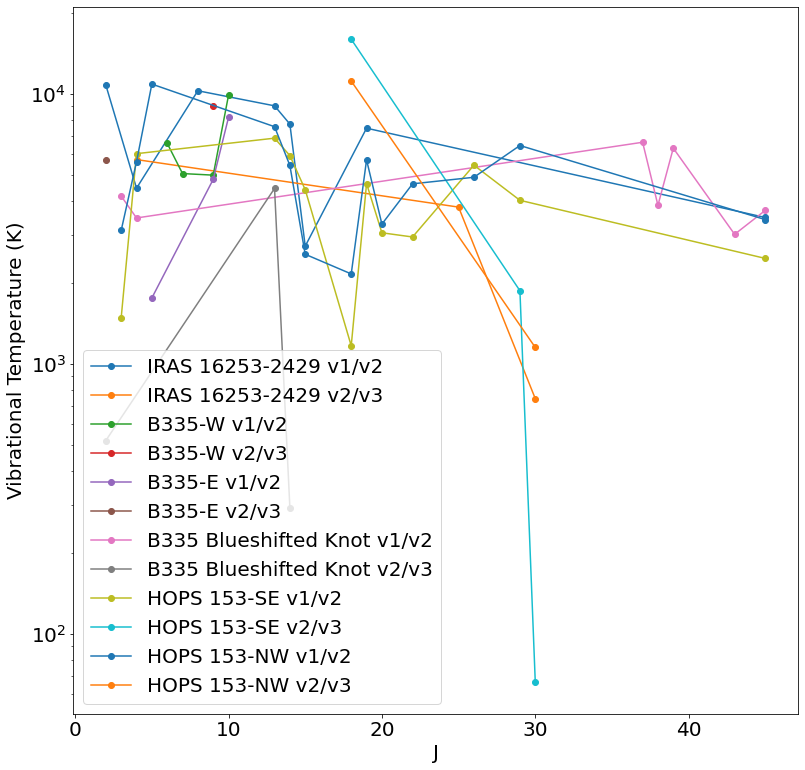

In [76]:
#first, an example calculation with vibrational states and boltzmann factors to check math
#then we output values for a table of gas mass and disk properties

#compute as function of temperature for each component...
'''
for co, we can do N(v=2)/N(v=1) and then N(v=3)/N(v=2) and see what we get
if sensible, this would act as measures of Tvib!
see https://phys.libretexts.org/Bookshelves/Astronomy__Cosmology/Stellar_Atmospheres_(Tatum)/08%3A_Boltzmann's_and_Saha's_Equations/8.04%3A_Boltzmann's_Equation
the boltzmann equation is Ni / Nj = gi/gj * exp(-kB * Tvib / delta_E)
Then N2 / N1 * g1 / g2 = exp(-kB * Tvib / delta_E)
log both sides and swap the T with the left side...
Then Tvib = -h*nui / kB / ln(N2/N1 * g1/g2)
And if we apply log law that ln(a^-1) = -ln(a), then...
Tvib = h * nui / kB * ln(N1/N2) if g2/g1 = 1
Then Tvib = E/kB * log((Ni / Nj)

In terms of uncertainty, we only have the uncertainty in the ln ratio, which is 
'''

#for line fitting
from scipy import stats

#make figure
plt.figure(figsize=(13,13))

#loop over all stars
T_vib_list = []
T_vib_unc_list = []
for i in range(len(rot_diag_sources)):
    #extract out values
    J_10, log_NJ_10, E_J_10 = log_NJ_gJ_saved[3*i]
    J_21, log_NJ_21, E_J_21  = log_NJ_gJ_saved[3*i+1]

    #sort values and matching J
    J_10_21 = np.array([J_10[j] for j,k in zip(range(len(J_10)), range(len(J_21))) if J_10[j] == J_21[k]])
    N_10_21 = np.array([log_NJ_10[j] - log_NJ_21[j] for j,k in zip(range(len(J_10)), range(len(J_21))) if J_10[j] == J_21[k]])
    E_10_21 = np.array([E_J_10[j] - E_J_21[j] for j,k in zip(range(len(J_10)), range(len(J_21))) if J_10[j] == J_21[k]])

    #compute positive vibrational temperatures
    T_v1_v2 = E_10_21 * -N_10_21

    #masking
    J_10_21 = J_10_21[T_v1_v2 > 0]
    E_10_21 = E_10_21[T_v1_v2 > 0]
    N_10_21 = N_10_21[T_v1_v2 > 0]
    T_v1_v2 = T_v1_v2[T_v1_v2 > 0]
    
    # print(J_10_21)
    # print(J_21_32)

    # print(np.nanmedian(T_v1_v2), np.nanmedian(T_v2_V3), 'avg tvib: ', np.mean([np.nanmedian(T_v1_v2), np.nanmedian(T_v2_V3)]))
    # print(np.nanstd(T_v1_v2, ddof=1), np.nanstd(T_v2_V3, ddof=1), 'avg unc: ', np.sqrt(np.nanstd(T_v1_v2, ddof=1)**2.0 + np.nanstd(T_v2_V3, ddof=1)**2.0))
    T_vib_list.append(np.mean([np.nanmedian(T_v1_v2)]))
    T_vib_unc_list.append(np.sqrt(np.nanstd(T_v1_v2, ddof=1)**2.0))
    print(np.nanstd(T_v1_v2, ddof=1))

    #plot logNratio vs. deltaE
    # if i >= 6:
    if i < 6:
        # slope, intercept, r_value, p_value, std_err = stats.linregress(-1.0/E_10_21, N_10_21)
        # plt.plot(-1.0/E_10_21, N_10_21, label=rot_diag_sources[i] + ' v1/v2', marker='o')
        # print(slope)  
        # plt.ylim(-25, 1)

        #plot T vs J
        plt.plot(J_10_21, T_v1_v2, label=rot_diag_sources[i] + ' v1/v2', marker='o')
        # plt.ylim(1e2, 1e6)
        plt.ylabel('Vibrational Temperature (K)', fontsize=20)
        plt.xlabel('J', fontsize=20)
        plt.yscale('log')

    #general formatting
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)  

2.1641564344165876e-05
0.009199085887687291
6.951922693042987e-05
0.0002247527674010239
0.00020219698435823094
1.3643945615246777e-05
0.04662498127261729
nan
nan
0.36481059312147823
12.179546814345324


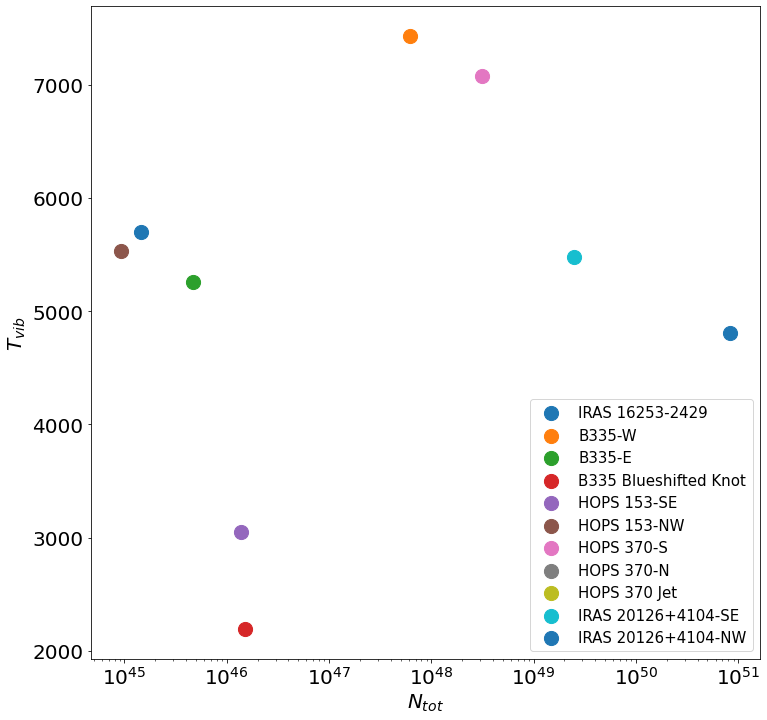

In [78]:
#vibrational constants
wavenum_v_CO = 2143.27156 #cm^-1 # see pg 76 of https://www.govinfo.gov/content/pkg/GOVPUB-C13-ce9e9f8bf57ba4aec0e1115a0bef0e38/pdf/GOVPUB-C13-ce9e9f8bf57ba4aec0e1115a0bef0e38.pdf or Table 56
E_v_CO = (3089+3084)/2 #averaging the J=0 and J=1 states to get close to the band center at ~4.67 microns (or P1)
Z_v_const = hc_cgs * wavenum_v_CO / k_B_cgs # equals h * c / kB, giving units of cm * K ... then I divide out the central wavelength of the whole forest, about 4.7 mic???
d_i = 1.0 #degeneracy in the excited v=1-0 state - it is a diatomic molecule! neither C nor O have spin

#computing Z, E, and the prediction according to boltzmann 
# Z_v_0 = (1.0 - np.exp(-Z_v_const*p_above_5k[1]))**-d_i #notice that this approx only uses Z(all v) ~= Z(v=0)
# E_T_ratio = (1./p_above_5k[1] / E_v_CO) #notice that E is in units of kB. So can just take E/T or E * slope

#noting by hand from last cell
# T_vib_list = [5992.442502492737, 7430.287525269987, 5254.790392900535, 2313.668686394652, 3059.41709368204, 5511.6268905229335, \
#               7788.721883898603, 6235.997307874084, 5509.5592837127915, 5479.747486007946, 4562.102988904788]
# T_vib_list = [round(i, -2) for i in T_vib_list]
# T_vib_list = [370, 1320, 520, 580, 240, 270, 360, 320, 100, 730, 350]

#one last needed constant for masses
mass_units = 6e3 * 1.67e-24 * 2.8  / 1.899e30 # / 2e33

#looping, need some lists to fill
N_tot_list = []
M_gas_list = []
plt.figure(figsize=(12,12))
for i in range(len(T_vib_list)):
    N10_1 = N_intercept_saved[i * 3][0]
    N10_2 = N_intercept_saved[i * 3][1]
    # N21 = N_intercept_saved[i * 3 + 1][0]
    # N32 = N_intercept_saved[i * 3 + 2][0]

    Z_CO_v = (1 - np.exp(-Z_v_const / T_vib_list[i]))**(-d_i)
    Ntot = (N10_1) / (np.exp(-T_vib_list[i] / E_v_CO)) * (Z_CO_v)
    # print(Ntot)

    M_gas_nir = mass_units * Ntot
    print(M_gas_nir)

    #save data
    N_tot_list.append(Ntot)
    M_gas_list.append(M_gas_nir)

    plt.scatter(Ntot, T_vib_list[i], label=rot_diag_sources[i], s=200)

plt.xscale('log')
plt.legend(fontsize=15)
plt.xlabel(r'$N_{tot}$', fontsize=20)
plt.ylabel(r'$T_{vib}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)  

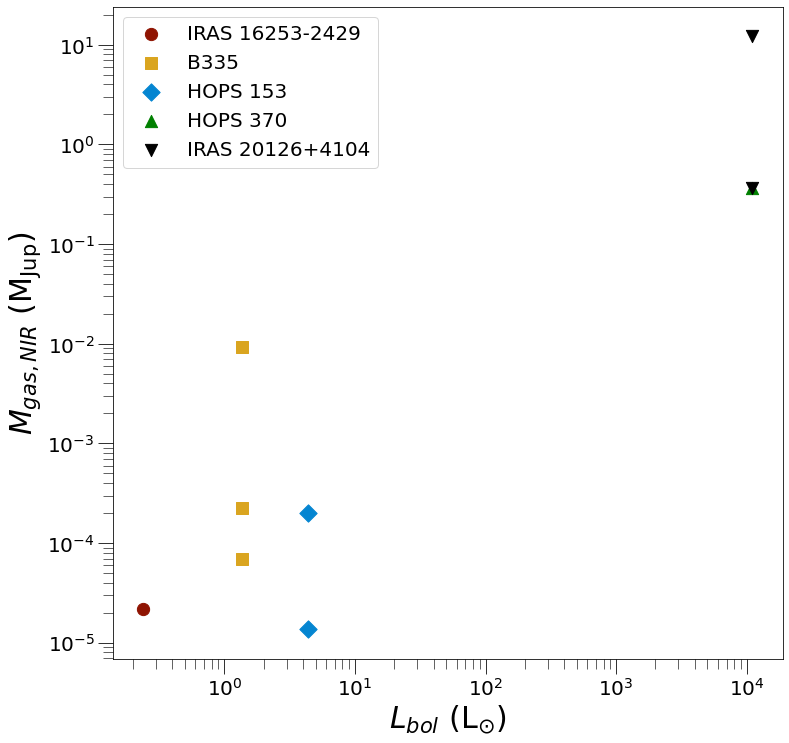

In [79]:
#plotting a correlation! first we compare N or M with a stellar property
Lbol_list = np.array([0.24, 1.36, 3.8, 276.0, 1.1e4]) #in Lsun
Lbol_moresources_list = np.array([0.24, 1.36, 1.36, 4.4, 4.4, 276.0, 276.0, 1.1e4, 1.1e4]) #in Lsun
Rdisk_list = np.array([8, 10, 150, 100, 860]) #in au
# Ncool_list = [1e33, 1e33, 4.1e35, 1.9e35, 1.5e36]
# Nwarm_list = [3e26, 1.8e26, 2.2e27, 1.5e29, 3.3e30]
# Nhot_list = [9.9e23, 6.8e24, 1.4e25, 1.6e27, 1.5e27]

#make a plot
plt.figure(figsize=(12,12))

#plot data
plt.scatter(Lbol_moresources_list[0], M_gas_list[0], s=150, color='xkcd:brick red', label=protostar_fullnames[0], marker='o')
plt.scatter(Lbol_moresources_list[1:4], M_gas_list[1:4], s=150, color='goldenrod', label=protostar_fullnames[1], marker='s')
plt.scatter(Lbol_moresources_list[4:6], M_gas_list[4:6], s=150, color='xkcd:cerulean', label=protostar_fullnames[2], marker='D')
plt.scatter(Lbol_moresources_list[7:10], M_gas_list[7:10], s=150, color='green', label=protostar_fullnames[3], marker='^')
plt.scatter(Lbol_moresources_list[9:], M_gas_list[9:], s=150, color='black', label=protostar_fullnames[4], marker='v')

# plt.scatter(Lbol_moresources_list, M_gas_list, marker='o', s=100, color='black')
# plt.errorbar(Lbol_list, Ntot_list, yerr=3.*Ntot_err_list, ls='none', marker='o', markersize=5, elinewidth=3, color='black', label='Measurement')
# plt.plot(Lbol_list, Ncool_list, linestyle='-', color='red', marker='v', markersize=10, label='Cool')
# plt.plot(Lbol_list, Nwarm_list, linestyle=':', color='xkcd:brick orange', marker='o', markersize=10, label='Warm')
# plt.plot(Lbol_list, Nhot_list, linestyle='--', color='blue', marker='^', markersize=10, label='Hot')

#fit a line quickly...
# fit = np.polyfit(np.log10(Lbol_moresources_list), np.log10(M_gas_list), deg=1)
# plt.plot(Lbol_moresources_list, 10**(fit[0] *np.log10(Lbol_moresources_list) + fit[1]), color='black', label='Linear Fit')

# #a whole lot of formatting to do
# plt.xscale('log')
# plt.yscale('log')
# plt.ylabel(r'$\rm N_{tot}$ of CO, v = $1-0$', fontsize=20)
# plt.xlabel(r'$\rm L_{bol} \ (L_{\odot})$', fontsize=20)
# plt.tick_params(axis='x', labelsize=15)
# plt.tick_params(axis='y', labelsize=15)
# plt.tick_params(axis='x', which='major', length=10)
# plt.tick_params(axis='y', which='major', length=10)
# plt.tick_params(axis='x', which='minor', length=5)
# plt.tick_params(axis='y', which='minor', length=5)
# # plt.legend(loc='best', fontsize=20)
# plt.savefig('CentralSource_CO/Lbol_N_corr.pdf')

# plt.errorbar(Lbol_list, np.array(N_v0_list) * mass_units, yerr=3.*Ntot_err_list * mass_units, ls='none', marker='o', markersize=5, elinewidth=3, color='black', label='Measurement')
# plt.plot(Lbol_list, Ncool_list, linestyle='-', color='red', marker='v', markersize=10, label='Cool')
# plt.plot(Lbol_list, Nwarm_list, linestyle=':', color='xkcd:brick orange', marker='o', markersize=10, label='Warm')
# plt.plot(Lbol_list, Nhot_list, linestyle='--', color='blue', marker='^', markersize=10, label='Hot')

#fit a line quickly...
# fit = np.polyfit(np.log10(Lbol_list), np.log10(np.array(N_v0_list) * mass_units), deg=1)
# plt.plot(Lbol_list, 10**(fit[0] *np.log10(Lbol_list) + fit[1]), color='black', label='Linear Fit')

#a whole lot of formatting to do
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'$M_{gas,NIR} \rm \ (M_{Jup})$', fontsize=30)
plt.xlabel(r'$L_{bol} \rm \ (L_{\odot})$', fontsize=30)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(axis='x', which='major', length=15)
plt.tick_params(axis='y', which='major', length=15)
plt.tick_params(axis='x', which='minor', length=10)
plt.tick_params(axis='y', which='minor', length=10)
plt.legend(loc='best', fontsize=20)
plt.savefig('CentralSource_CO/Lbol_Msun_corr.pdf')

# print(Ntot_list)
# print(3.*np.array(Ntot_err_list))
# # print(np.array(Ntot_list) * 1e4 * 2e-24 / 2e33)
# print(np.array(N_v0_list) * mass_units)



[1.00000000e-10 4.04357946e-07 4.04357946e-07 4.04357946e-07
 9.31778407e-07 9.31778407e-07 3.50687509e-05 3.50687509e-05
 3.50687509e-05 2.49269066e-04 2.49269066e-04]
[0.00039167 0.00560031 0.00888429 0.02849149 0.0325084  0.01467272
 0.0569785         nan        nan 0.2649376  0.31572401]
[3.09637739e-06 1.32393212e-04 2.22498624e-04 8.25432605e-04
 7.65352008e-04 3.12745122e-04 1.32608457e-03            nan
            nan 5.19041955e-03 6.32247296e-03]


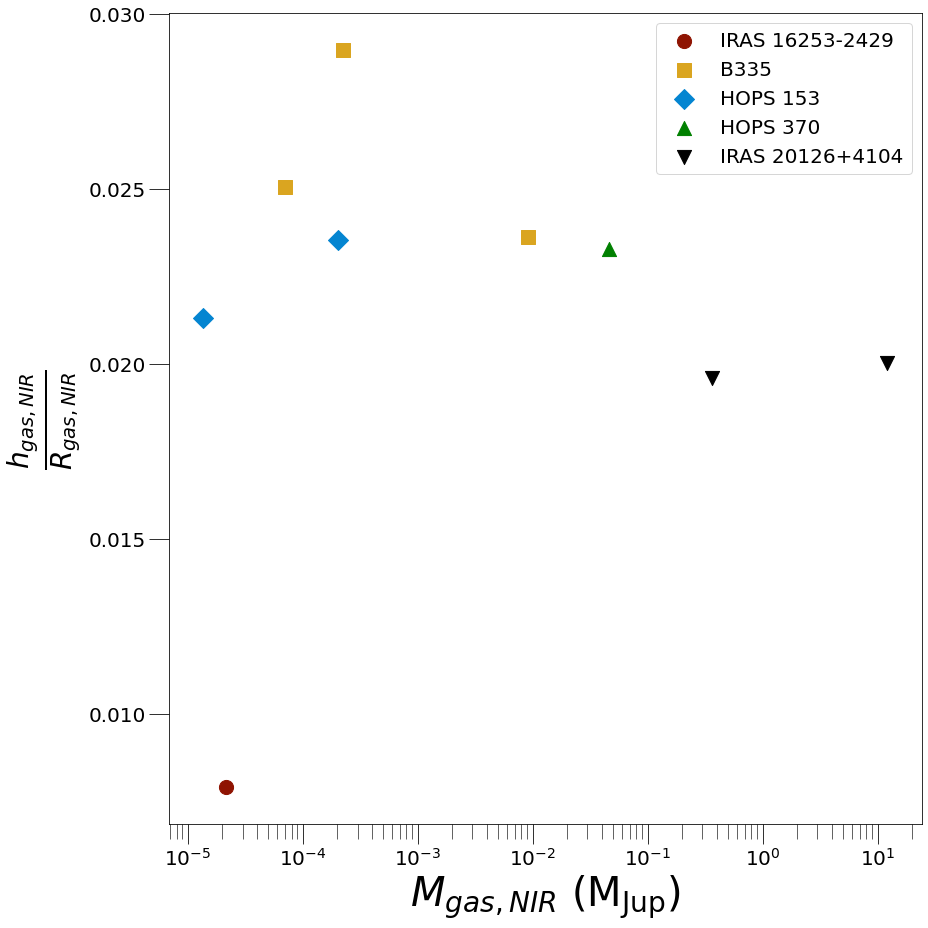

In [80]:
# now trying to calculate Rdisk, hdisk from my previous equations...
G_cgs = 6.67e-8 #cgs, dyn cm^2 / g^2
sigma_sf_cgs = 5.6704e-5 #g/s^3/K^4
k_B_cgs = 1.4e-16 #erg/K

#calculate sound speed
cs_mass_units = 1.67e-24 * 2.8 #this is mproton * mu 
c_s_list = np.sqrt( (k_B_cgs * np.array(T_vib_list)) / cs_mass_units )

#calculate keplerian disk frequency
eta = 2
M_star_list = np.array([0.12, 0.25, 0.25, 0.6, 0.6, 2.5, 2.5, 12.7, 12.7]) *2e33
R_star_list = np.array([3, 1.17, 1.17, 2, 2, 5, 5, 4.53, 4.53]) *6.957e10
Mdot_acc_list = np.concatenate(([1e-10 * 1.989e33/3.15e7], eta/G_cgs * ( (Lbol_moresources_list[1:]*3.846e33) \
    * (R_star_list[1:]) / (M_star_list[1:])) ) ) #in Msun per year?
print(Mdot_acc_list / 1.989e33 * 3.15e7 ) #in Msun/yr
Rdisk_nir = (3 / (8 * np.pi * sigma_sf_cgs) * G_cgs * M_star_list * Mdot_acc_list / (np.array(T_vib_list)**4.0))**(1.0/3.0)
print(Rdisk_nir/1.496e+13)
omega_K_list = np.sqrt(G_cgs * M_star_list / Rdisk_nir**3.0) #putting everything together

#calculate heights
hdisk_nir = c_s_list / omega_K_list
print(hdisk_nir/1.496e+13)

#setup a figure
fig = plt.figure(figsize=(13,13))
ax1 = fig.add_subplot(111)
# ax2 = ax1.twiny()

#plot
# ax1.scatter(Rdisk_nir[0]/1.496e+13, M_gas_list[0], s=150, color='xkcd:brick red', label=protostar_fullnames[0], marker='o')
# ax1.scatter(Rdisk_nir[1:4]/1.496e+13, M_gas_list[1:4], s=150, color='goldenrod', label=protostar_fullnames[1], marker='s')
# ax1.scatter(Rdisk_nir[4:6]/1.496e+13, M_gas_list[4:6], s=150, color='xkcd:cerulean', label=protostar_fullnames[2], marker='D')
# ax1.scatter(Rdisk_nir[7:10]/1.496e+13, M_gas_list[7:10], s=150, color='green', label=protostar_fullnames[3], marker='^')
# ax1.scatter(Rdisk_nir[9:]/1.496e+13, M_gas_list[9:], s=150, color='black', label=protostar_fullnames[4], marker='v')

ax1.scatter(M_gas_list[0], hdisk_nir[0] / Rdisk_nir[0], s=200, color='xkcd:brick red', label=protostar_fullnames[0], marker='o')
ax1.scatter(M_gas_list[1:4], hdisk_nir[1:4] / Rdisk_nir[1:4], s=200, color='goldenrod', label=protostar_fullnames[1], marker='s')
ax1.scatter(M_gas_list[4:6], hdisk_nir[4:6] / Rdisk_nir[4:6], s=200, color='xkcd:cerulean', label=protostar_fullnames[2], marker='D')
ax1.scatter(M_gas_list[6:9], hdisk_nir[6:9] / Rdisk_nir[6:9], s=200, color='green', label=protostar_fullnames[3], marker='^')
ax1.scatter(M_gas_list[9:], hdisk_nir[9:] / Rdisk_nir[9:], s=200, color='black', label=protostar_fullnames[4], marker='v')

#format second axis (h)
# ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks(hdisk_nir/1.496e+13)
# ax2.set_xticklabels(hdisk_nir/1.496e+13)
# ax2.set_xlabel(r'$h_{gas,NIR} \rm \ (au)$', fontsize=30)
# ax2.set_xscale('log')

#format main plot
# ax1.set_xscale('log')
ax1.set_xscale('log')
ax1.set_xlabel(r'$M_{gas,NIR} \rm \ (M_{Jup})$', fontsize=40)
ax1.set_ylabel(r'$\frac{h_{gas,NIR}}{R_{gas,NIR}}$', fontsize=40)
ax1.legend(fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', which='major', length=20)
ax1.tick_params(axis='y', which='major', length=20)
ax1.tick_params(axis='x', which='minor', length=15)
ax1.tick_params(axis='y', which='minor', length=15)

#save
fig.tight_layout()
fig.savefig('CentralSource_CO/aspect_Mgas_corr.pdf')

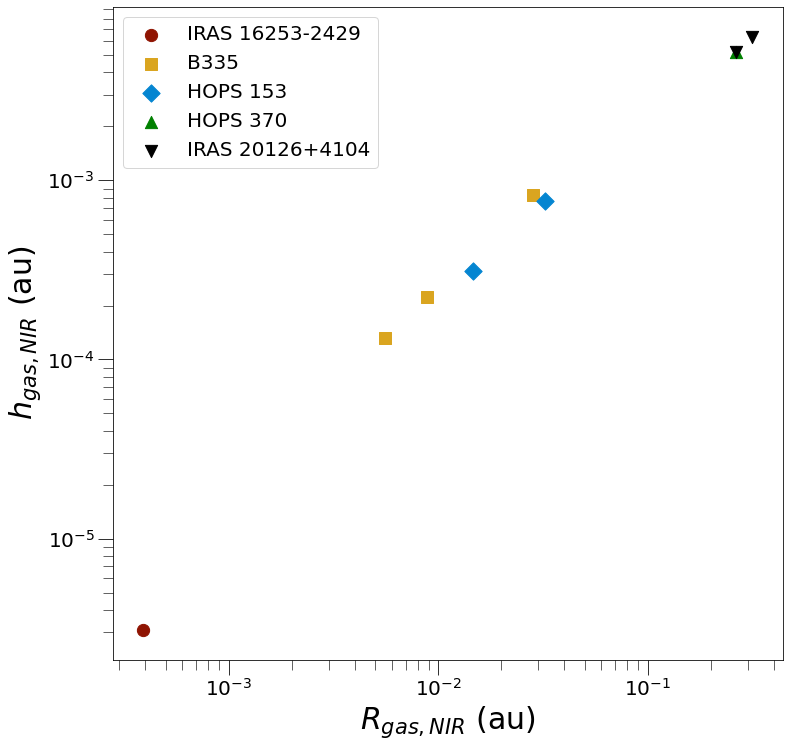

In [81]:
#setup a figure
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)
# ax2 = ax1.twiny()

#plot
ax1.scatter(Rdisk_nir[0]/1.496e+13, hdisk_nir[0]/1.496e13, s=150, color='xkcd:brick red', label=protostar_fullnames[0], marker='o')
ax1.scatter(Rdisk_nir[1:4]/1.496e+13, hdisk_nir[1:4]/1.496e13, s=150, color='goldenrod', label=protostar_fullnames[1], marker='s')
ax1.scatter(Rdisk_nir[4:6]/1.496e+13, hdisk_nir[4:6]/1.496e13, s=150, color='xkcd:cerulean', label=protostar_fullnames[2], marker='D')
ax1.scatter(Rdisk_nir[7:10]/1.496e+13, hdisk_nir[7:10]/1.496e13, s=150, color='green', label=protostar_fullnames[3], marker='^')
ax1.scatter(Rdisk_nir[9:]/1.496e+13, hdisk_nir[9:]/1.496e13, s=150, color='black', label=protostar_fullnames[4], marker='v')
# ax1.scatter( M_gas_list, hdisk_nir/1.496e+13, s=150, color='black')
# ax1.scatter(Rdisk_nir/1.496e+13, hdisk_nir/1.496e+13, s=150, color='black')

#format second axis (h)
# ax2.set_xlim(ax1.get_xlim())
# ax2.set_xticks(hdisk_nir/1.496e+13)
# ax2.set_xticklabels(hdisk_nir/1.496e+13)
# ax2.set_xlabel(r'$h_{gas,NIR} \rm \ (au)$', fontsize=30)
# ax2.set_xscale('log')

#format main plot
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$h_{gas,NIR} \rm \ (au)$', fontsize=30)
ax1.set_xlabel(r'$R_{gas,NIR} \rm \ (au)$', fontsize=30)
ax1.legend(fontsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', which='major', length=15)
ax1.tick_params(axis='y', which='major', length=15)
ax1.tick_params(axis='x', which='minor', length=10)
ax1.tick_params(axis='y', which='minor', length=10)


Other possible references to simple disk models...

Some code by Colette Salyk: https://github.com/csalyk/spectools_ir/blob/main/docs/example.ipynb (or in general see her papers)

Diskmint by Deng et al: https://arxiv.org/pdf/2307.02657.pdf (especially page 4 or see the similar ... Zagarai et al Appendix: https://arxiv.org/pdf/2304.01760.pdf )

In [85]:
#form table of derived rotational diagram properties
table_cols = ['CO Source', 'Tvib', 'NCo,tot', 'Mgas,NIR', 'Mdotacc', 'Rgas,NIR', 'hgas,NIR']
vib_props_sources = ['IRAS 16253-2429', 'B335-W', 'B335-E', 'HOPS 153-SE', 'HOPS 153-NW', \
              'HOPS 370-S', 'HOPS 370-N', 'IRAS 20126+4104-SE', 'IRAS 20126+4104-NW']
vib_props_table = Table(names=(table_cols), dtype=[str, str, str, str, str, str, str])

for i in range(len(vib_props_sources)):
    vib_props_table.add_row([ \
        vib_props_sources[i],
        str(round(T_vib_list[i], -1)) + ' $\pm$ ' + str(round(T_vib_unc_list[i], -1)),             
        latex_float(N_tot_list[i]),
        latex_float(M_gas_list[i]),
        latex_float(Mdot_acc_list[i] / 1.989e33 * 3.15e7),
        latex_float(Rdisk_nir[i]/1.496e+13),
        latex_float(hdisk_nir[i]/1.496e+13)
        ])
        
path = 'CentralSource_CO/'
table_name = 'co_vib_props.txt'
# co_flux_table.sort(table_cols[0])
vib_props_table.write(path + table_name, format='latex', overwrite=True)